### create hourly Fraser turbidity time series where gaps 4 hrs or less are filled by linear interpolation

### create daily averages from hourly time series and fill larger gaps based on interpolation of daily averages

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
import re
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc

from sqlalchemy.sql import select, and_, or_, not_, func
from sqlalchemy import create_engine, Column, String, Integer, Boolean, MetaData, Table, case, between, ForeignKey, desc
from sqlalchemy.orm import mapper, create_session, relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
import sqlalchemy.types as types
from sqlalchemy.sql import select, and_, or_, not_, func
from time import strptime
import string
import pandas as pd
from dateutil.parser import parse as dutparse
#from dataProcess import forceNumeric, forceInt, fmtVarName, data2Tbl, adFunONC

%matplotlib inline

In [2]:
# set to last available data!
startdate=dt.date(2009,1,1)
enddate=dt.date(2013,1,1)

In [3]:
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'ECBuoy/'
dbname='ECBuoy'
Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
FBuoyTBL=Base.classes.FBuoyTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

In [4]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + dt.timedelta(n)

In [5]:
dt.datetime(1900,1,1)+dt.timedelta(days=session.query(FBuoyTBL.DecDay).order_by(FBuoyTBL.DecDay).first()[0])

datetime.datetime(2009, 1, 1, 0, 10, 21)

In [6]:
dt.datetime(1900,1,1)+dt.timedelta(days=session.query(FBuoyTBL.DecDay).order_by(desc(FBuoyTBL.DecDay)).first()[0])

datetime.datetime(2019, 6, 17, 16, 10)

In [7]:
df=pd.DataFrame(session.query(FBuoyTBL.DecDay,FBuoyTBL.Turb_NTU).filter(and_(
            FBuoyTBL.Turb_NTU.between(0,200),
            FBuoyTBL.DecDay.between((startdate-dt.date(1900,1,1)).days,
                    (enddate-dt.date(1900,1,1)).days))).all()) # filter out really large values as well as negatives

In [8]:
df['daynum']=0*df['DecDay']
df['hr']=0*df['DecDay']

In [9]:
# create hash of daynum, hour pairs that are in df (where there is data)
#timeSet=set()
for index, row in df.iterrows():
    day=int(np.floor(row['DecDay']))
    hr=int(np.round((row['DecDay']-day)*24))
    df.iloc[index]['daynum','hr']=[day,hr]
    #timeSet=timeSet|set([(day,hr)])
#timeSet

In [10]:
# desired time series is from startdate to enddate
ndays=(enddate-startdate).days+1
ndays

1462

In [11]:
dfout=pd.DataFrame(index=np.arange(0,ndays*24),
                   columns=('DayNum','Hour','Turb_NTU'))
dfdaily=pd.DataFrame(index=np.arange(0,ndays),columns=('DayNum','Turb_NTU'))

In [12]:
for ind,row in dfout.iterrows():
    dfout.iloc[ind]['DayNum','Hour']=[np.floor(ind/24.0)+(startdate-dt.date(1900,1,1)).days,ind%24]
    
for ind,row in dfdaily.iterrows():
    dfdaily.iloc[ind]['DayNum']=ind+(startdate-dt.date(1900,1,1)).days

In [13]:
df[(df.daynum==(startdate-dt.date(1900,1,1)).days)&(df.hr==0)]

DecDay  Turb_NTU   daynum   hr
0  39812.007187       6.7  39812.0  0.0

In [14]:
df[(df.daynum==(startdate-dt.date(1900,1,1)).days)&(df.hr==0)].iloc

In [15]:
df[(df.daynum==(enddate-dt.date(1900,1,1)).days)&(df.hr==23)]

Empty DataFrame
Columns: [DecDay, Turb_NTU, daynum, hr]
Index: []

/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


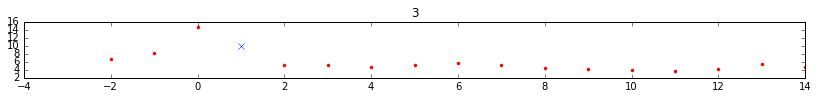

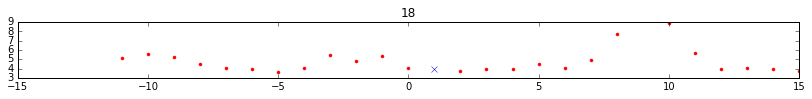

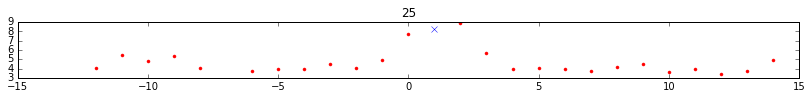

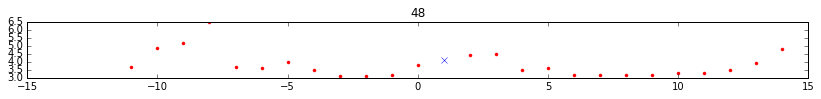

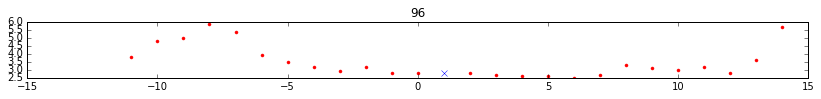

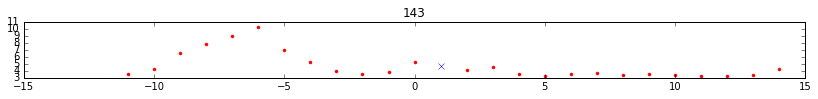

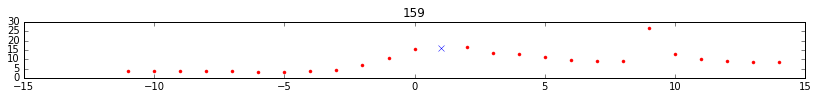

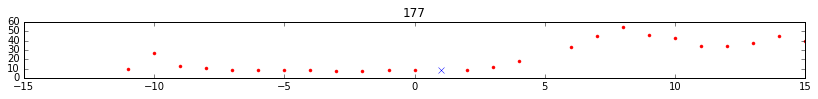

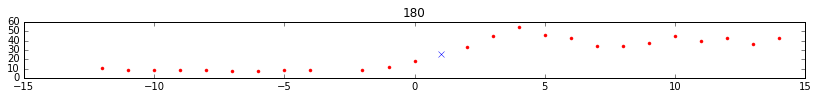

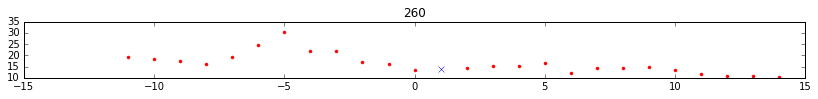

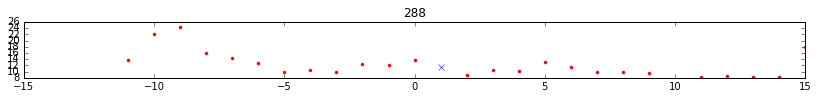

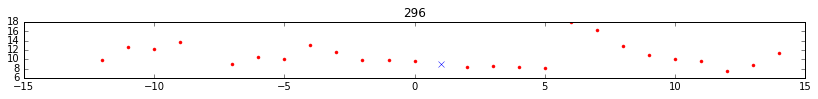

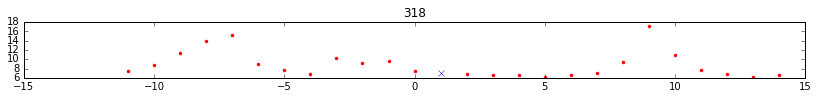

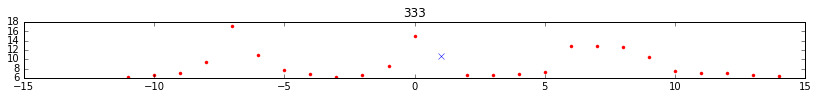

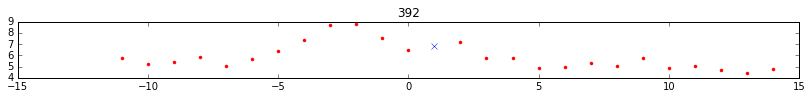

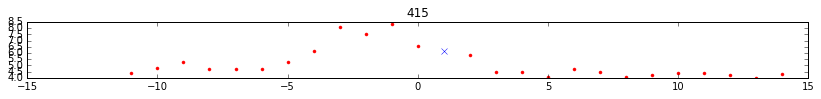

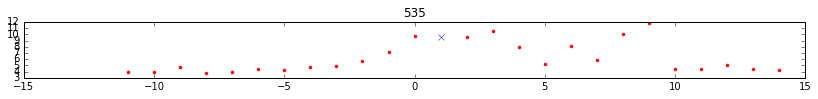

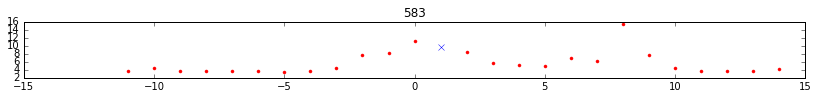

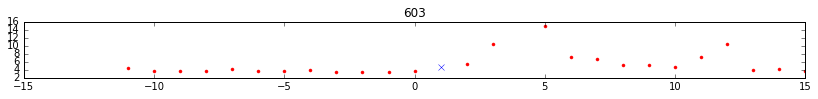

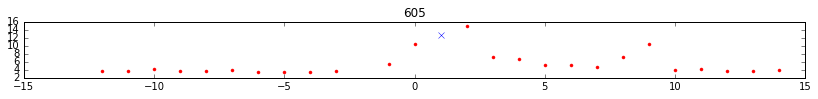

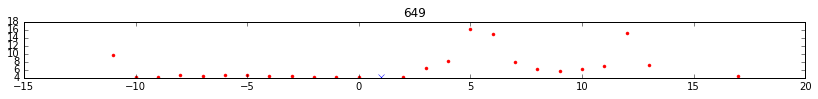

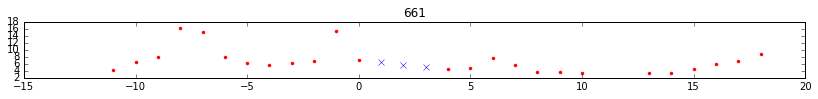

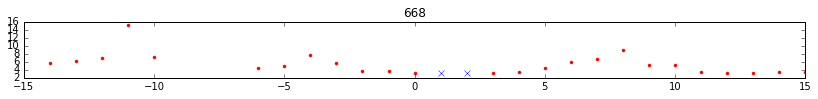

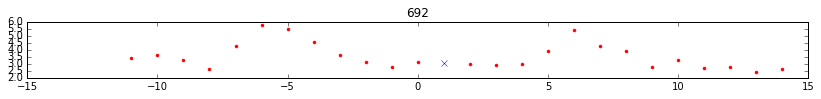

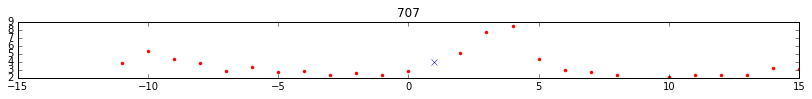

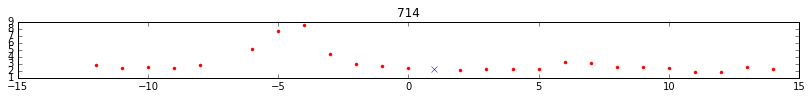

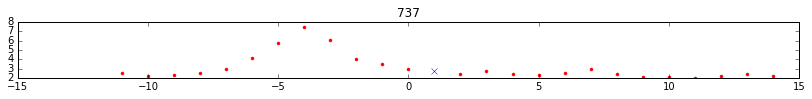

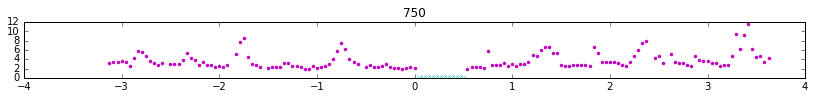

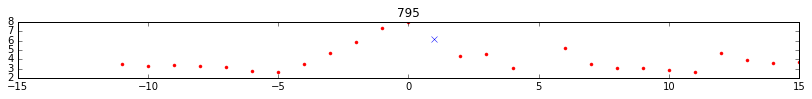

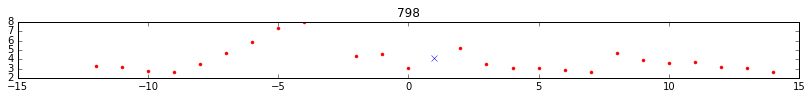

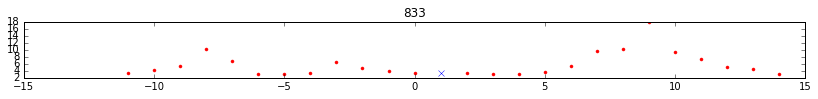

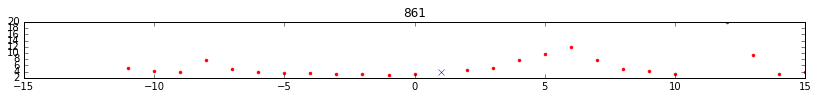

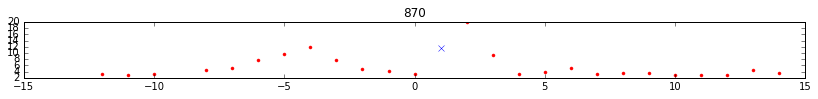

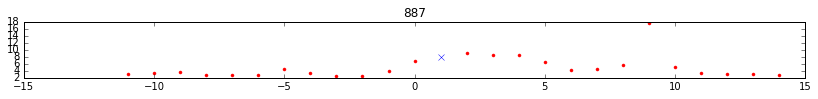

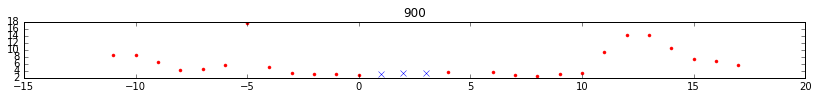

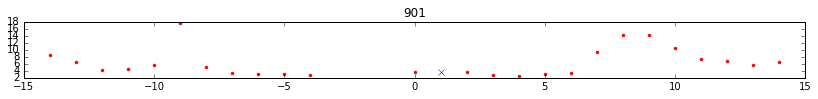

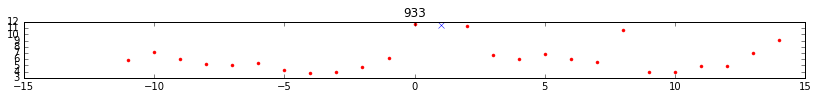

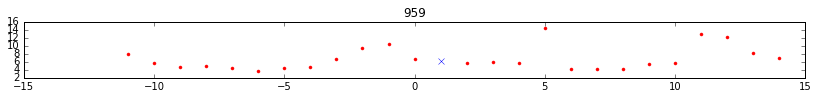

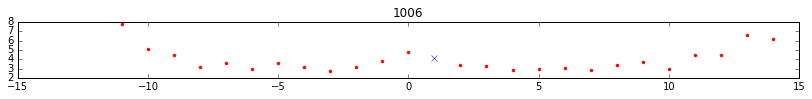

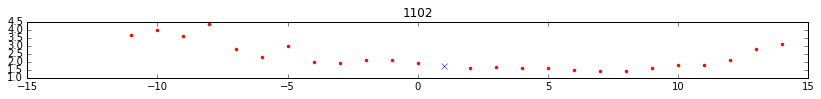

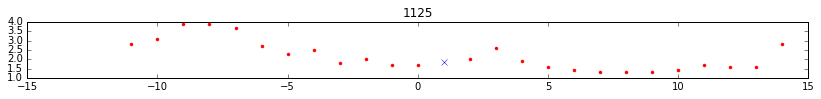

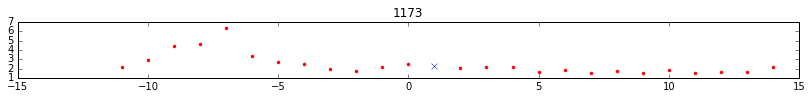

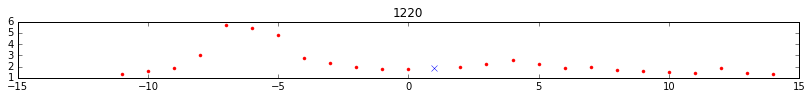

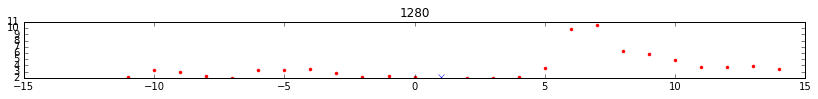

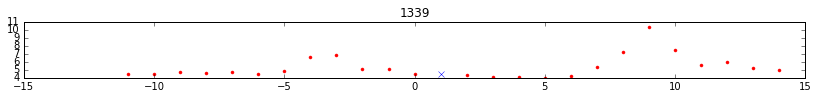

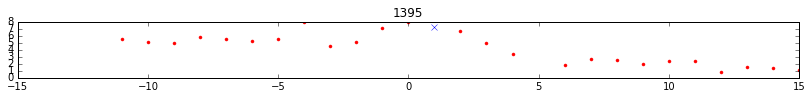

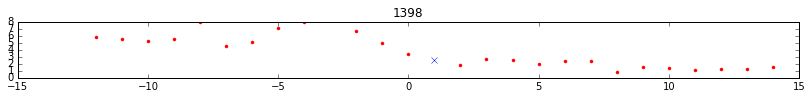

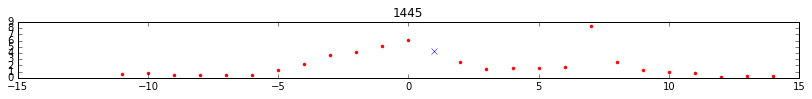

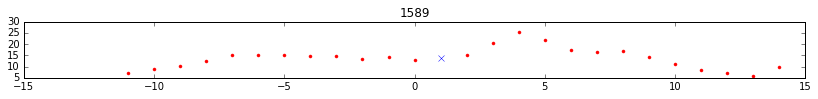

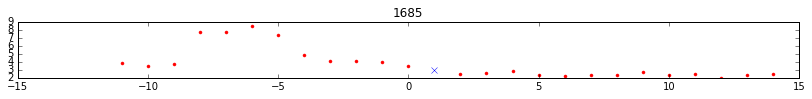

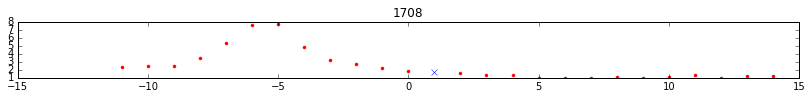

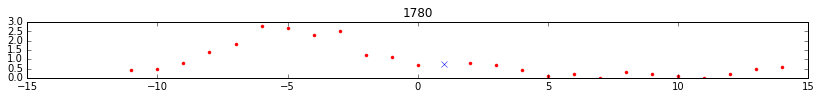

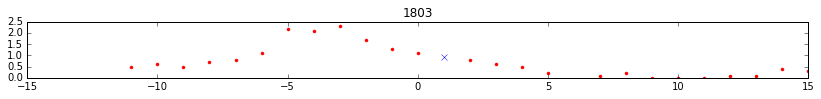

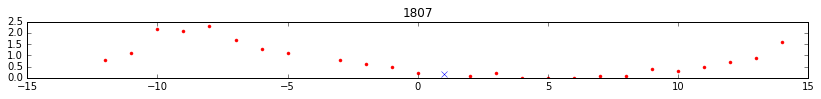

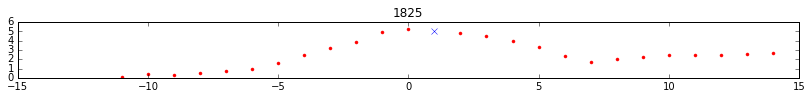

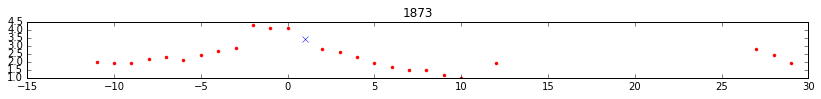

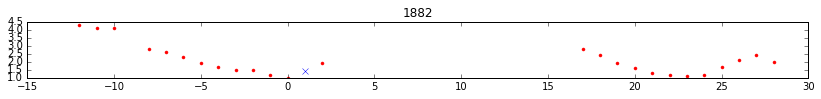

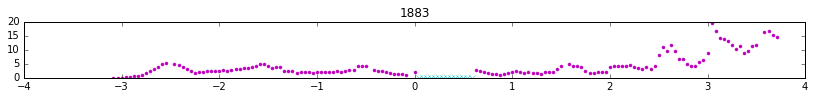

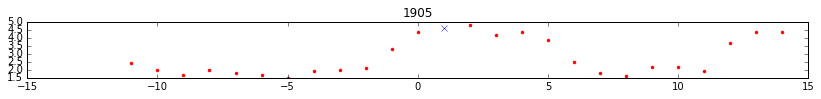

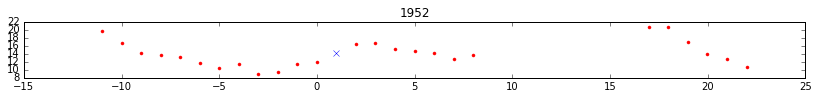

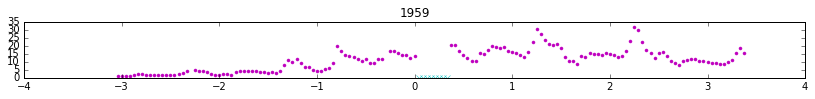

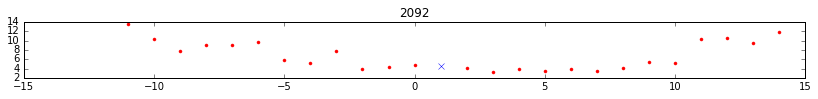

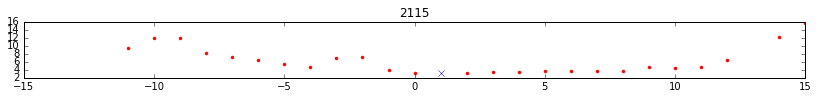

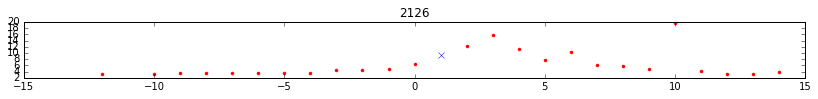

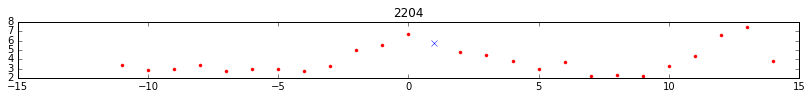

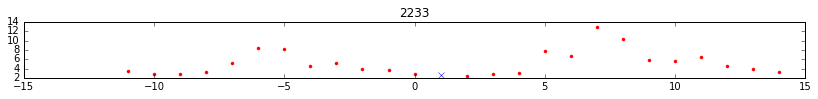

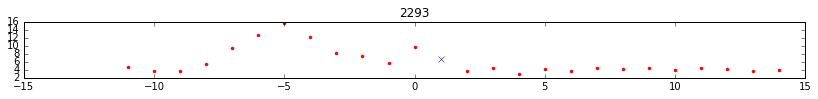

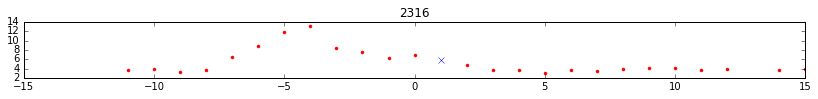

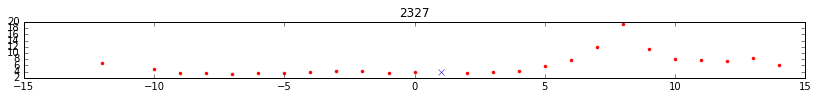

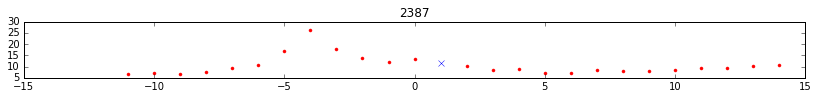

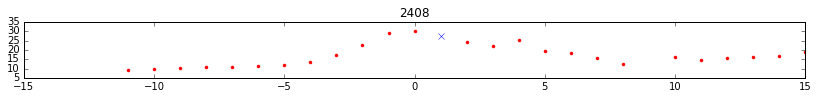

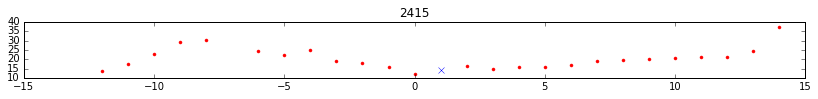

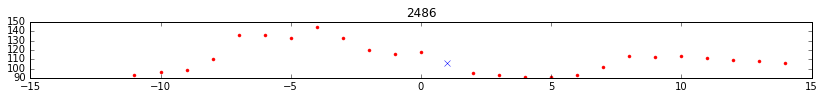

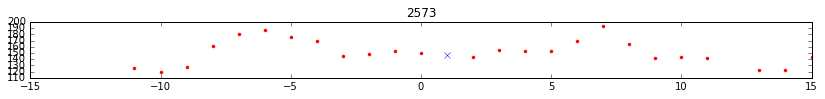

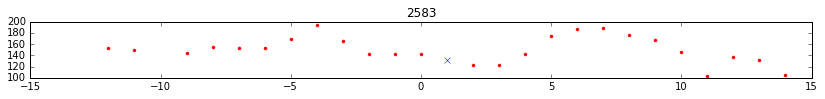

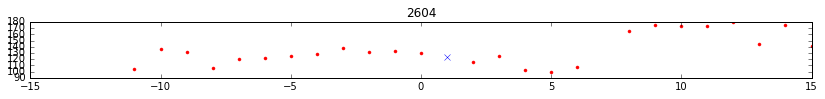

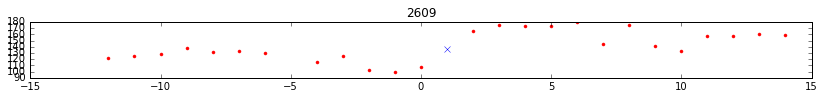

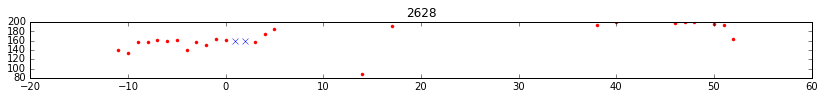

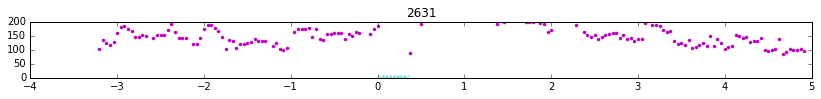

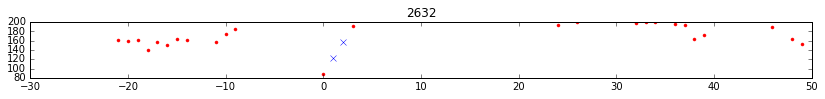

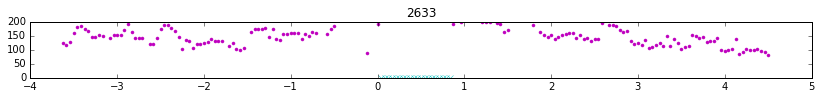

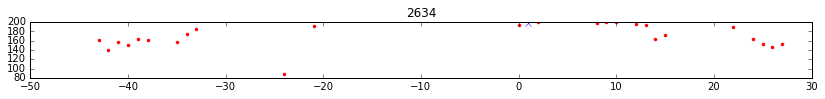

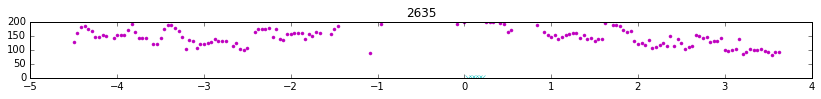

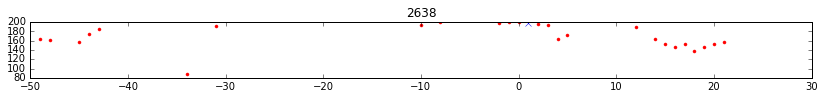

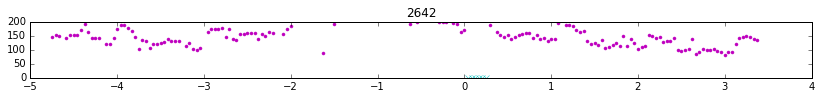

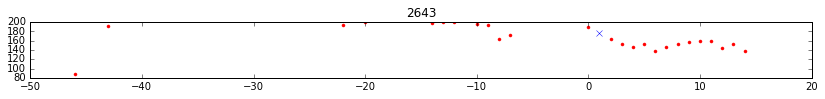

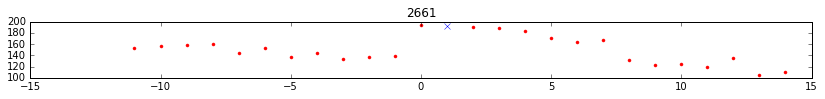

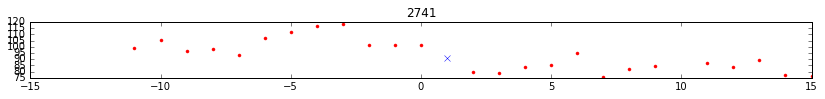

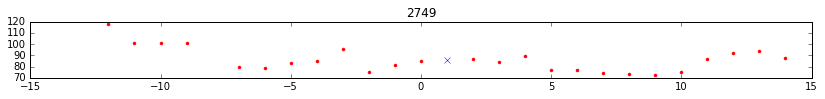

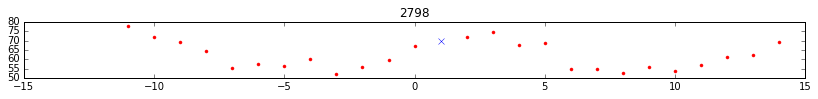

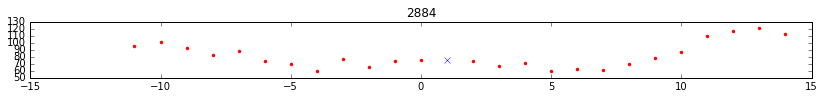

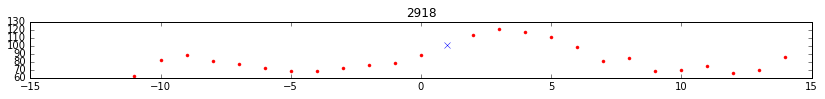

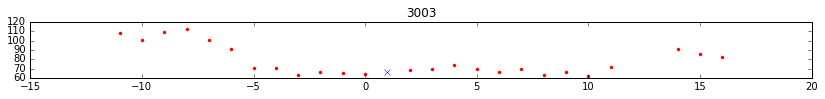

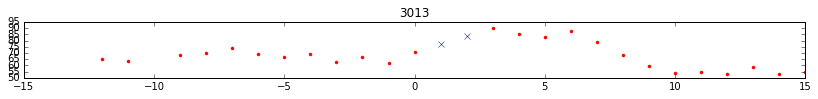

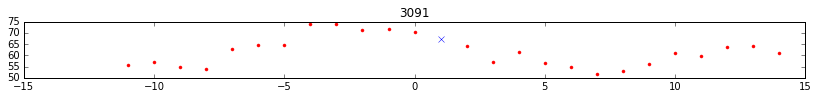

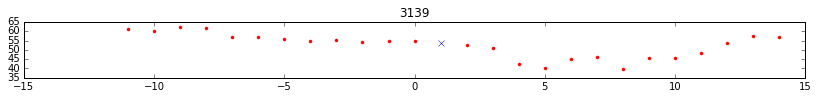

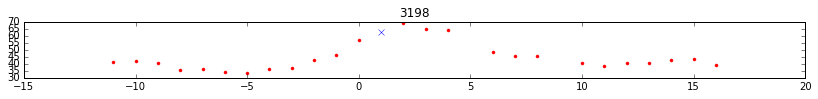

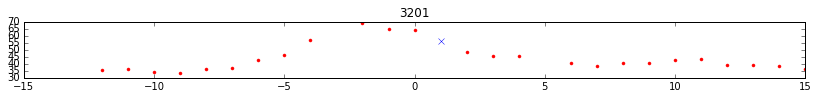

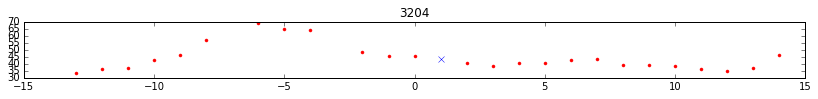

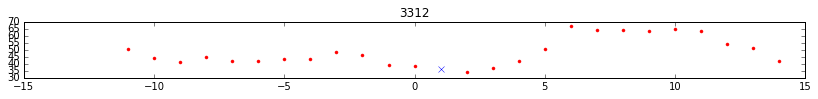

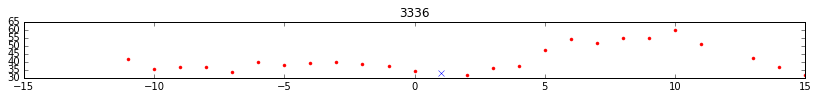

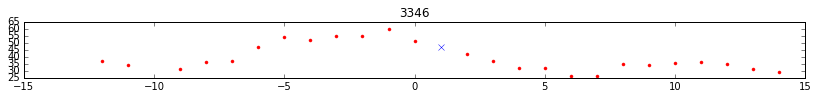

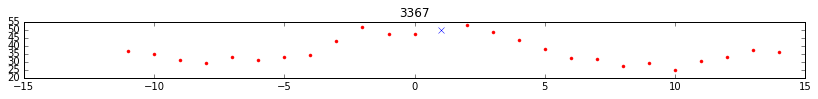

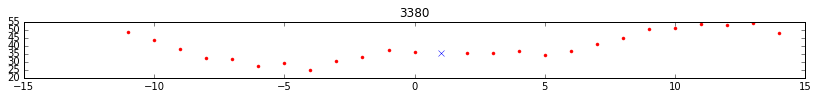

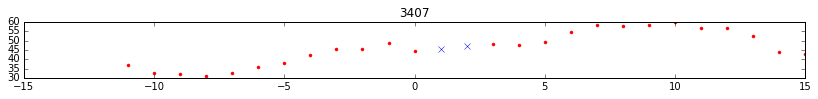

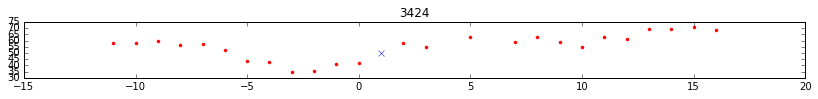

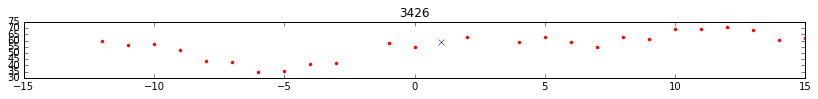

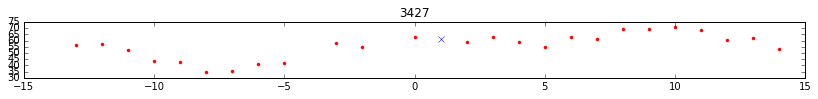

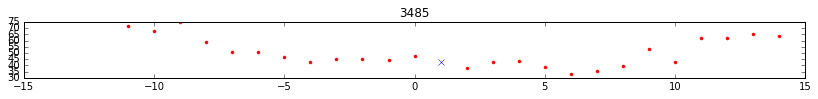

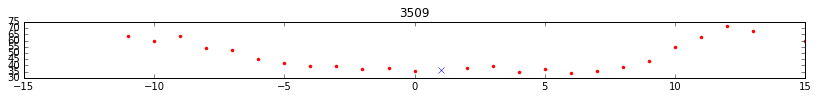

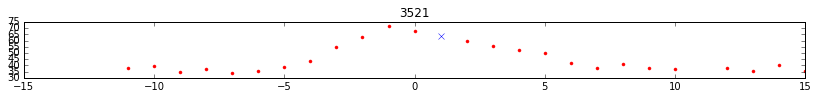

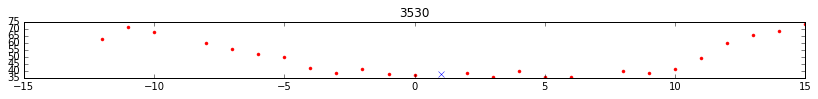

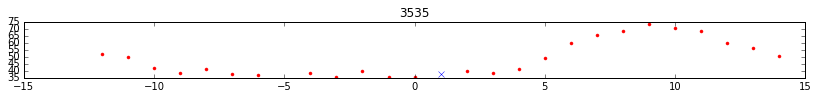

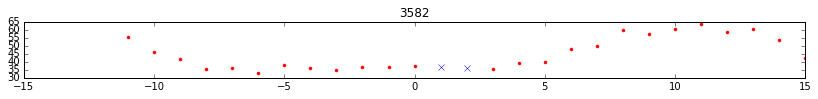

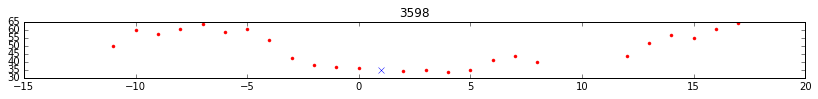

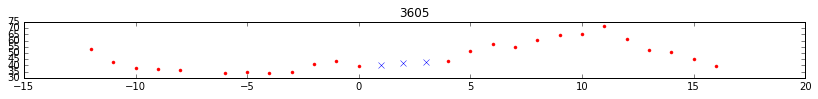

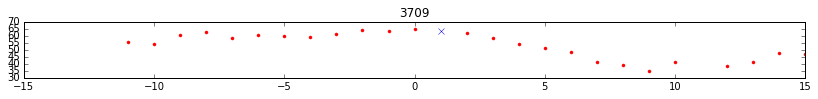

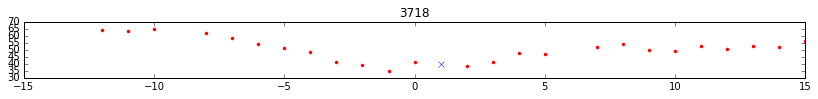

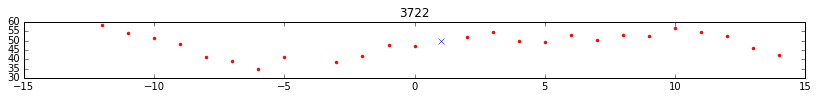

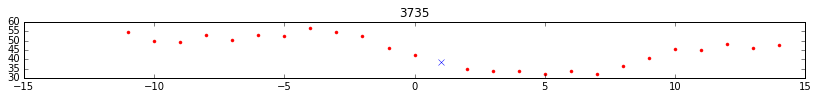

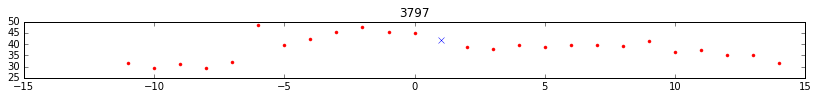

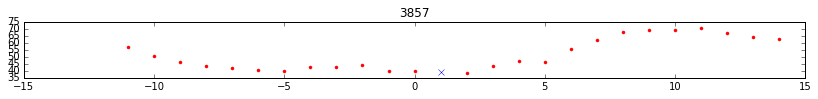

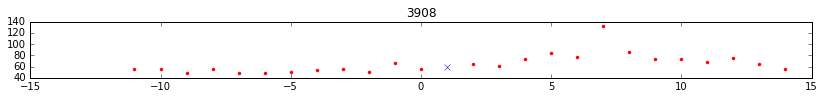

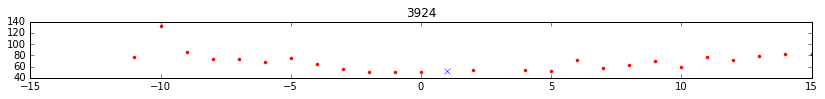

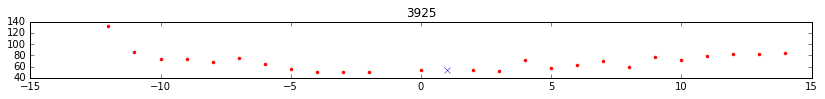

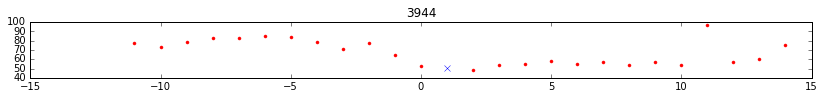

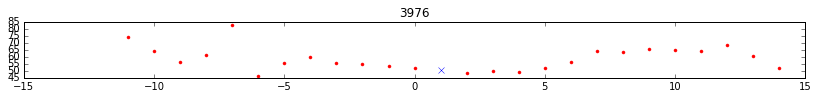

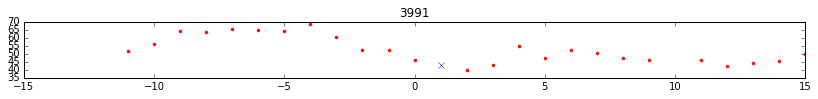

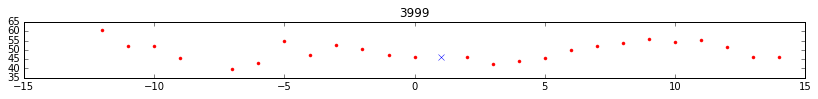

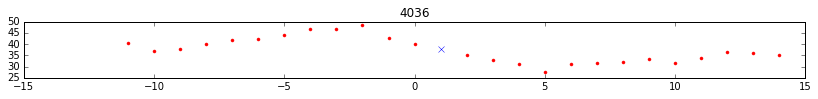

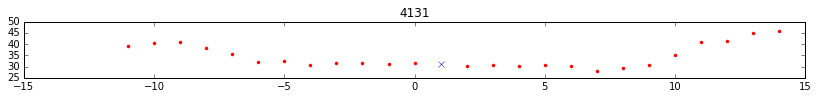

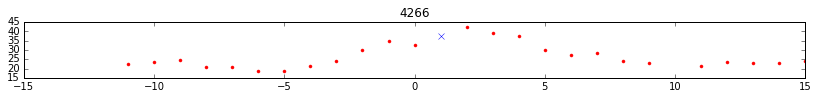

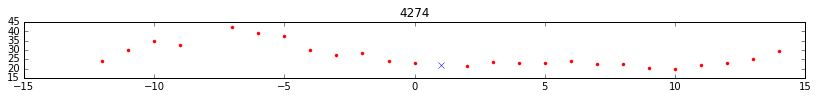

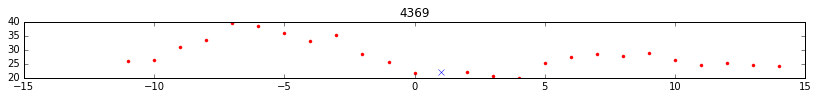

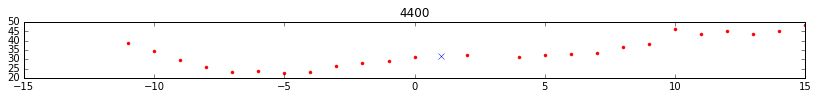

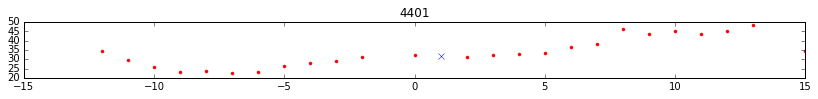

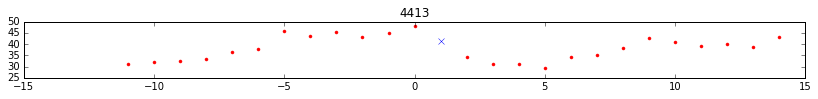

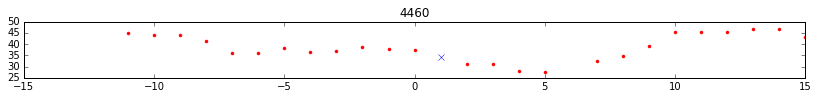

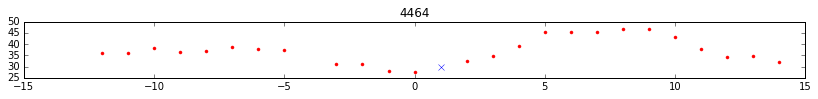

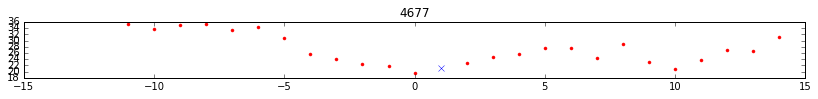

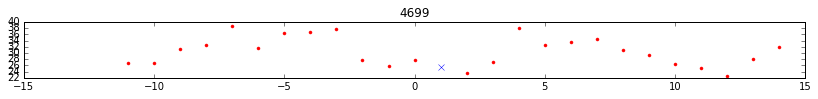

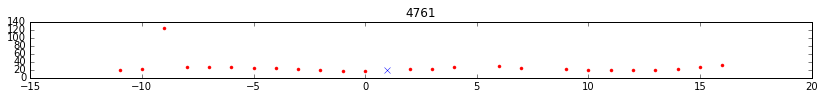

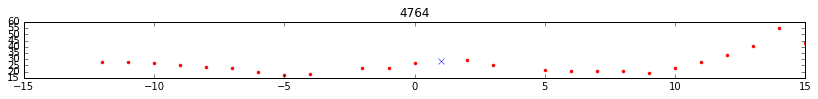

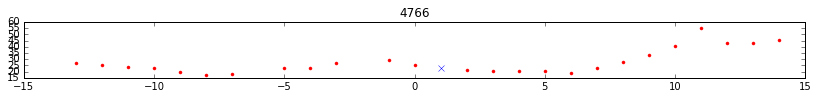

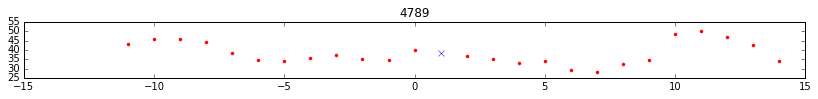

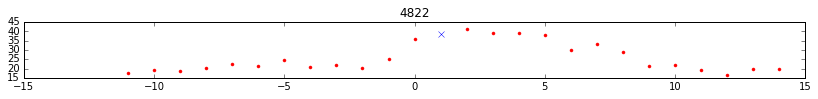

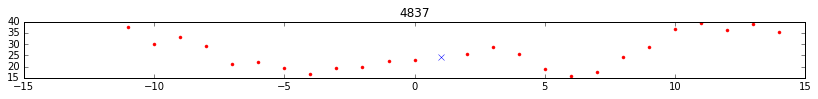

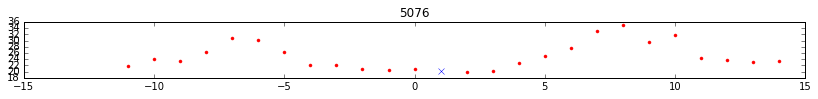

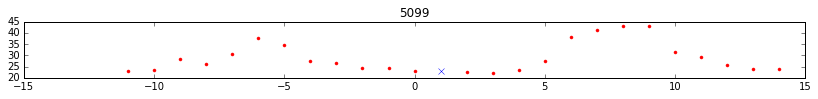

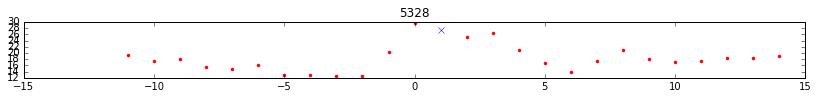

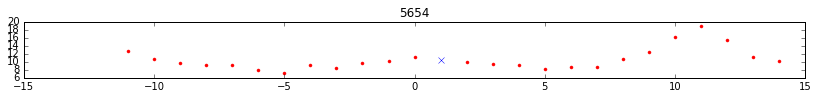

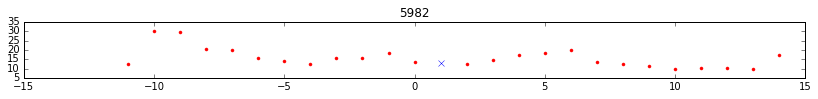

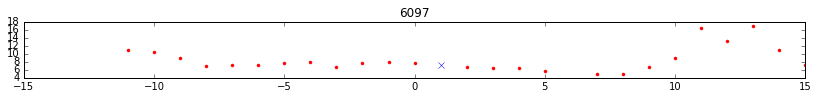

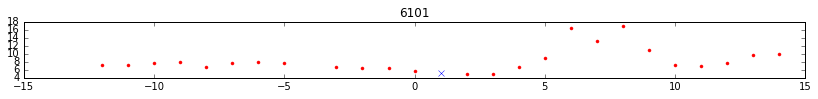

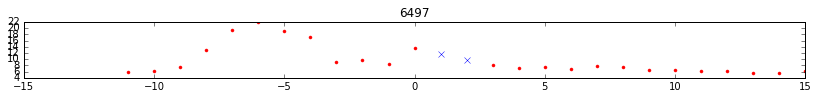

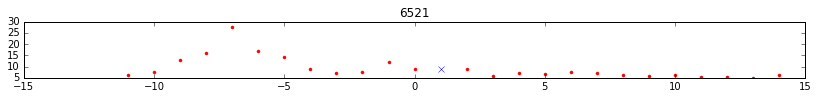

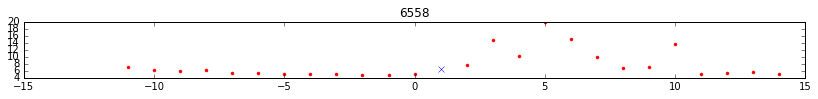

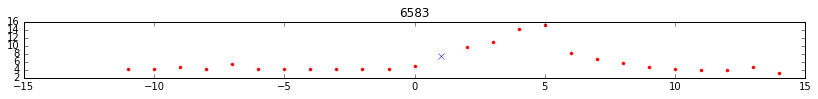

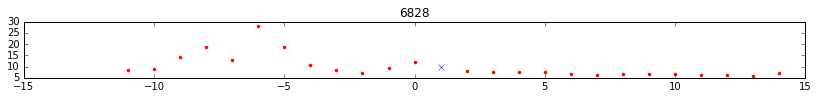

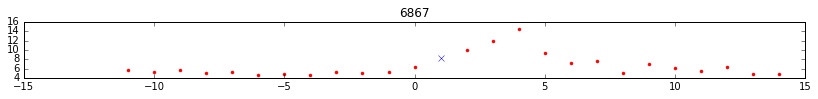

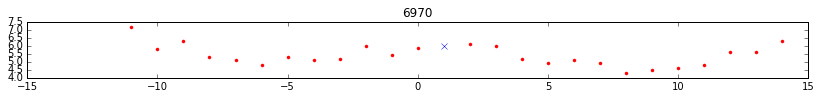

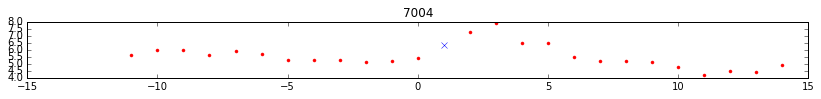

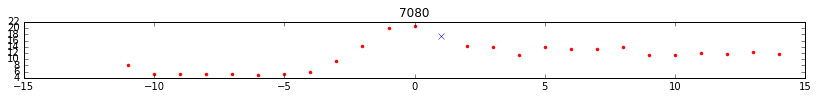

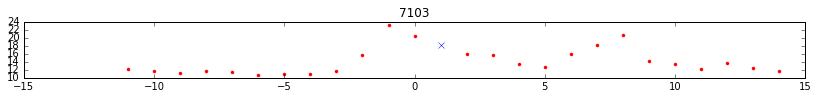

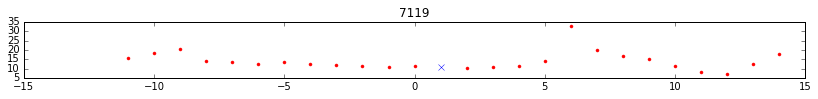

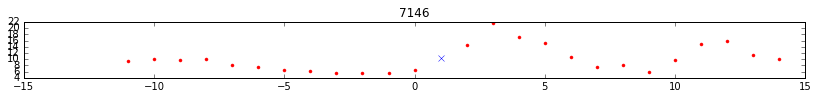

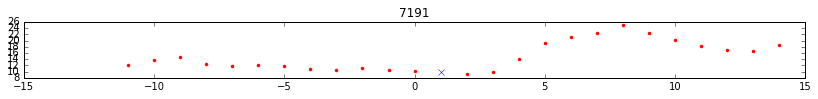

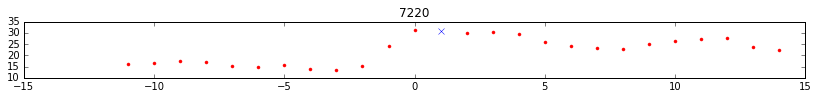

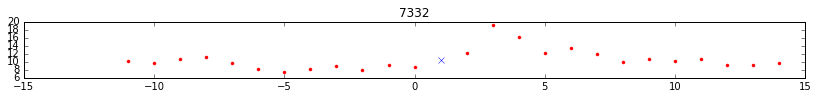

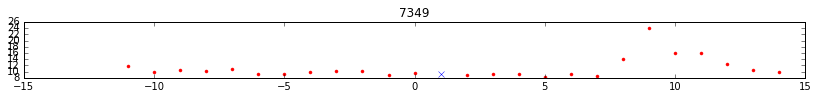

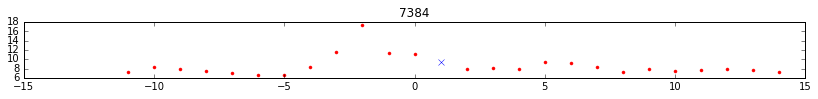

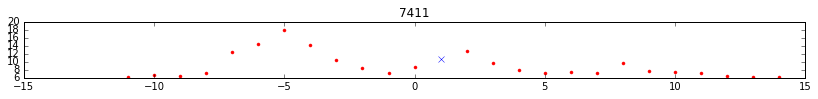

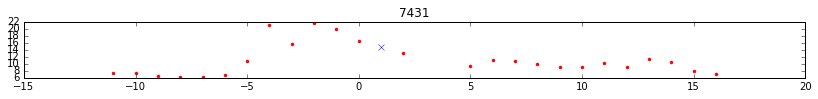

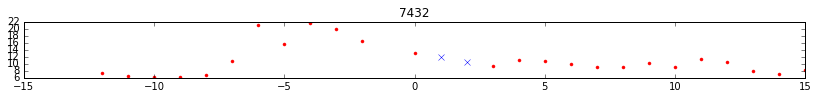

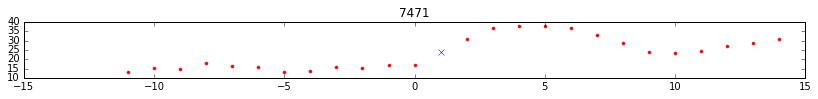

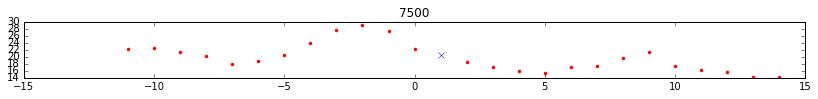

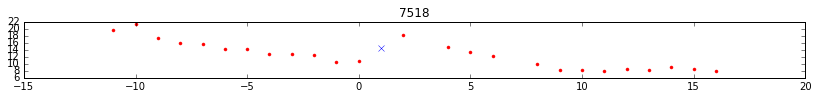

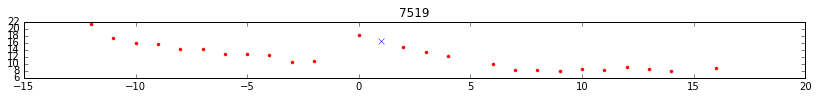

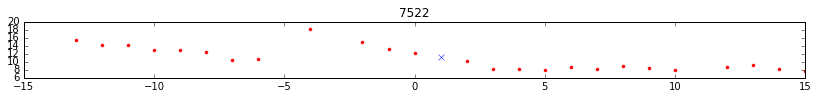

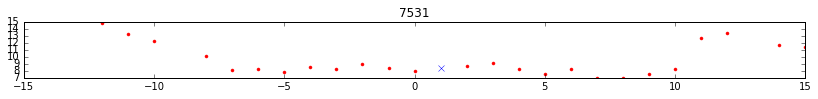

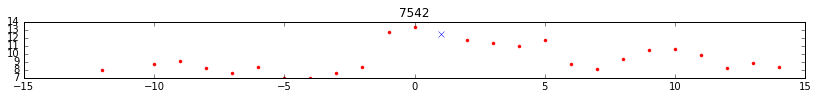

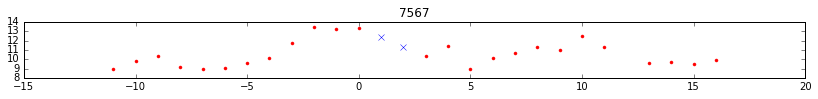

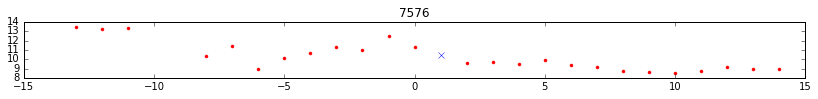

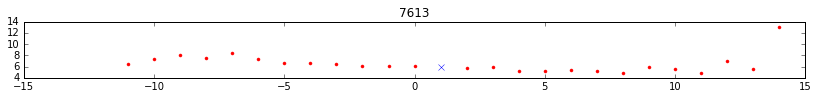

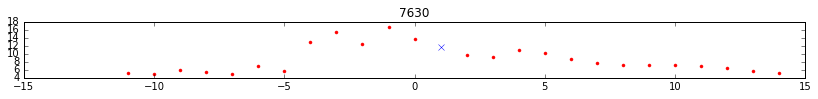

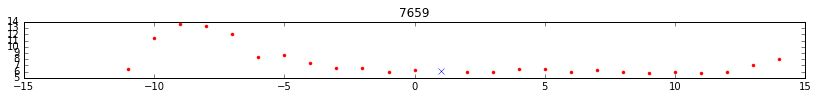

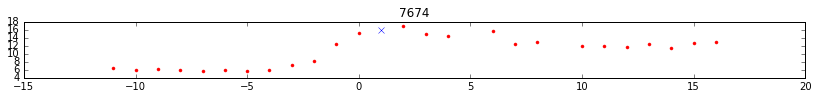

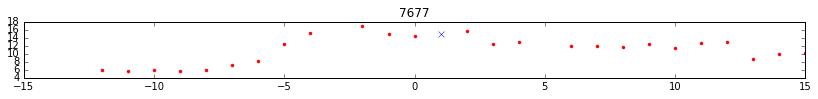

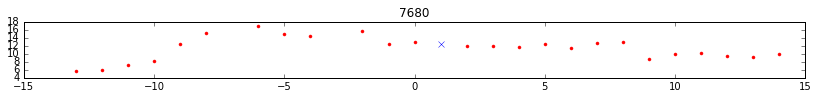

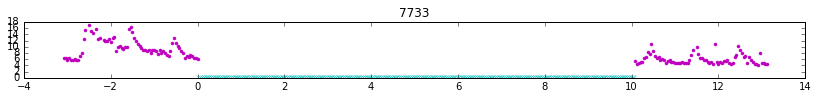

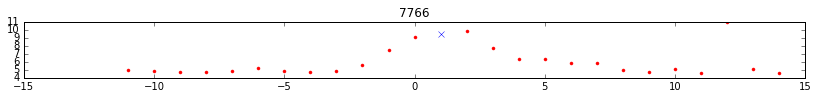

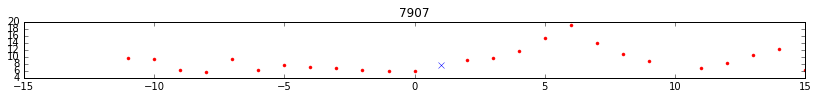

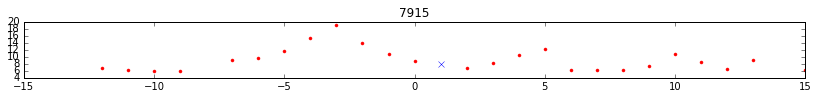

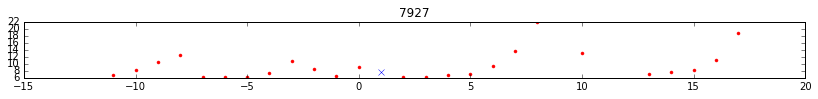

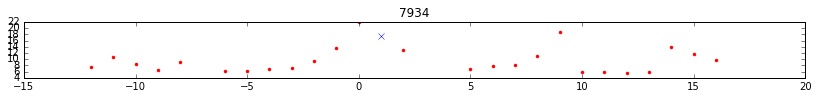

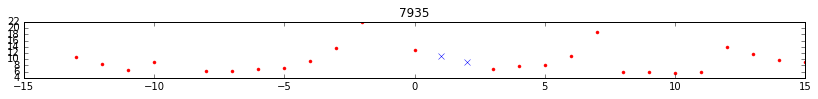

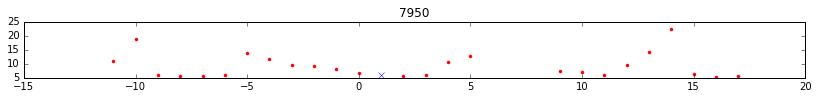

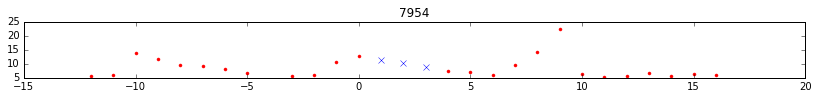

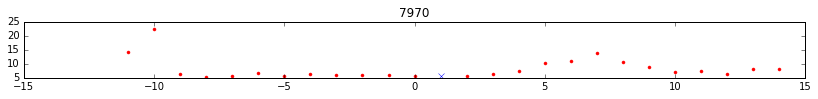

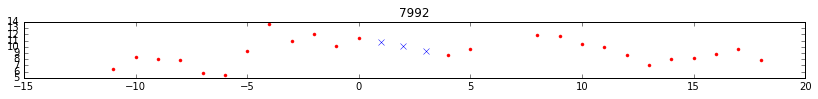

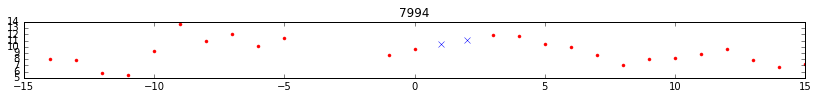

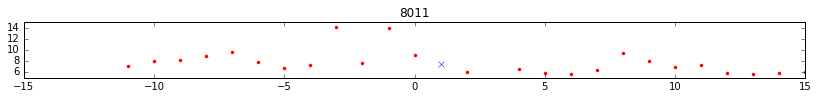

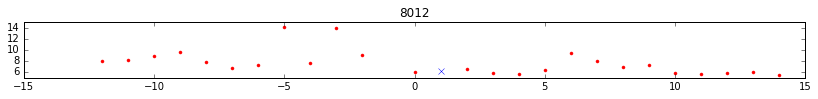

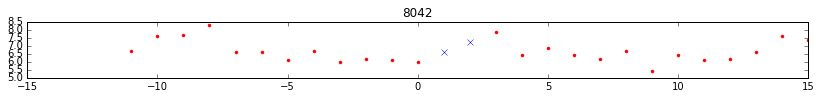

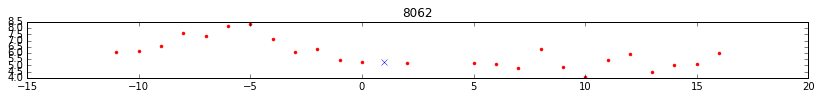

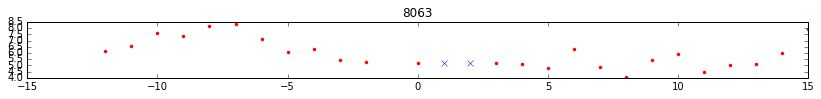

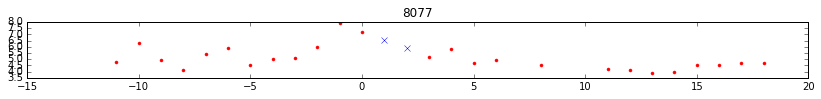

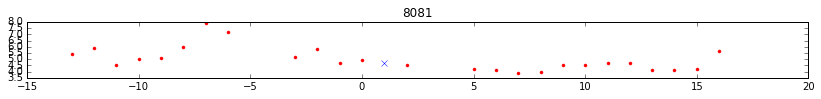

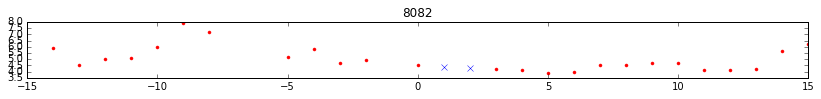

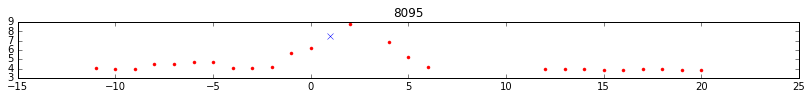

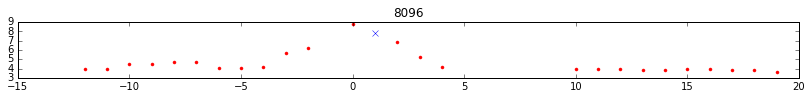

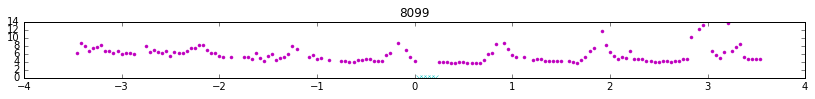

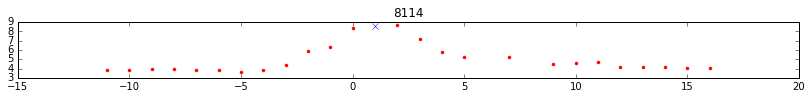

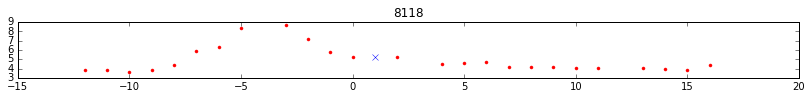

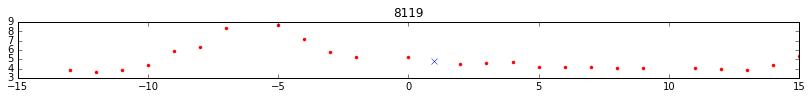

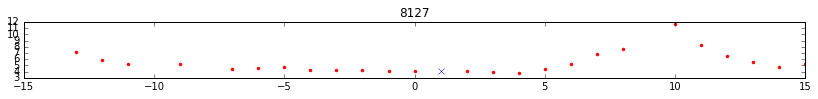

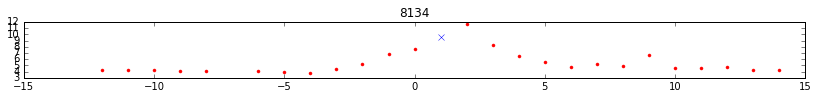

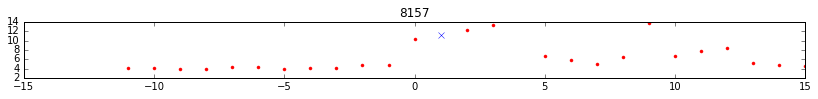

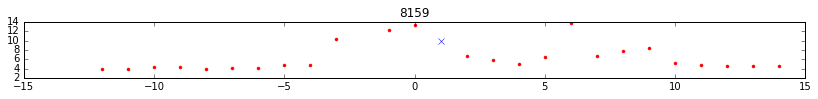

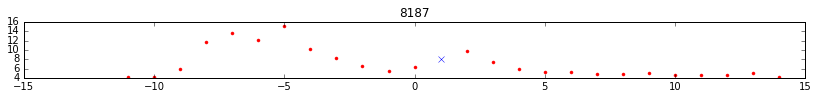

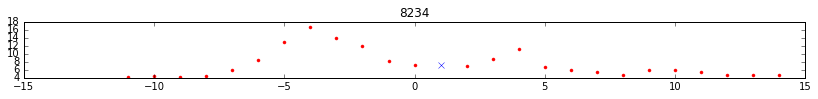

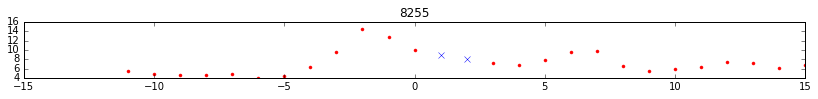

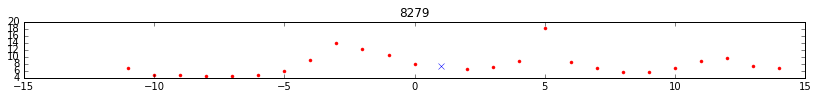

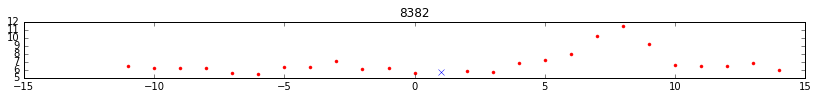

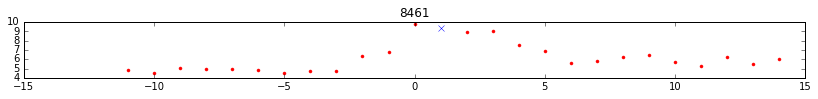

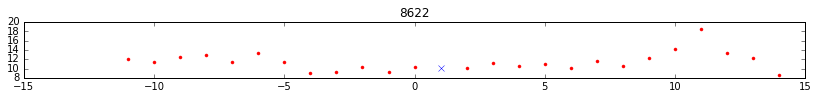

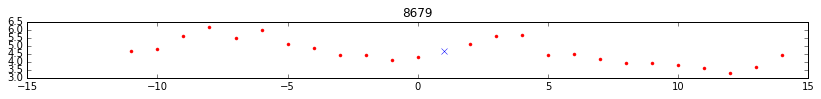

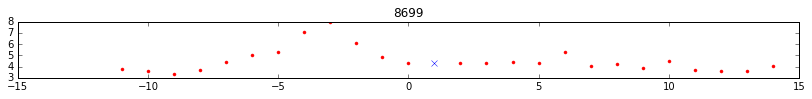

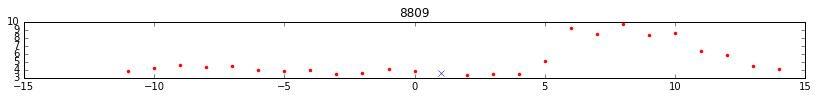

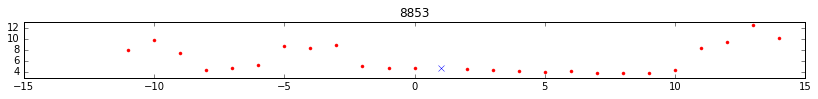

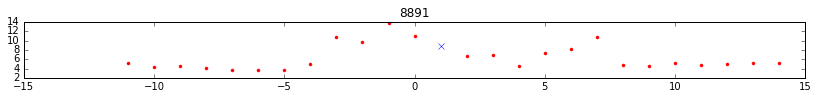

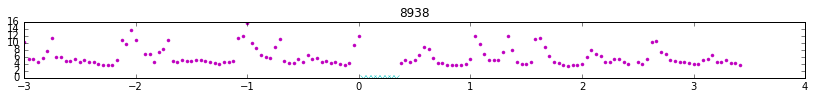

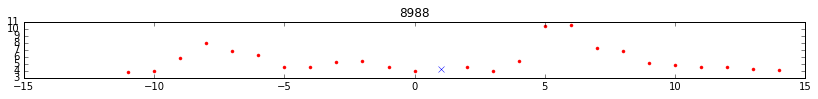

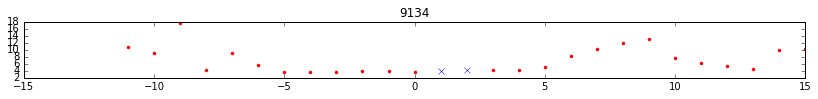

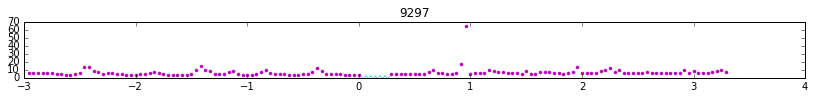

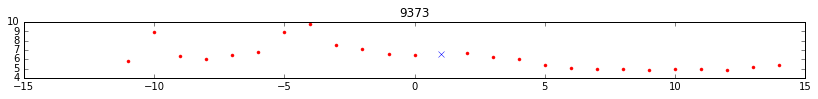

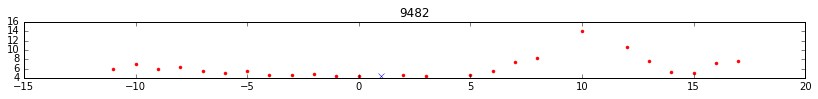

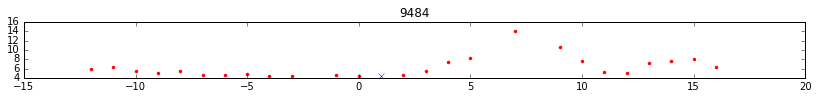

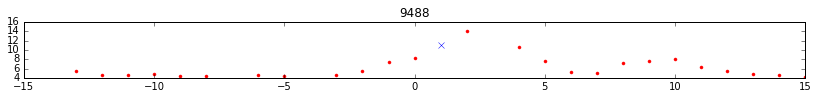

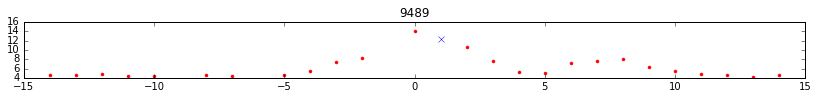

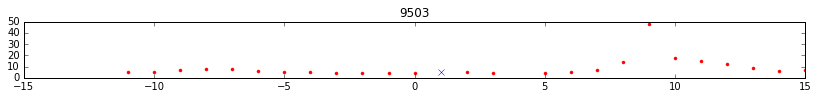

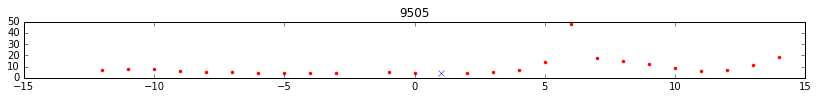

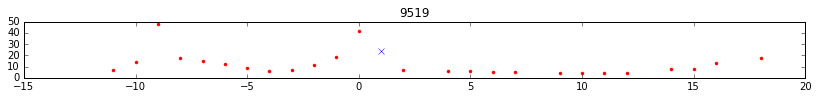

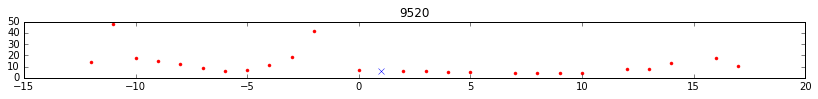

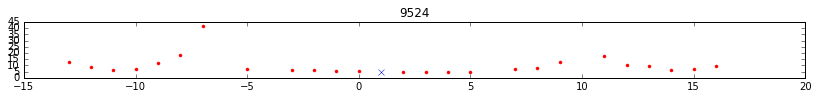

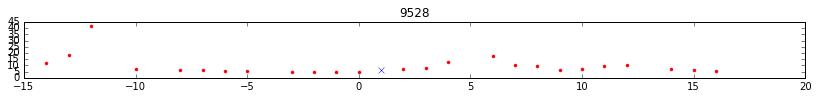

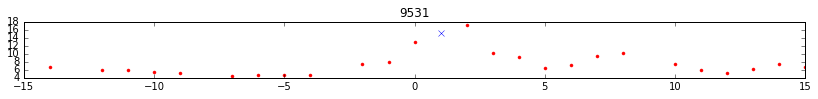

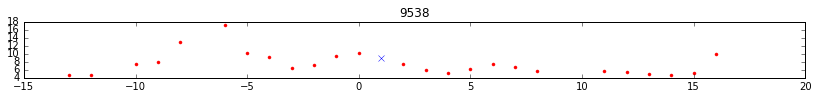

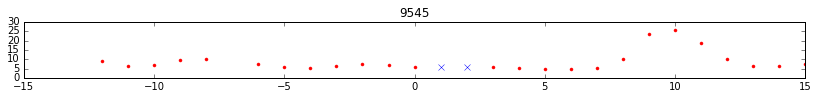

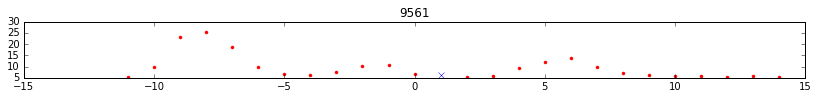

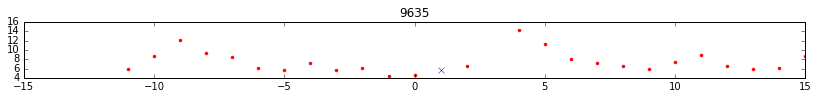

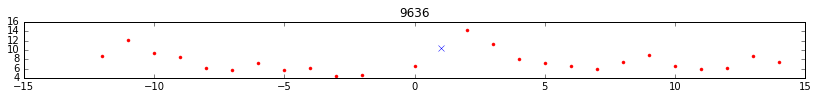

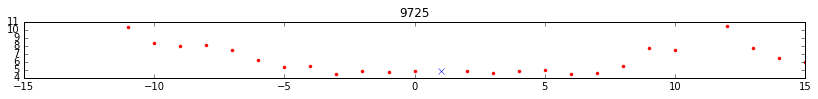

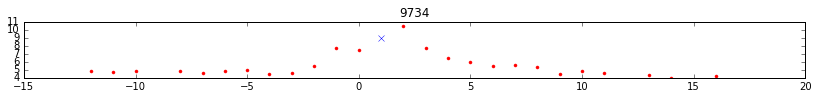

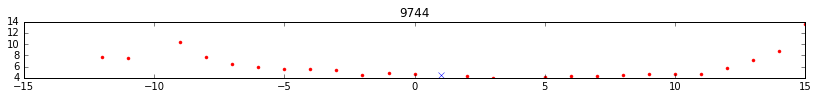

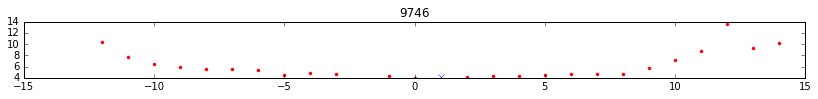

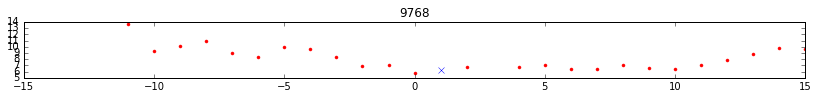

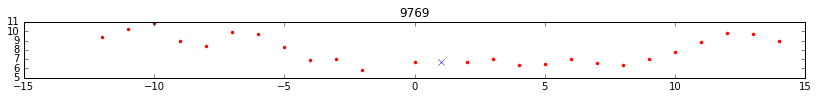

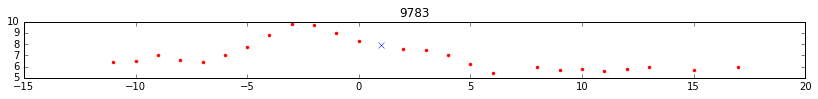

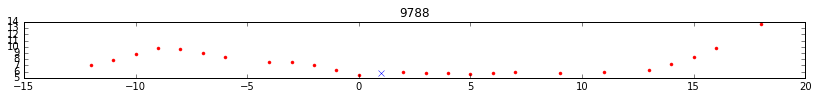

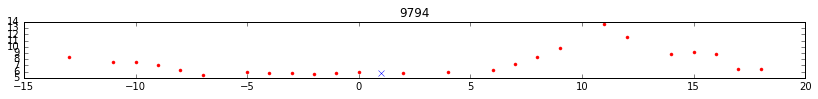

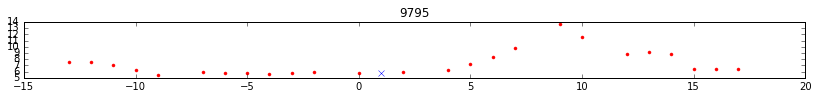

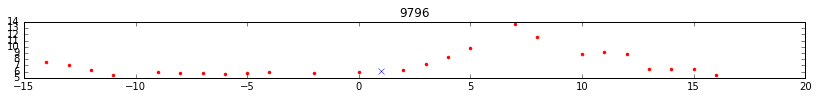

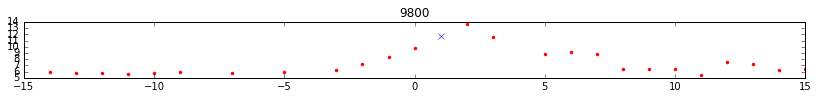

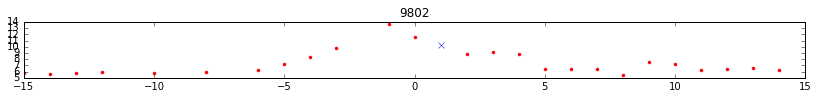

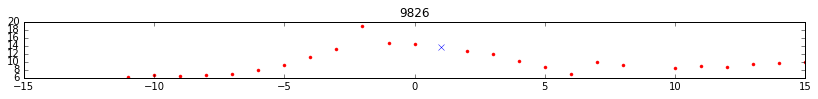

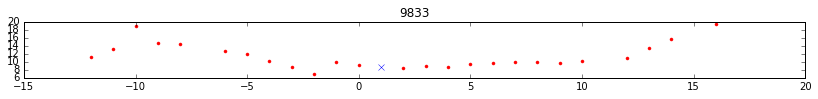

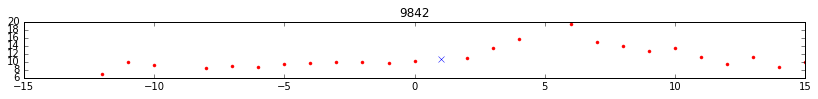

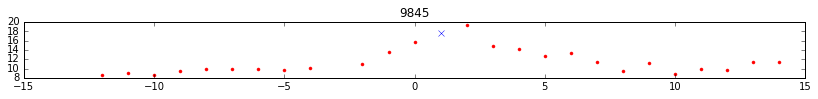

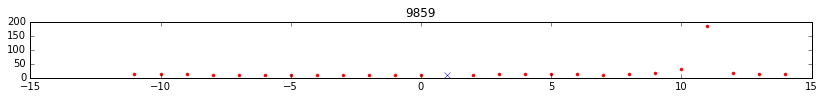

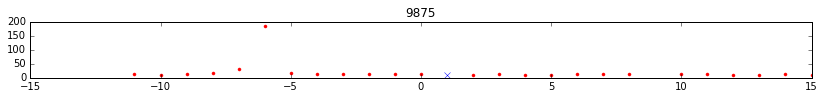

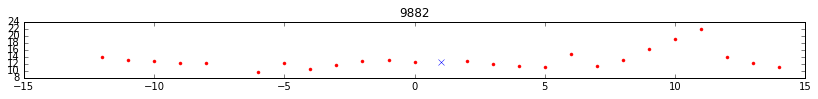

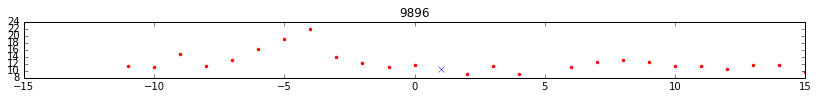

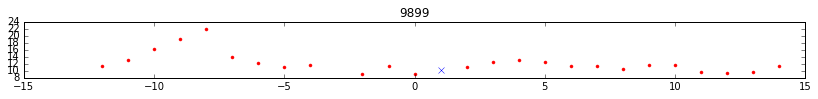

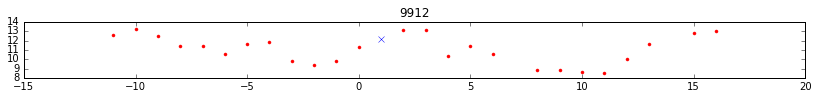

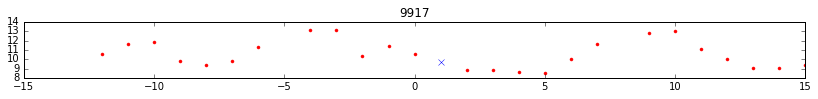

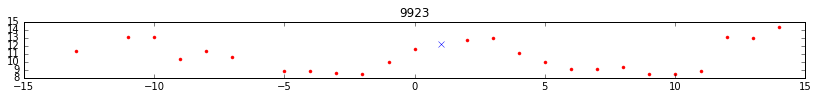

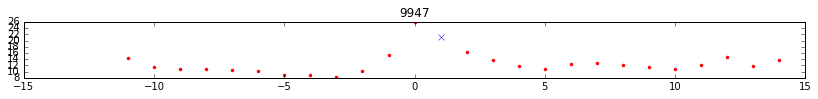

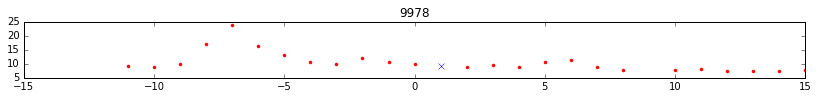

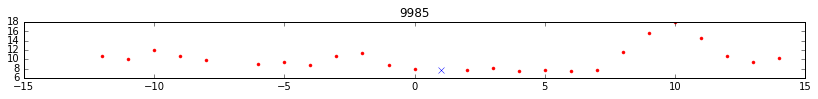

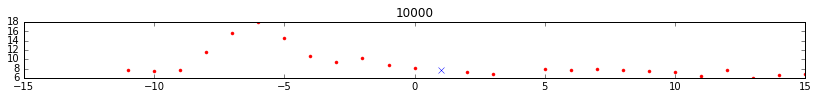

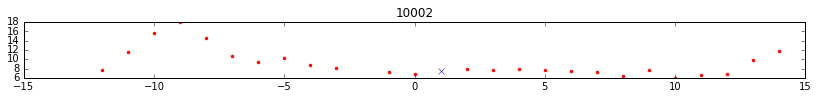

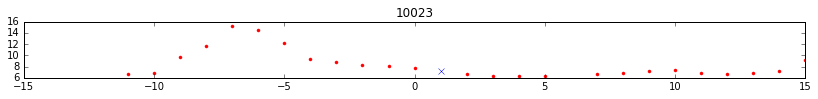

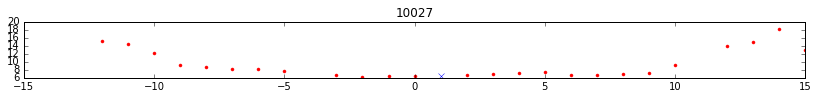

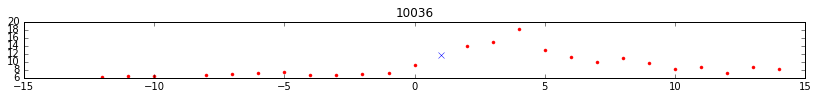

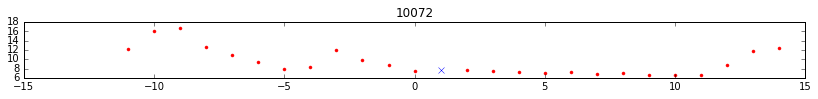

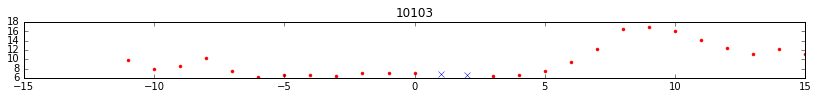

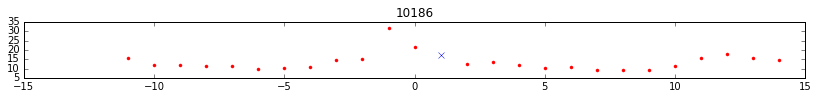

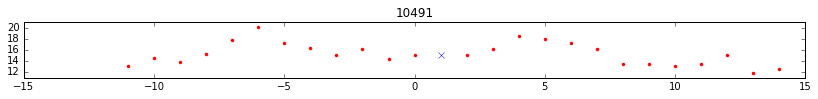

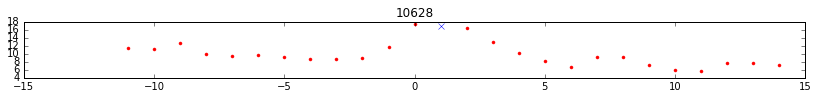

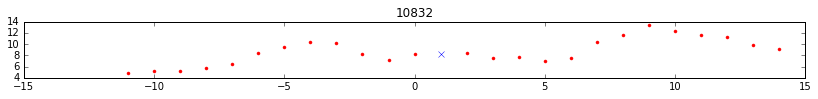

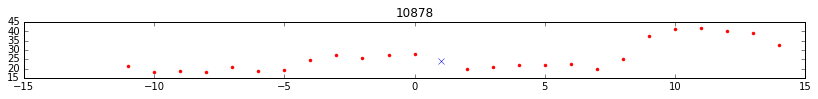

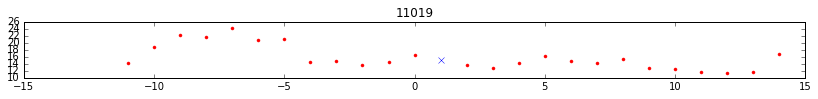

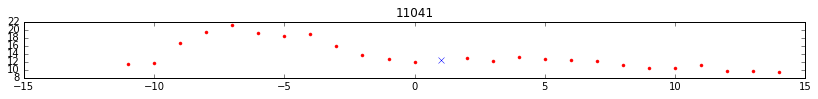

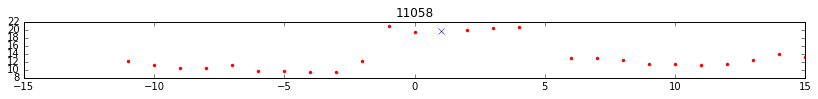

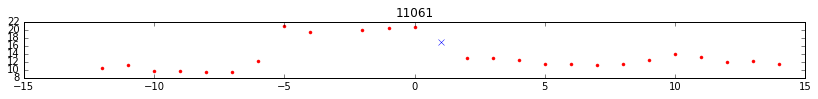

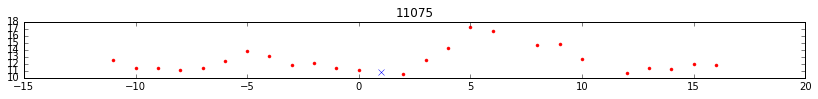

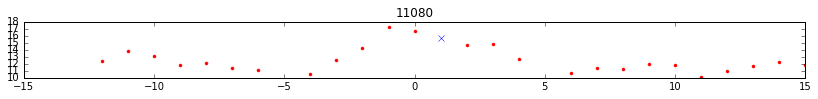

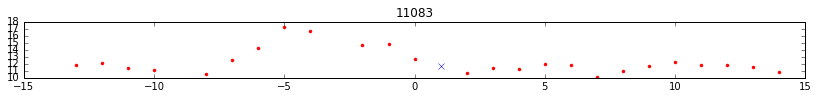

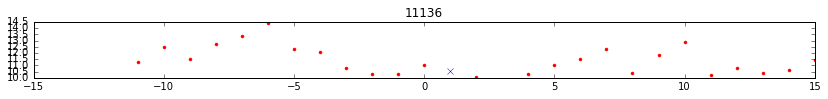

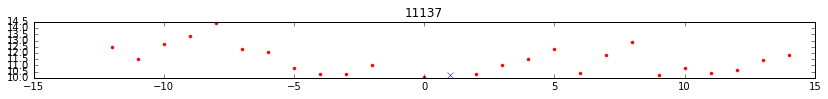

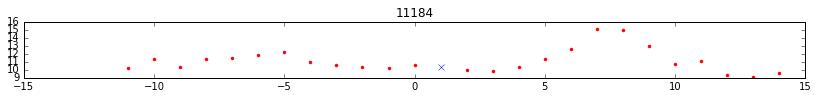

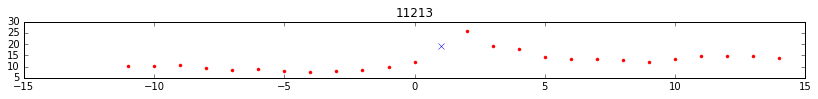

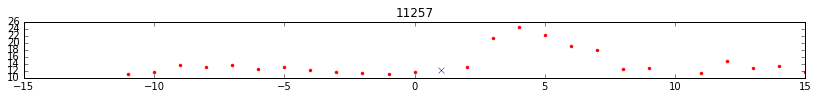

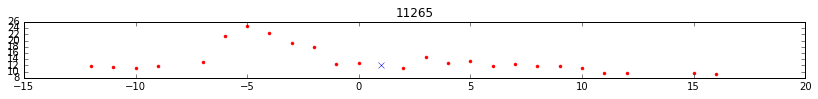

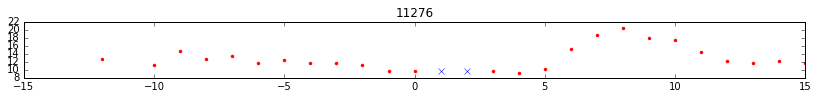

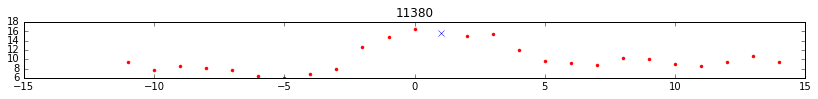

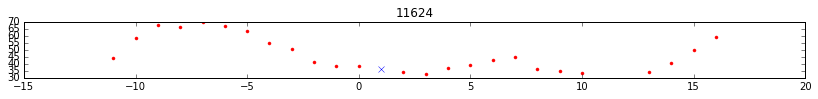

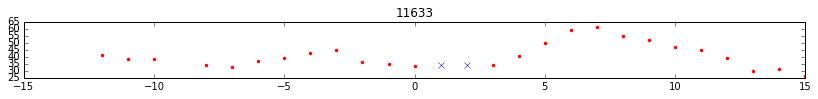

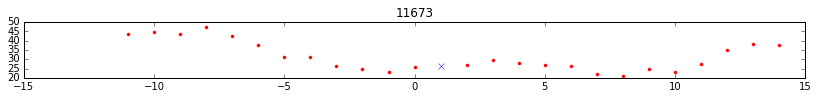

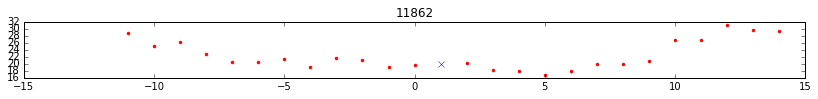

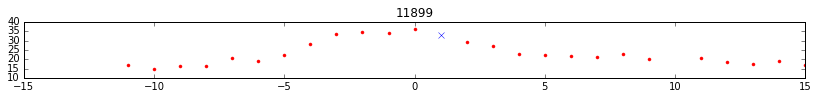

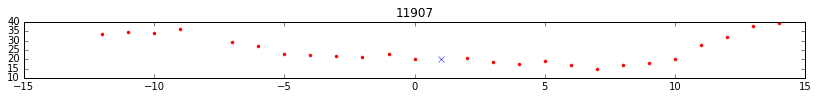

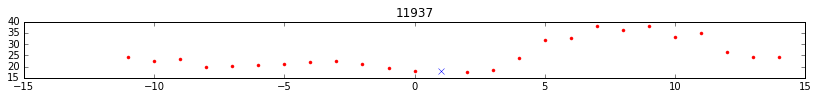

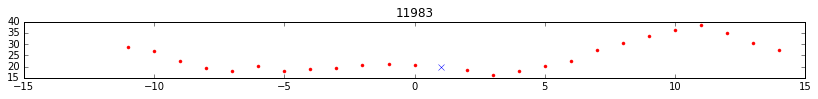

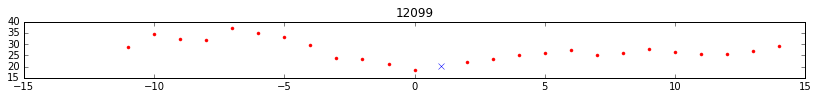

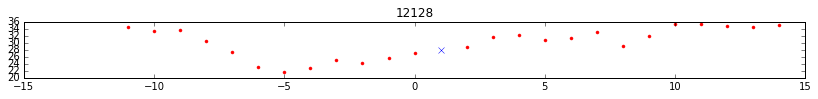

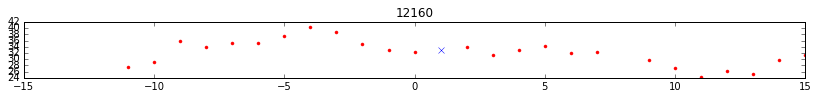

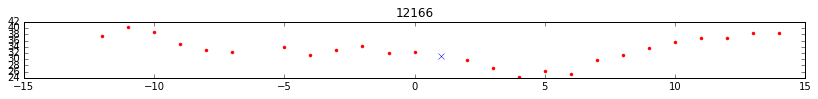

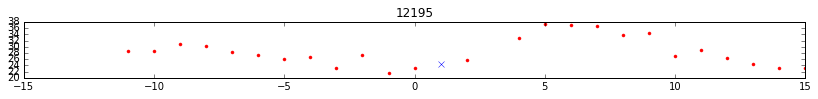

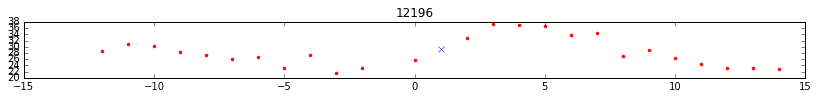

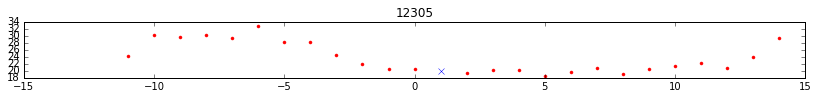

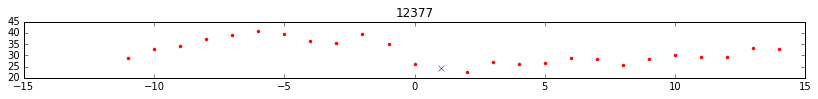

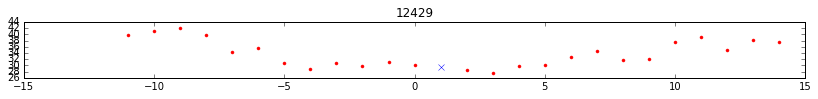

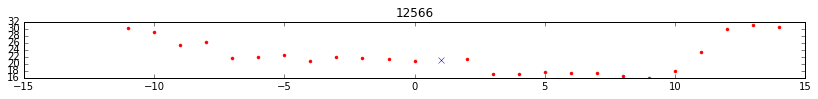

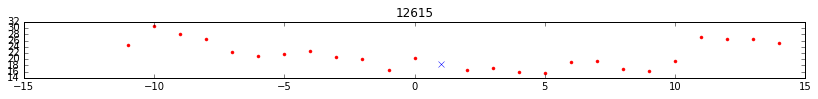

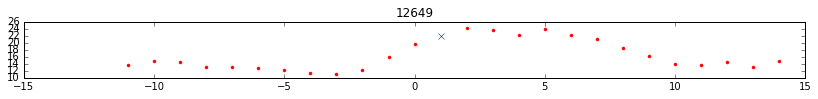

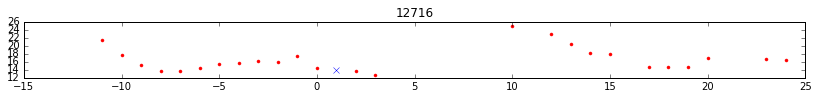

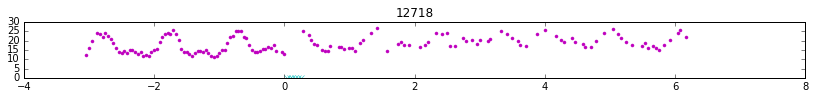

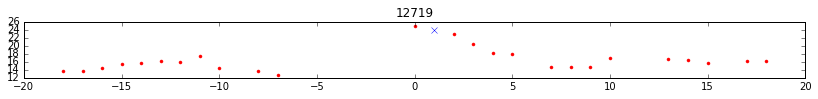

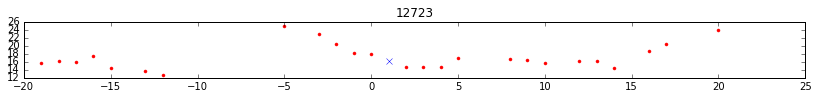

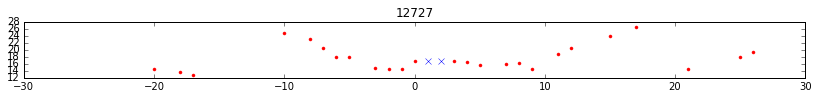

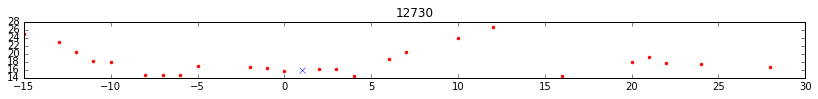

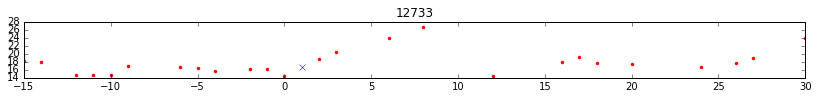

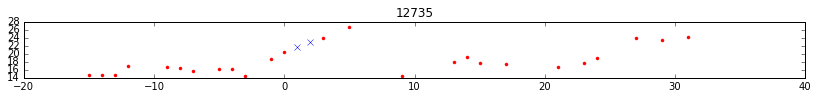

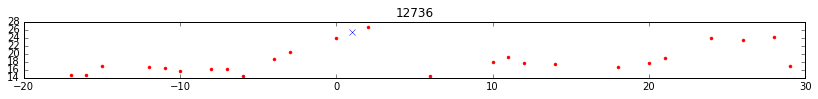

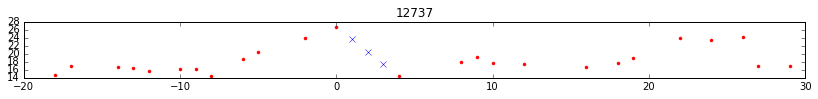

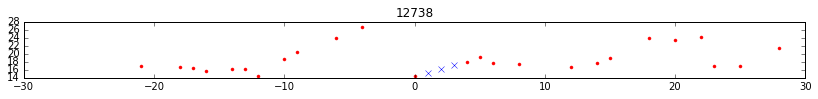

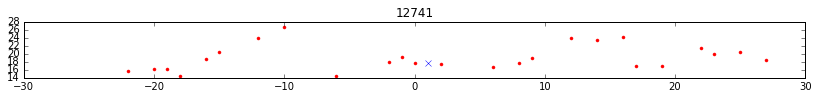

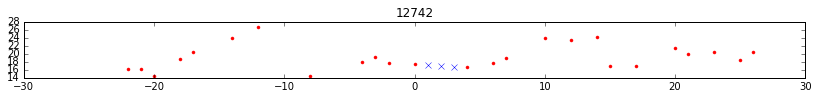

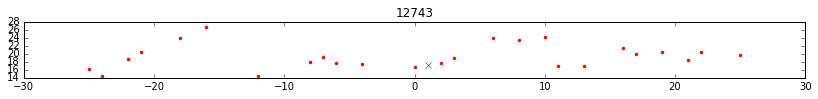

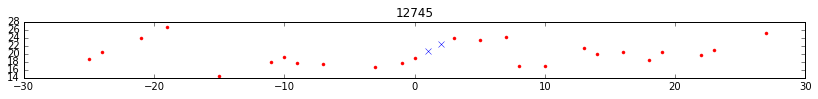

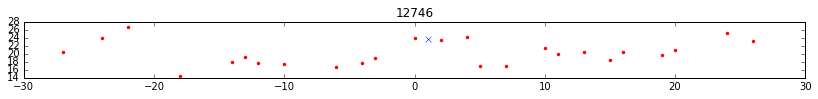

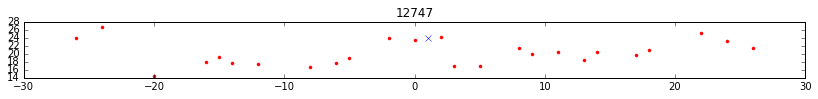

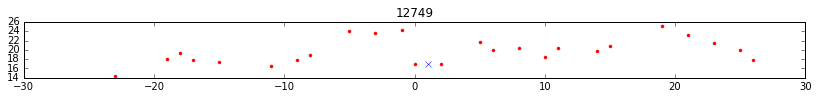

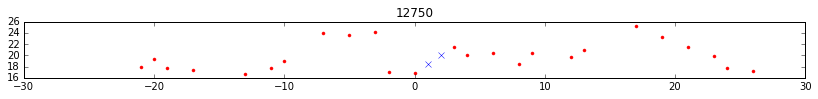

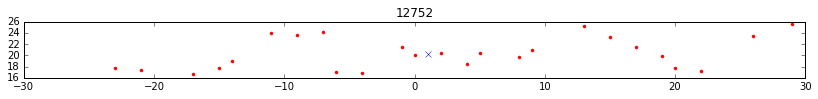

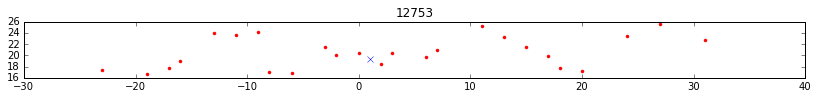

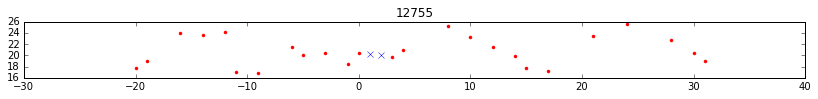

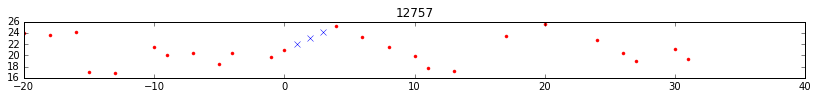

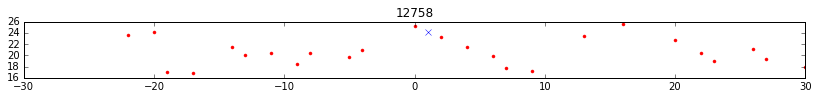

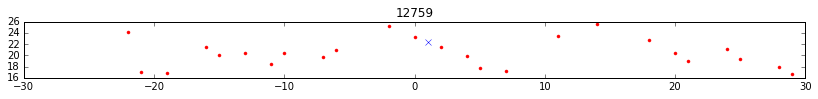

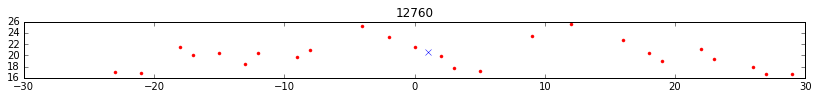

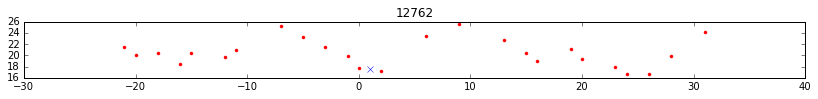

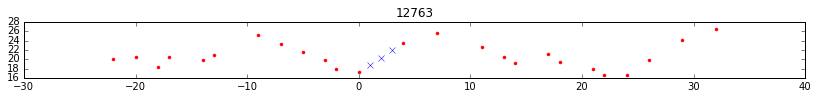

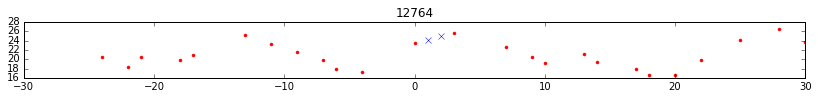

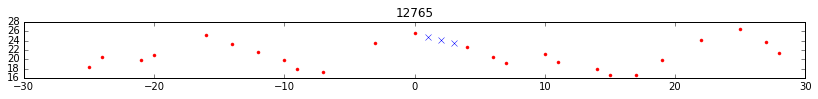

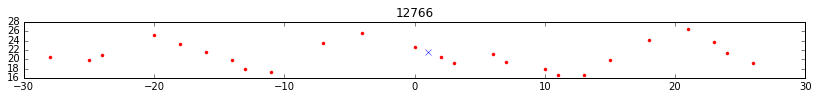

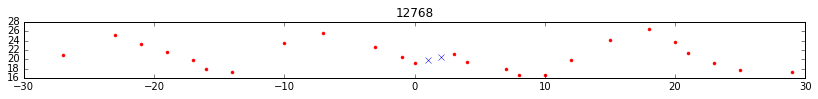

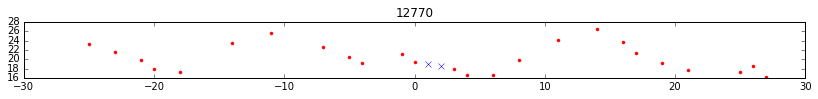

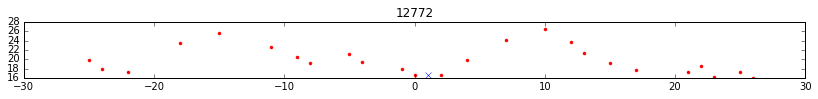

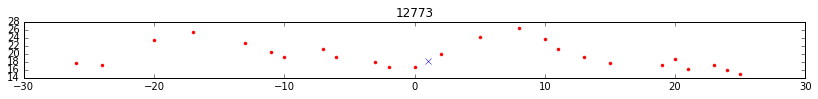

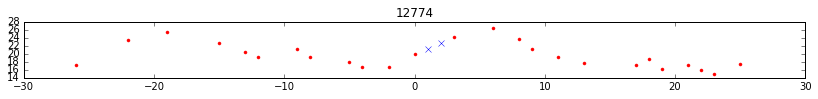

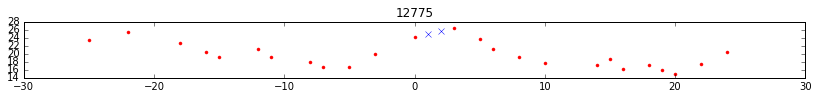

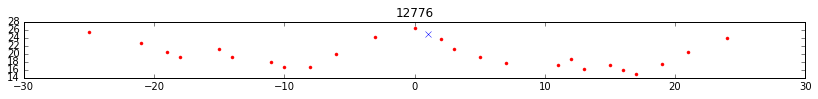

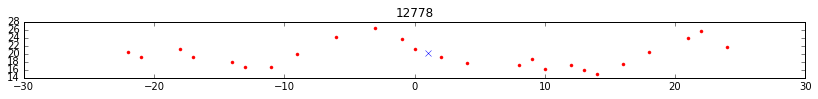

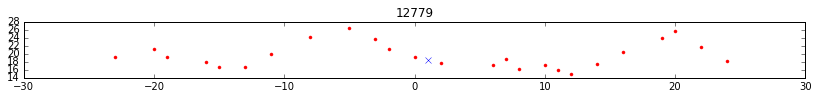

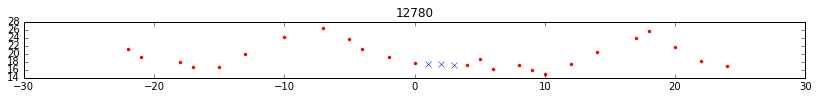

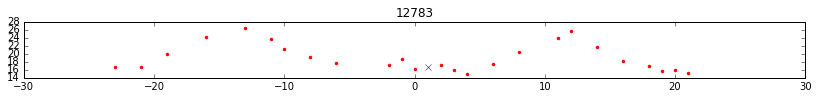

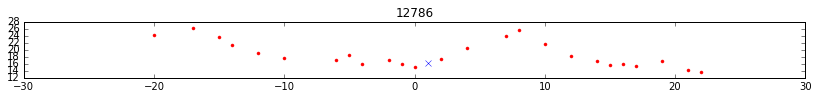

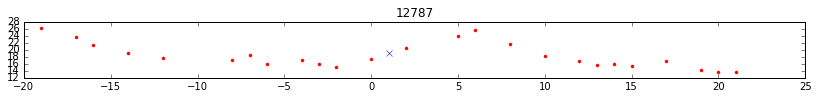

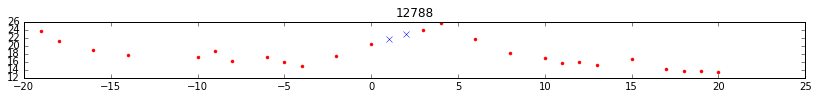

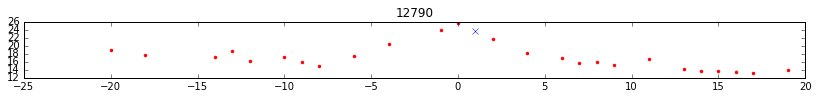

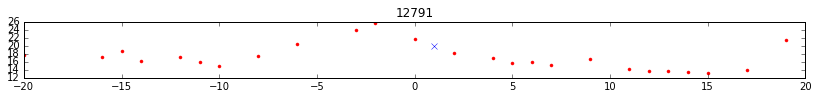

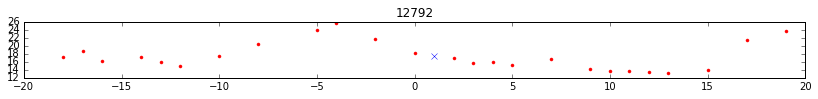

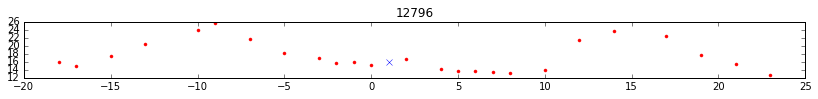

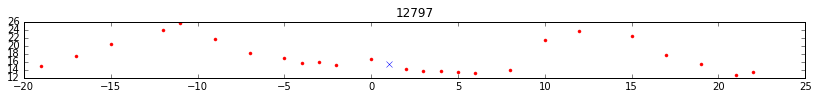

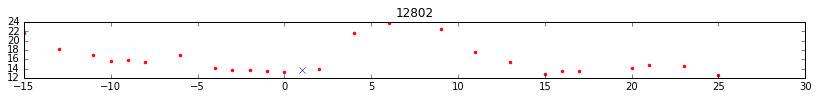

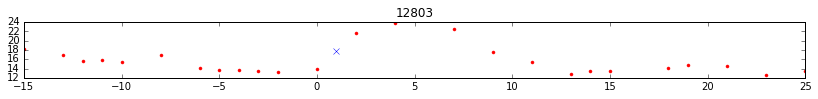

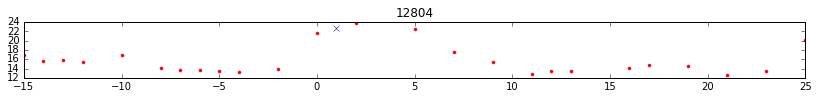

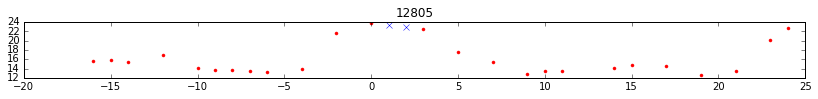

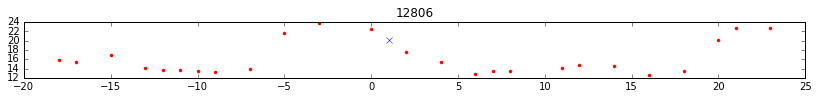

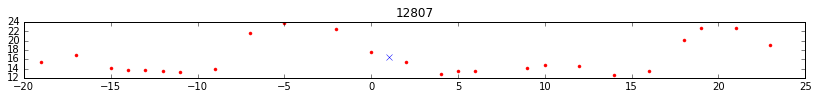

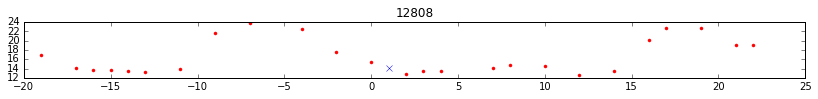

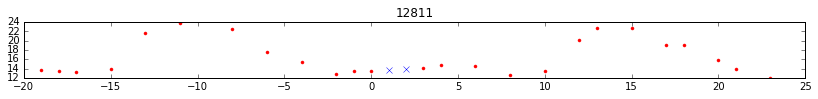

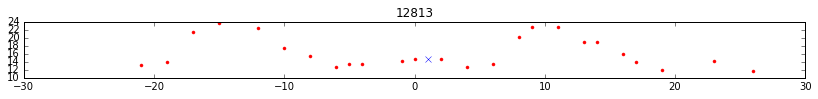

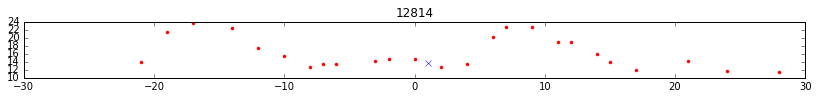

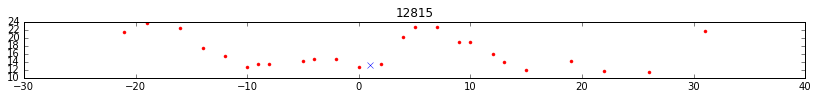

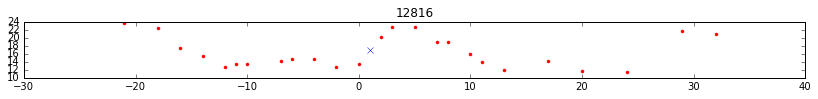

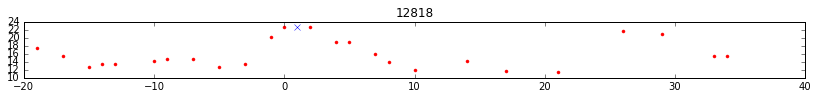

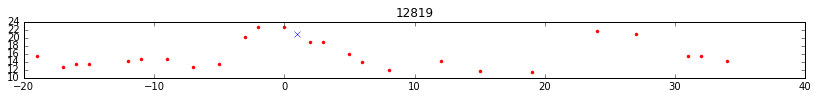

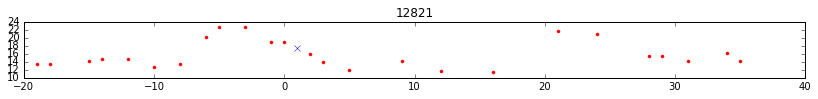

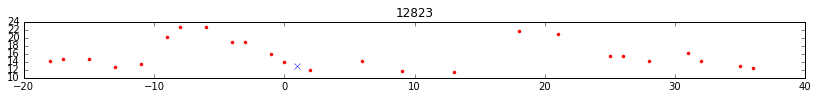

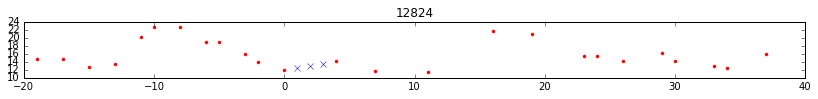

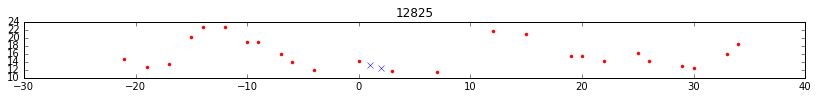

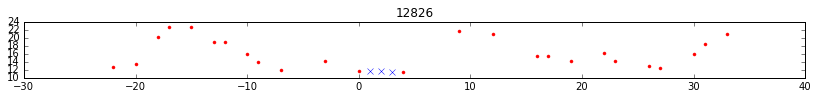

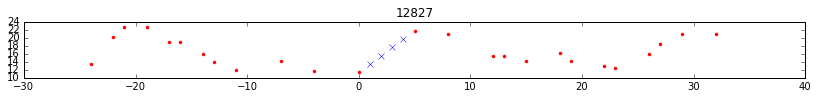

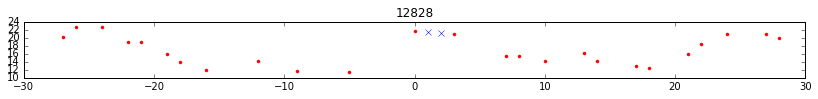

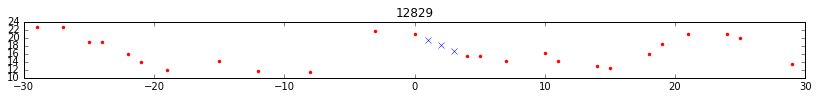

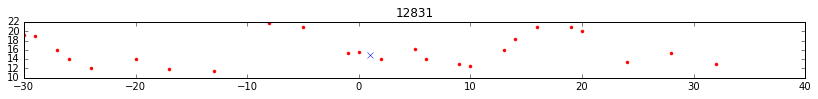

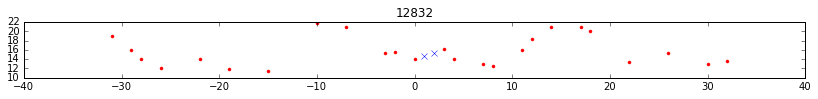

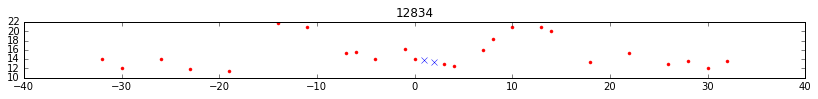

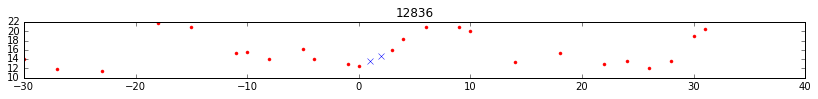

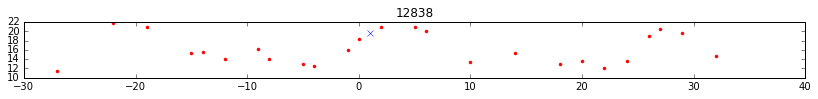

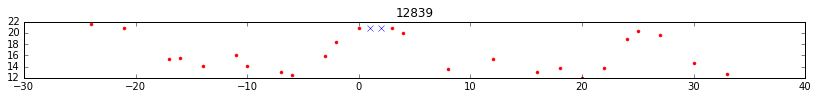

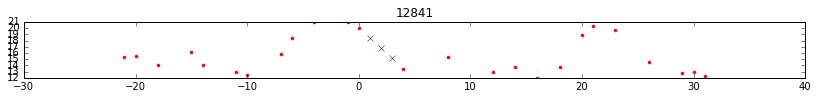

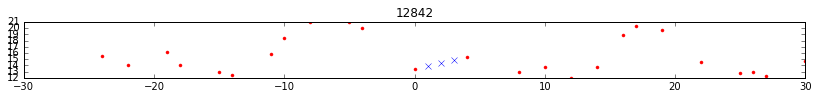

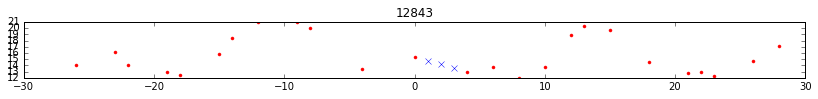

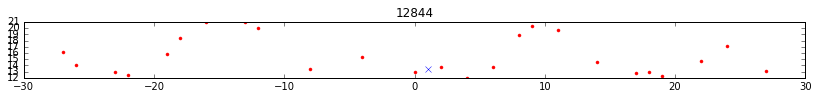

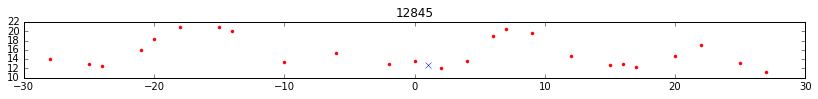

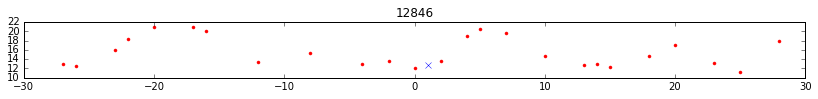

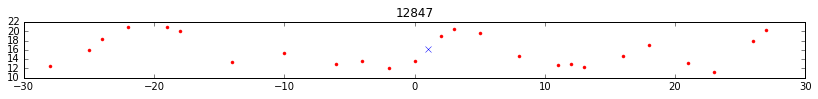

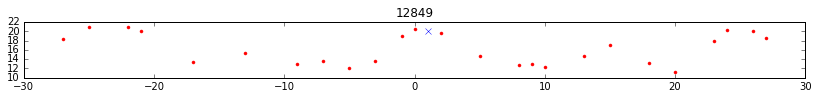

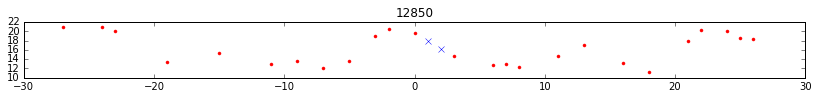

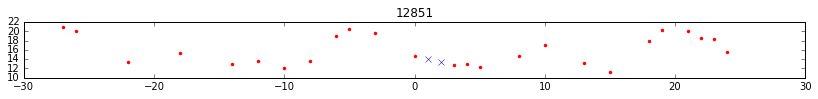

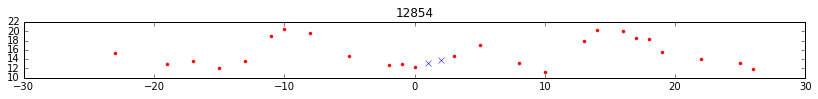

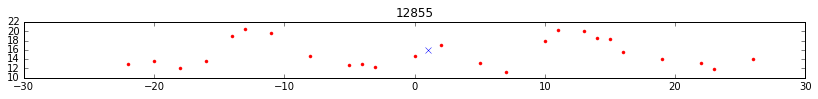

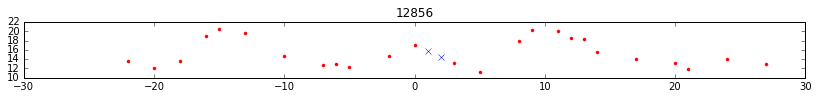

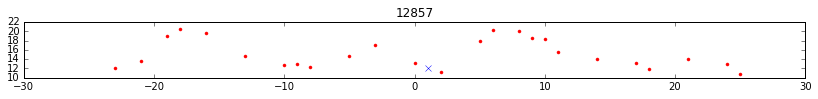

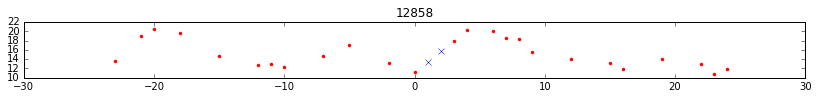

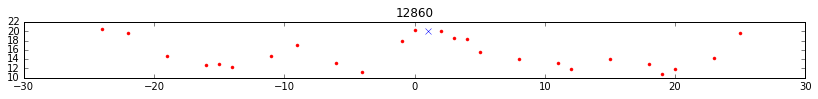

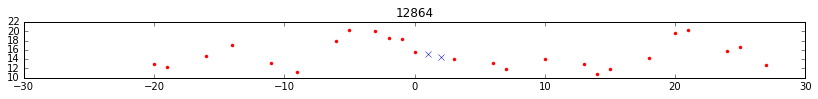

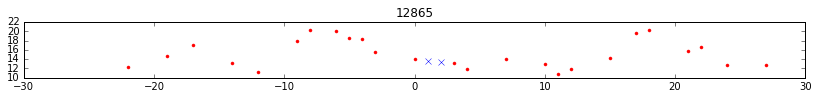

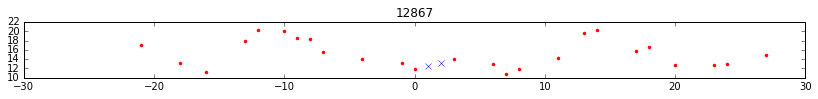

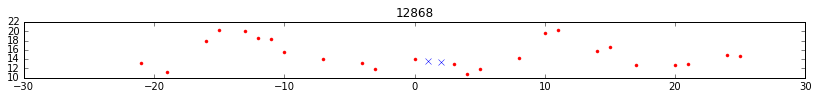

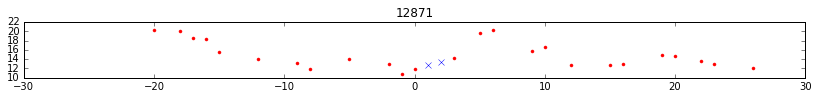

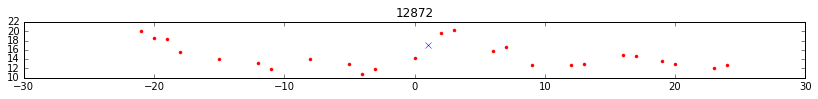

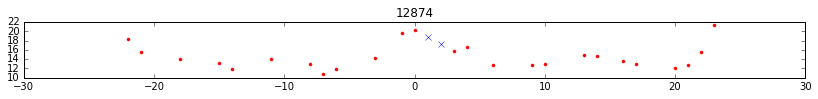

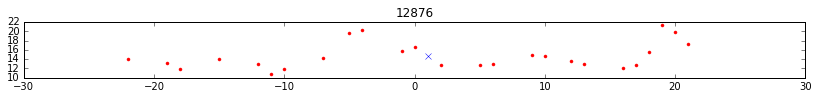

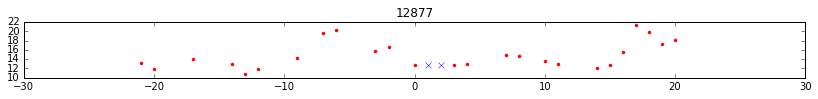

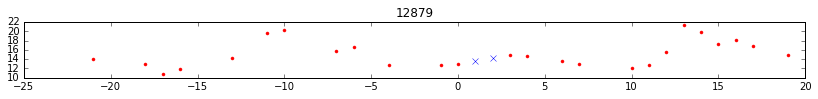

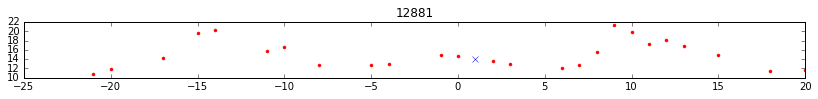

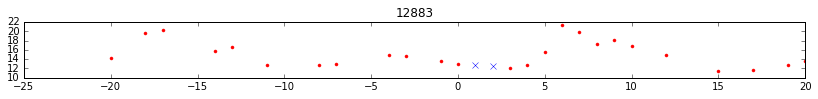

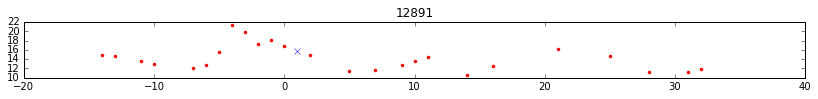

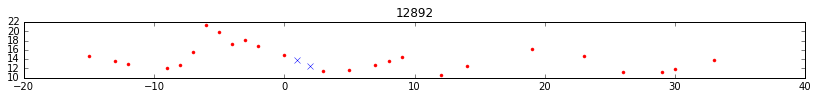

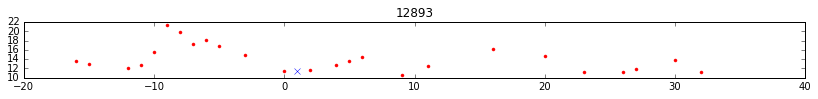

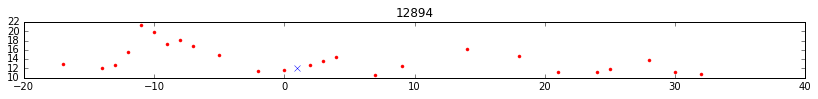

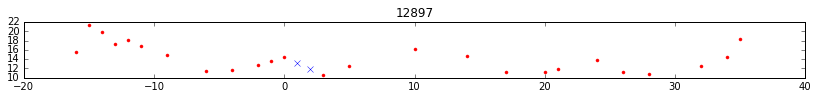

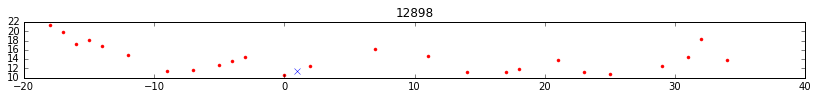

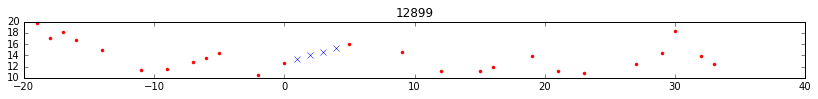

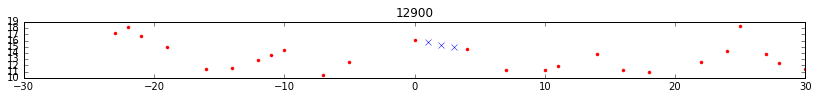

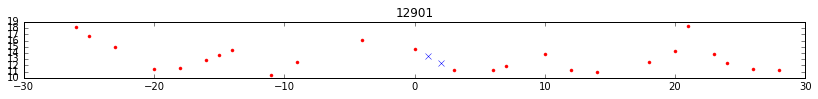

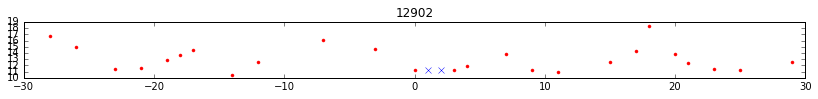

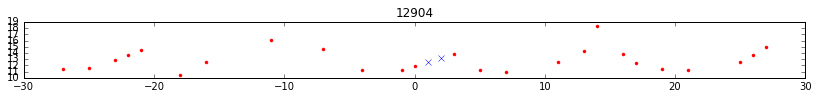

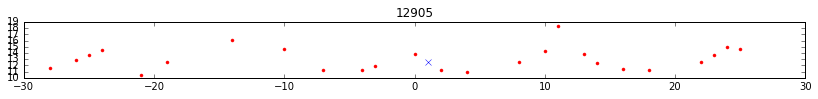

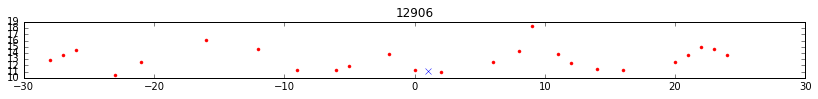

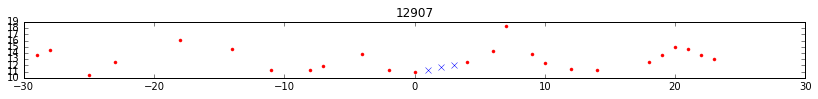

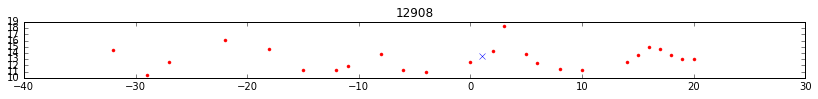

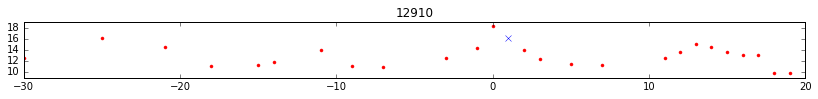

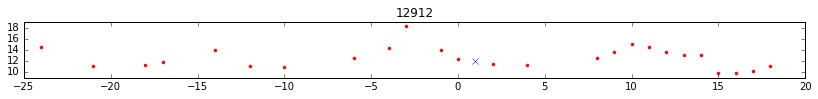

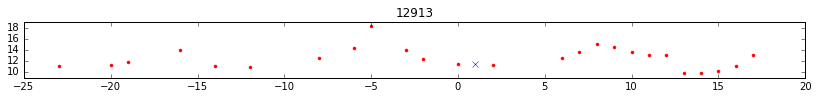

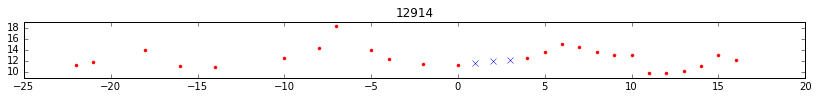

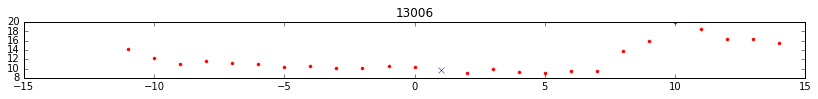

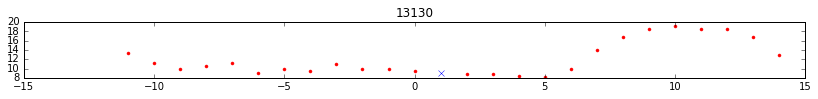

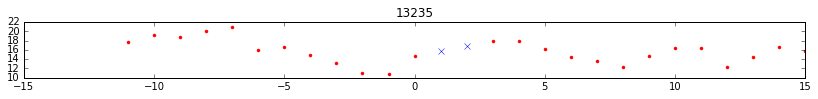

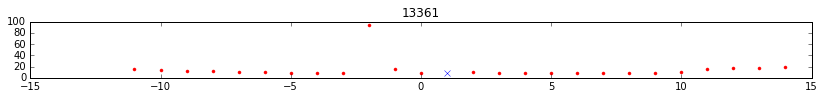

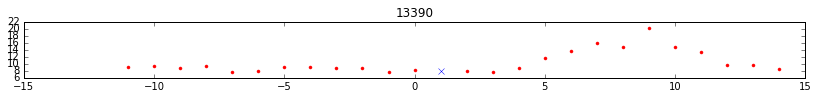

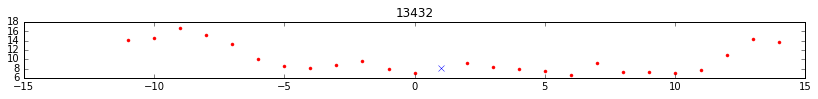

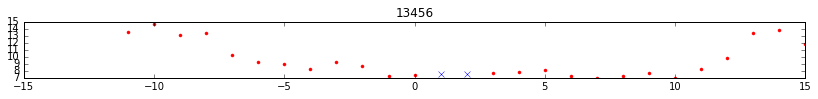

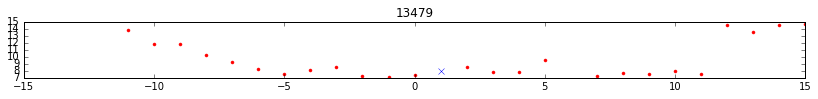

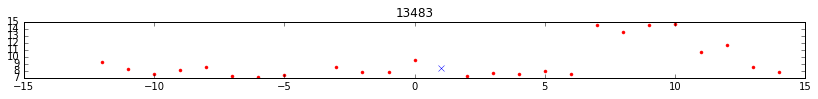

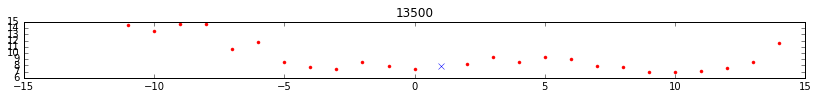

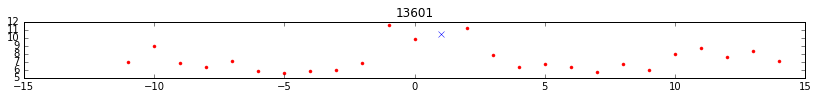

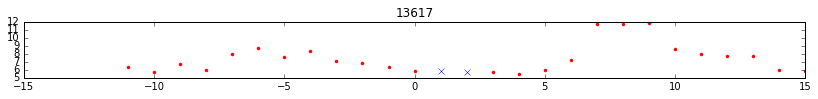

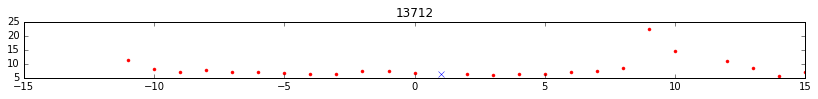

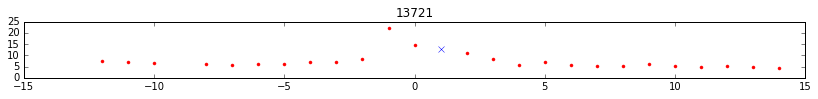

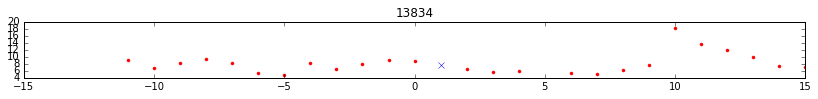

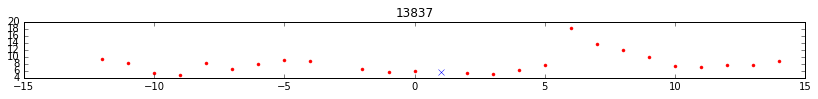

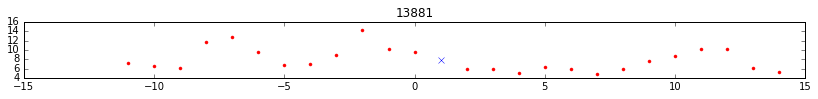

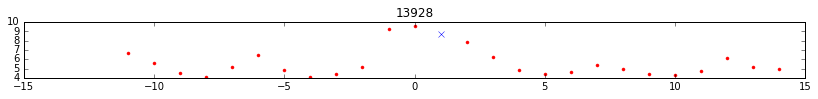

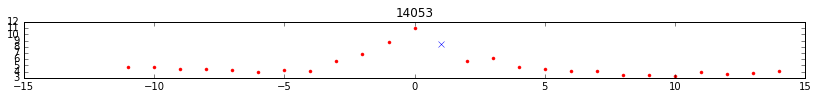

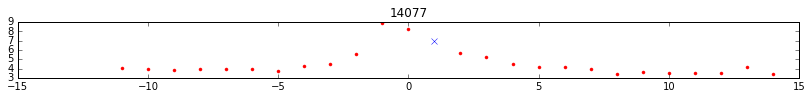

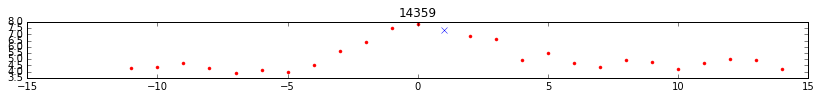

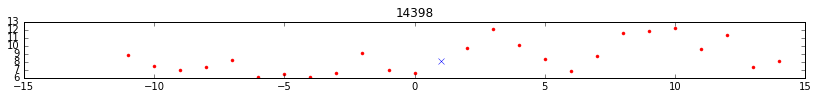

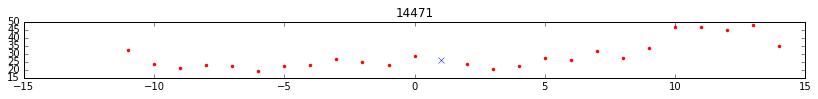

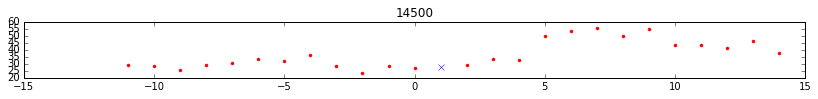

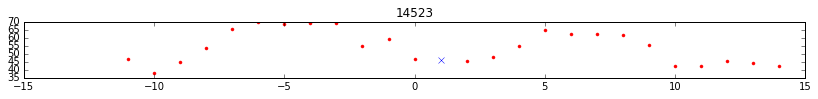

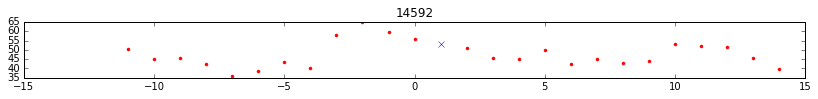

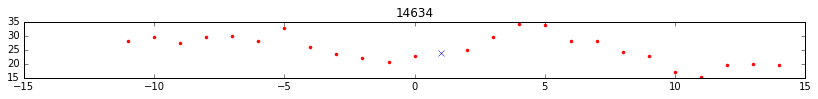

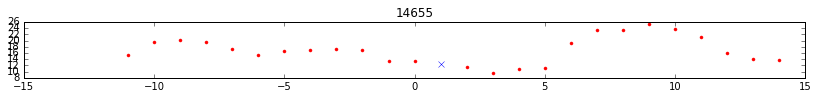

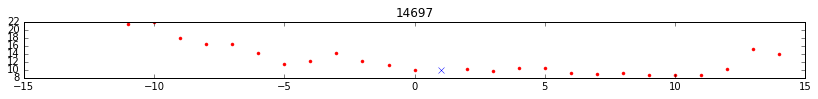

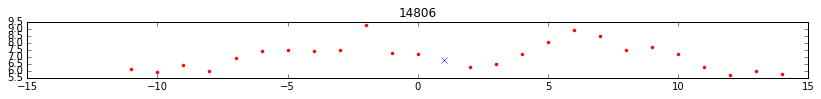

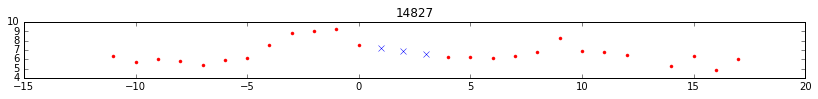

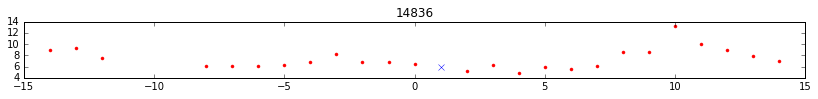

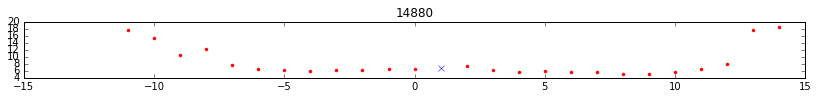

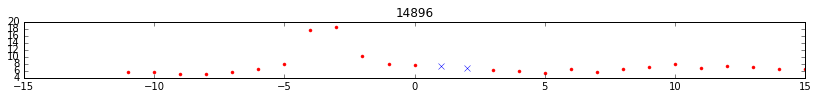

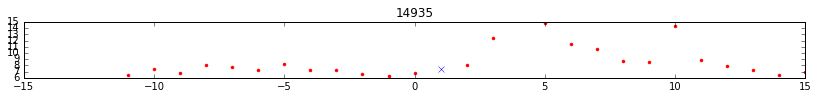

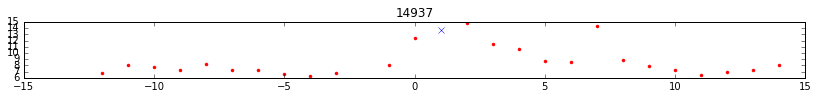

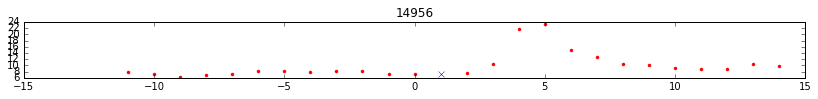

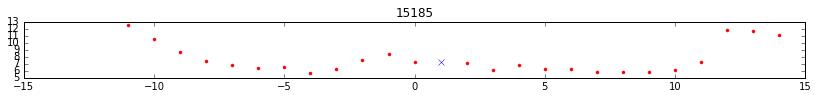

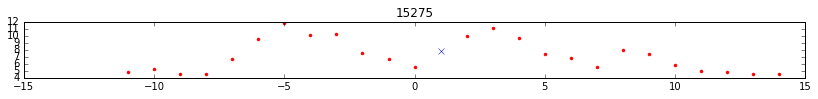

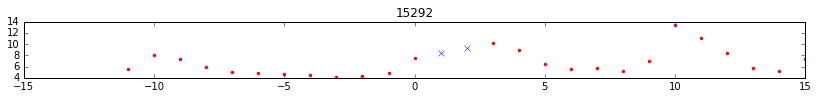

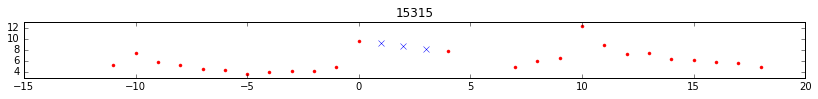

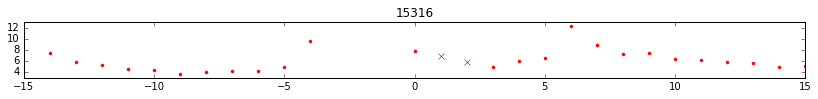

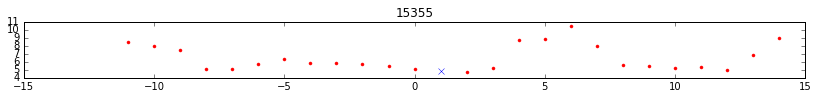

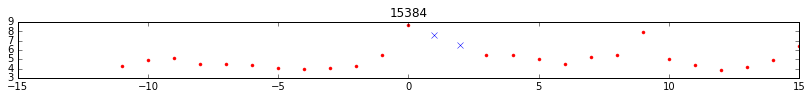

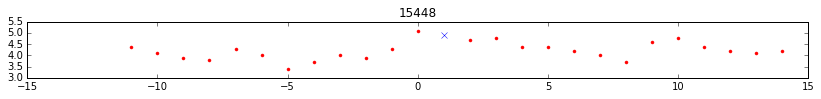

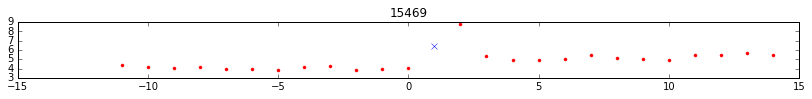

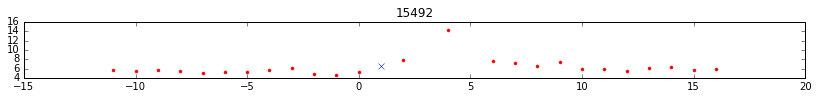

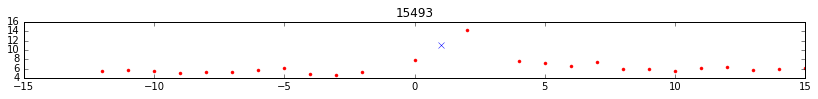

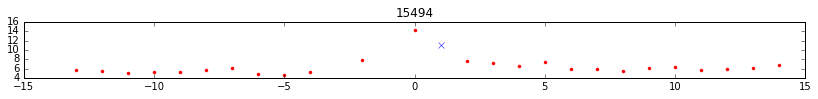

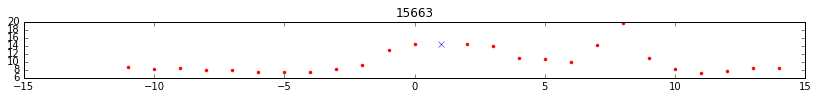

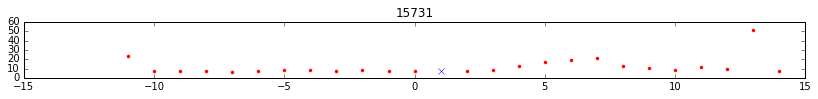

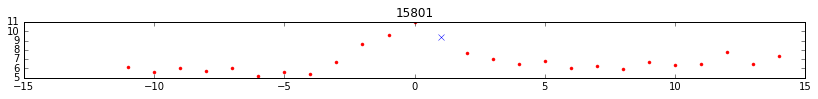

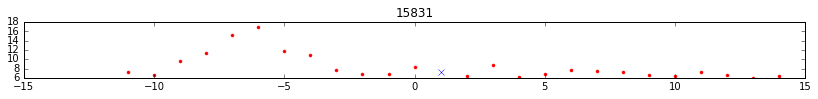

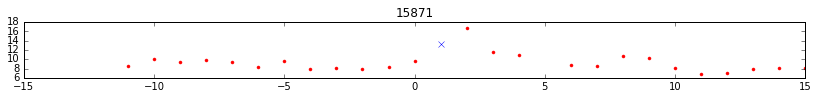

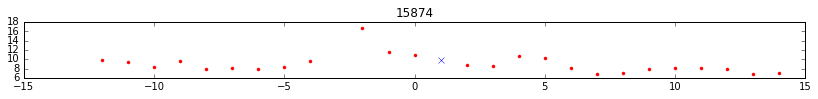

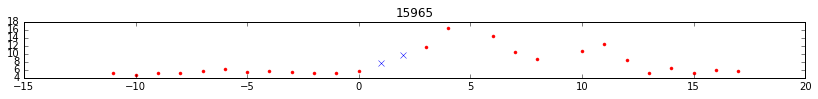

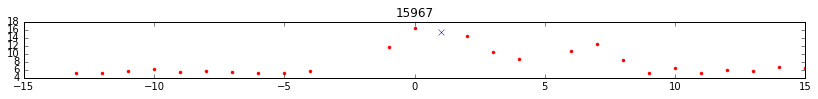

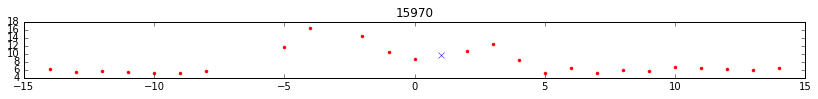

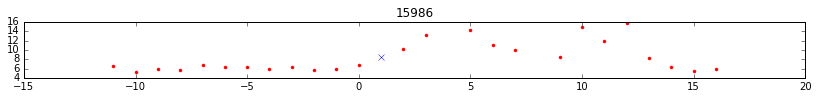

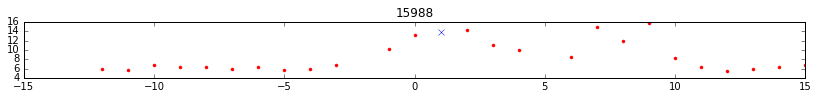

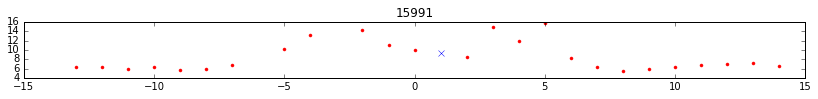

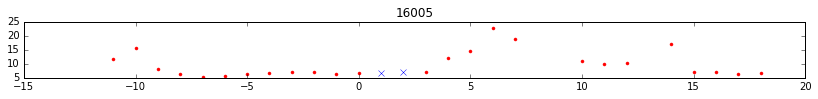

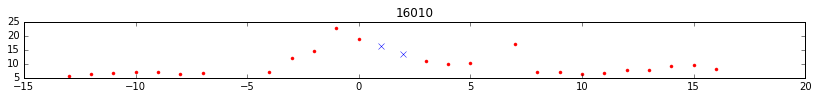

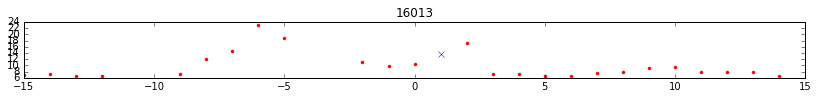

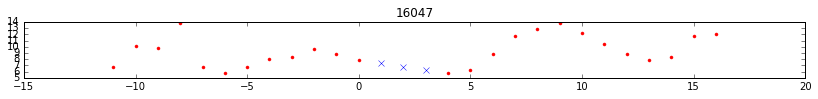

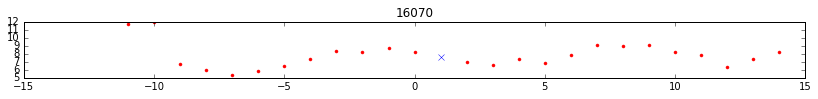

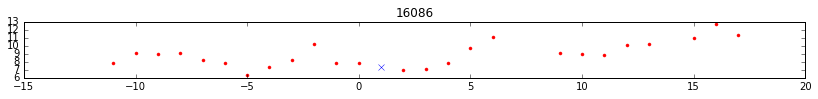

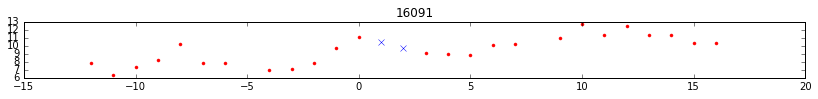

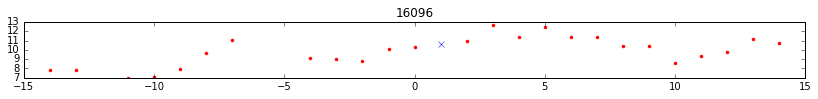

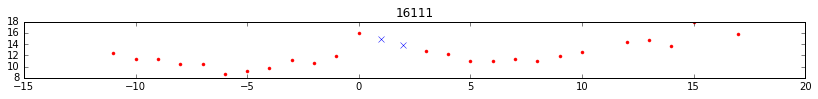

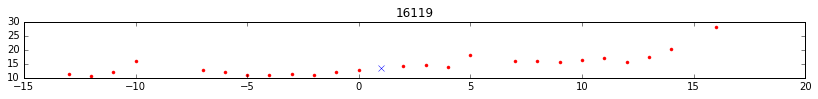

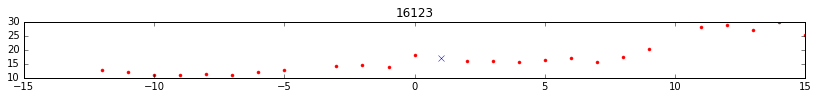

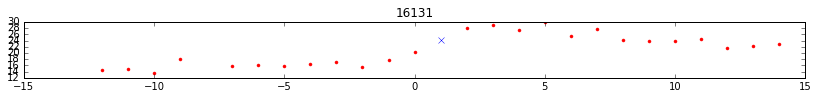

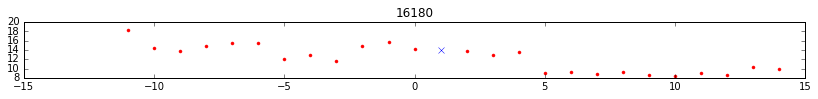

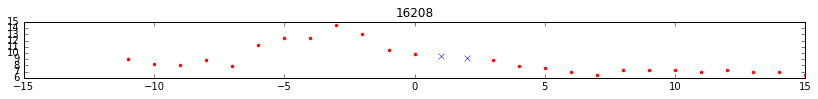

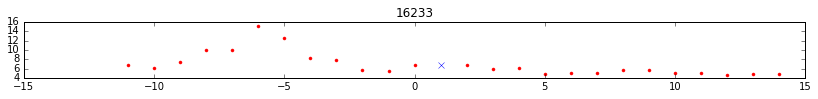

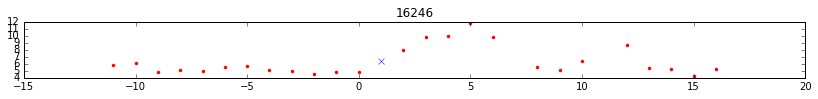

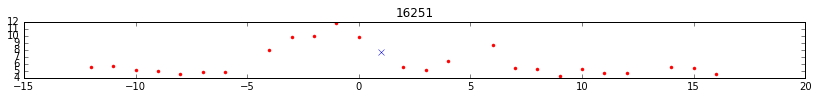

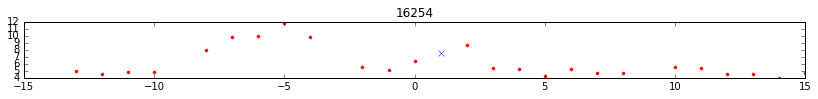

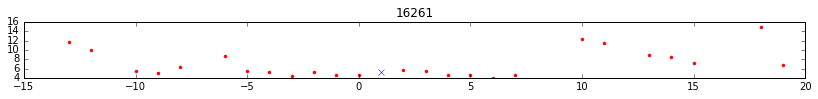

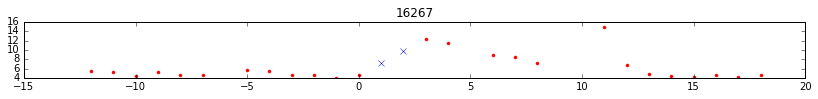

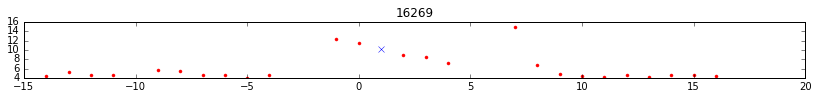

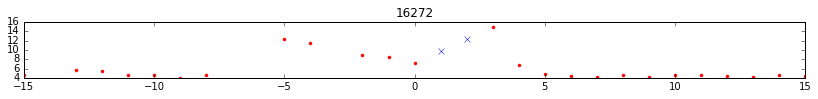

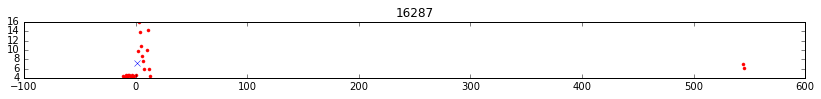

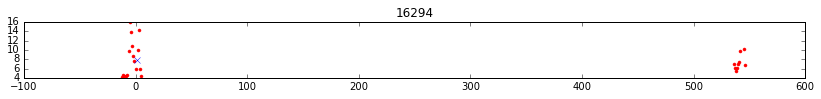

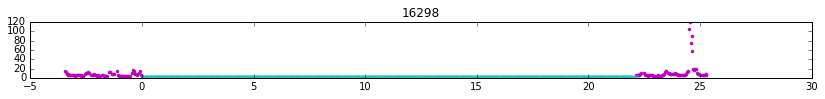

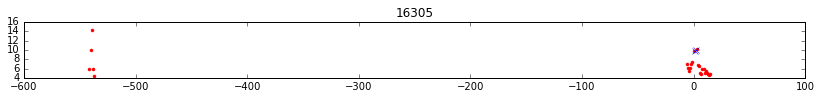

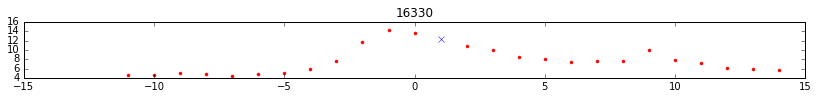

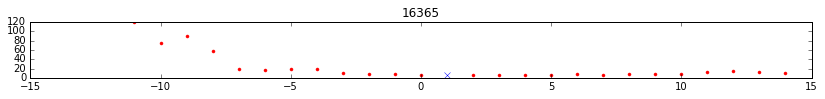

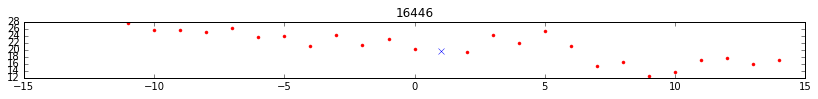

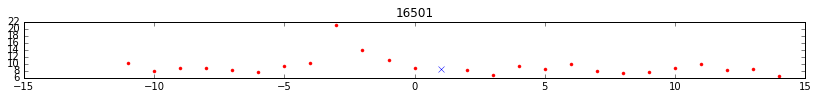

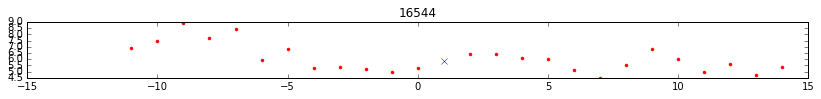

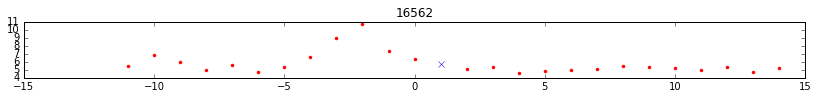

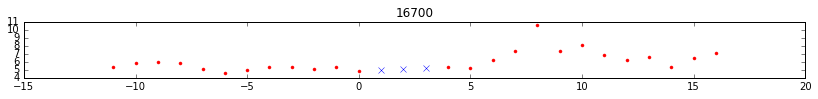

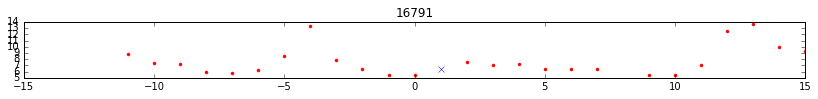

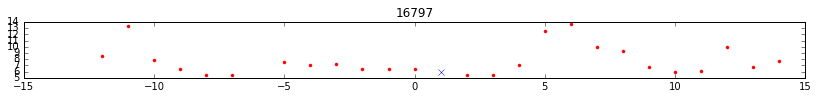

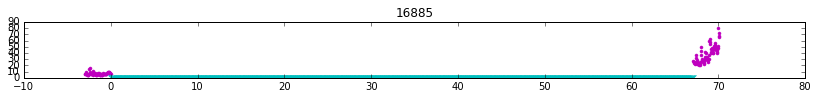

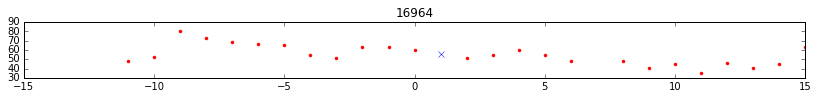

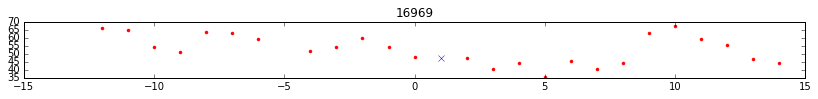

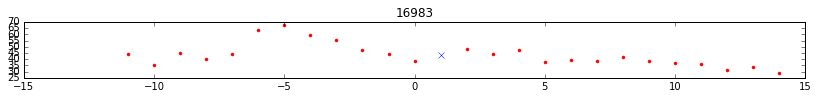

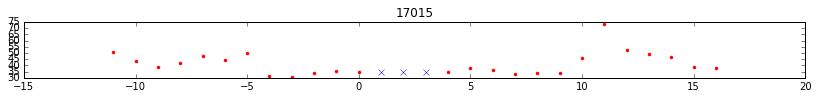

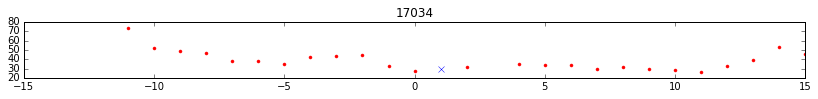

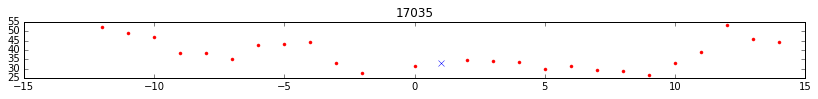

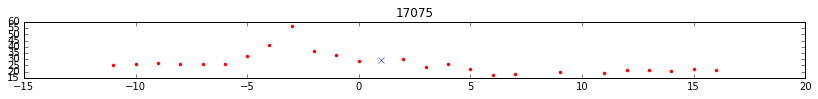

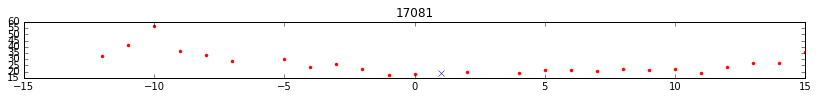

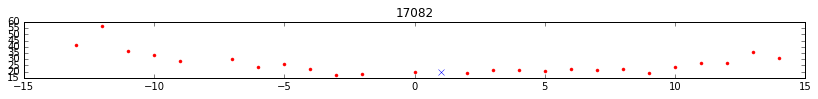

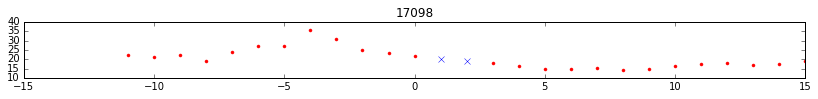

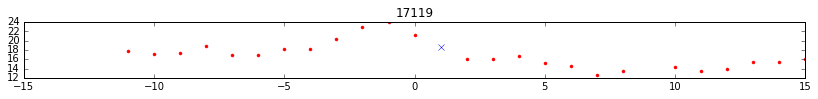

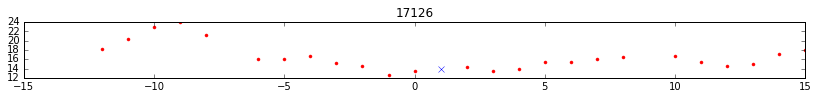

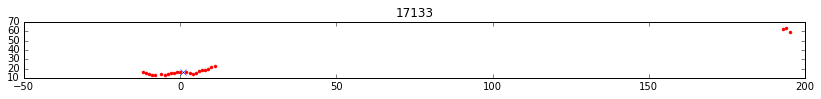

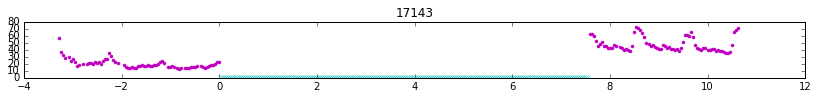

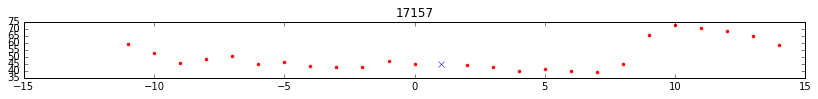

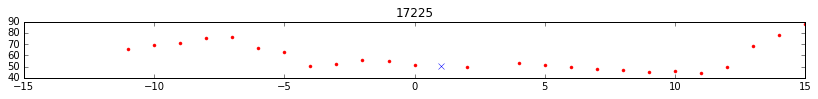

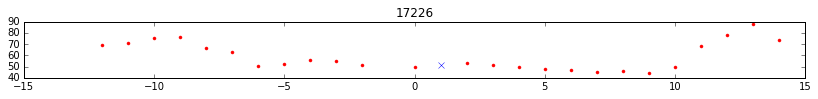

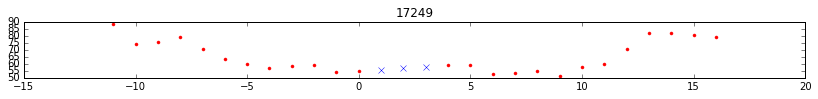

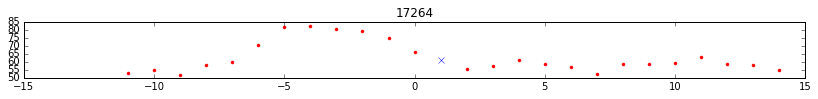

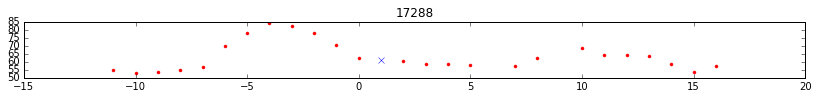

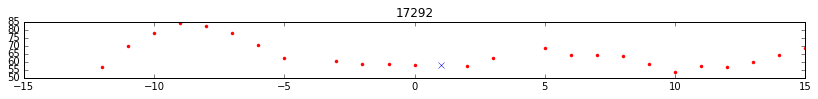

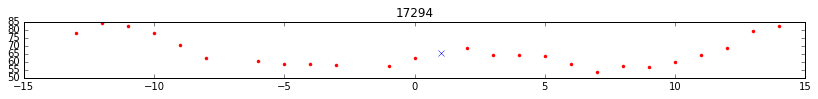

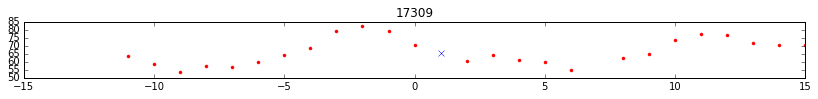

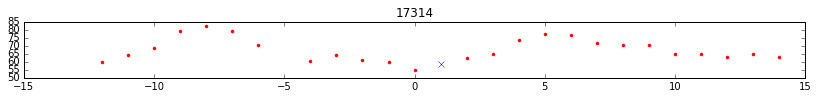

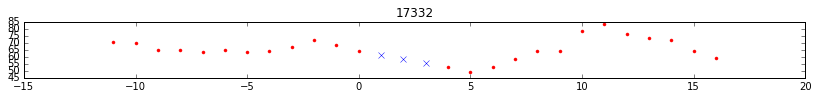

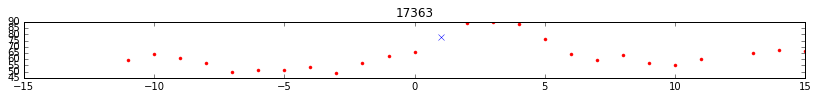

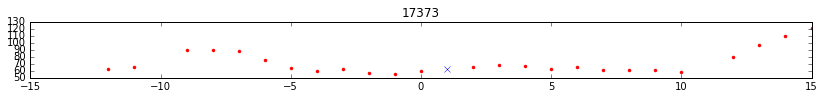

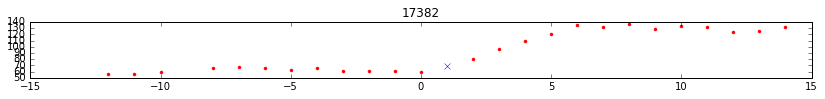

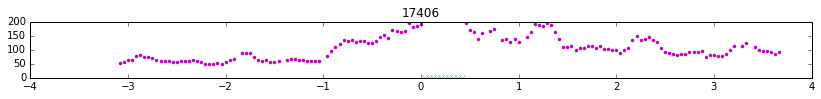

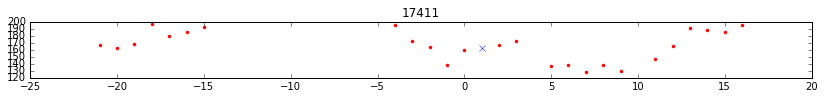

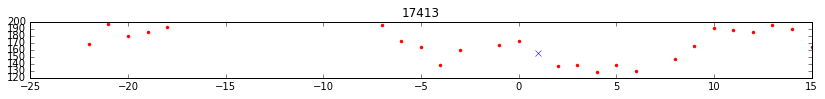

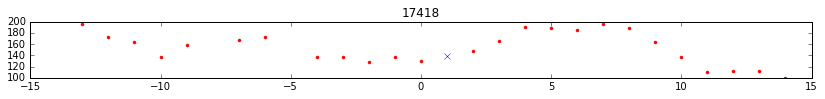

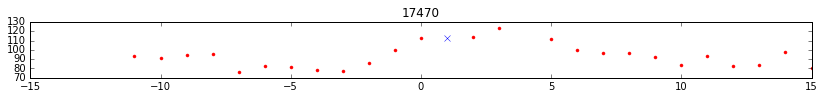

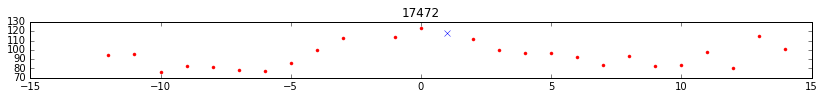

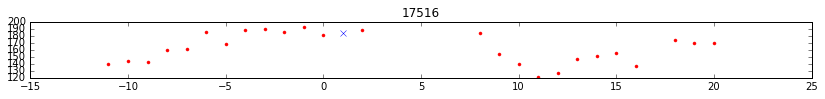

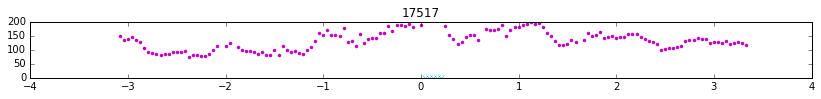

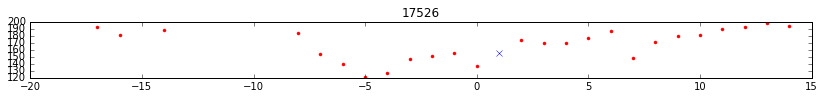

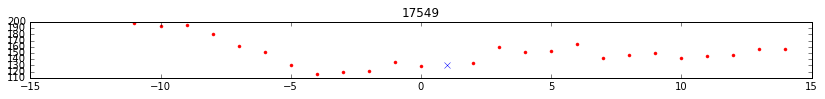

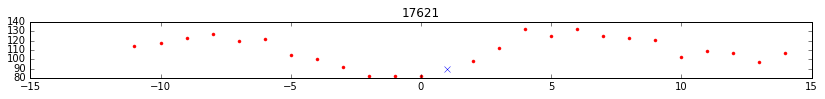

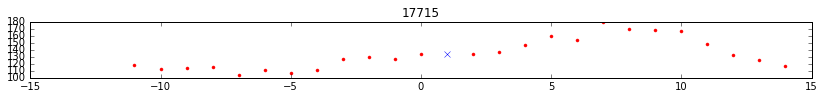

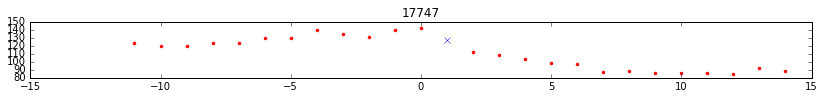

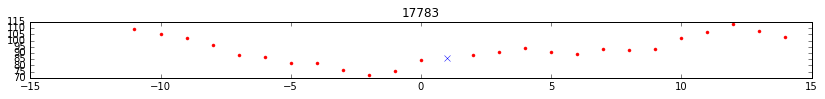

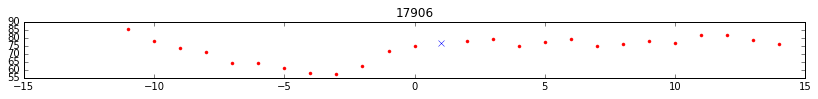

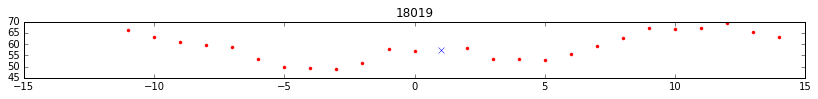

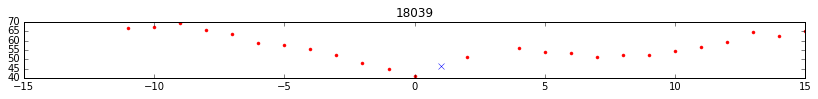

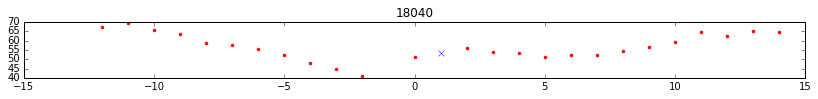

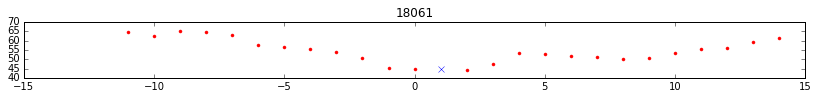

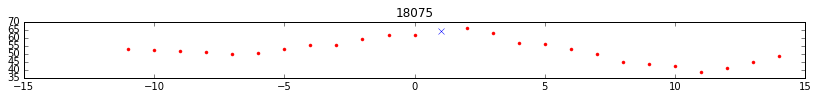

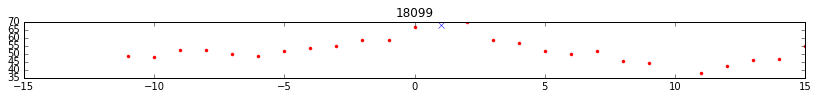

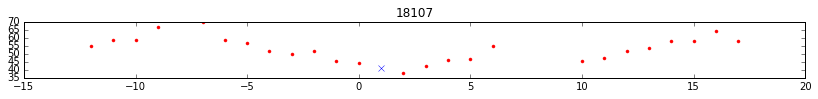

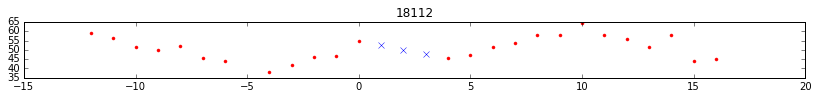

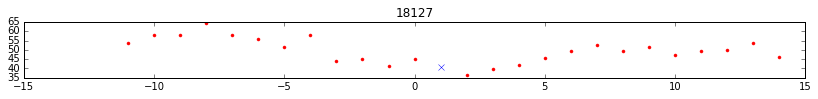

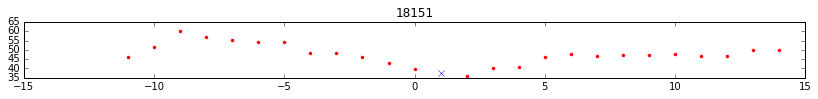

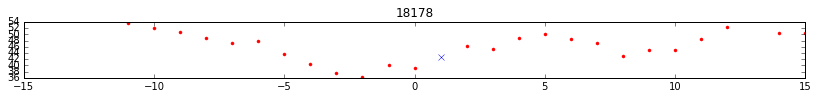

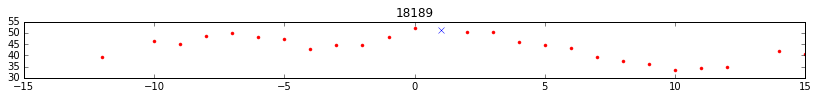

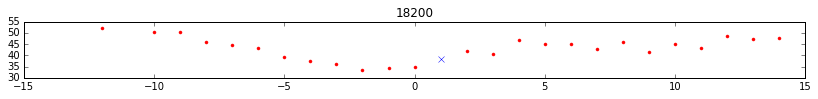

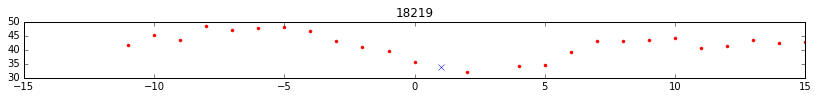

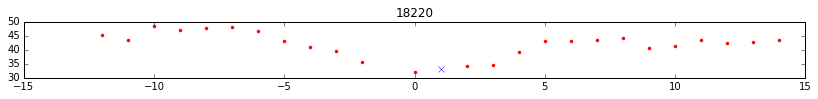

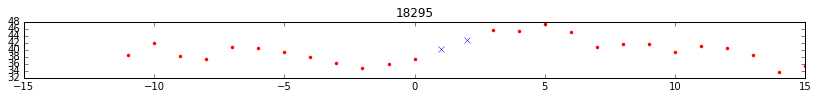

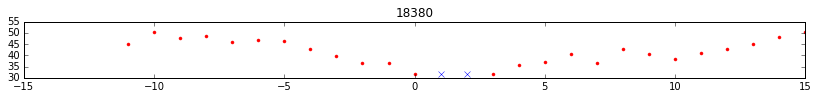

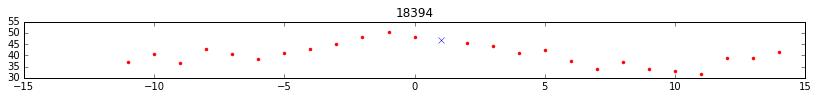

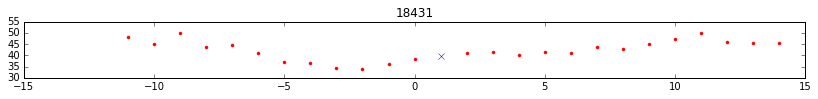

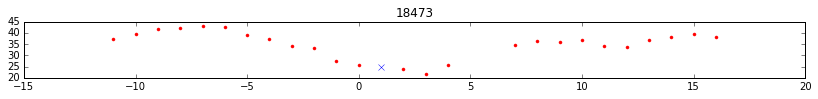

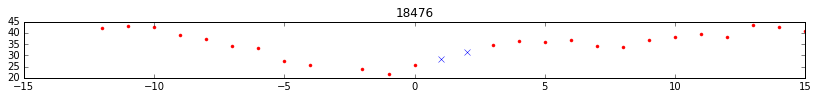

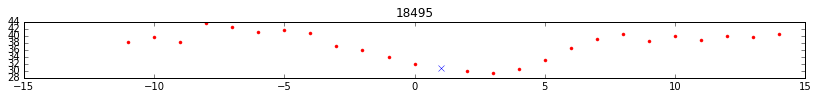

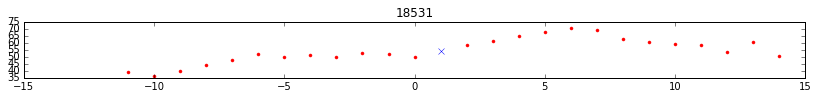

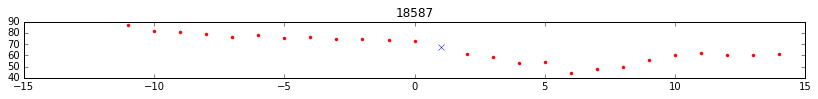

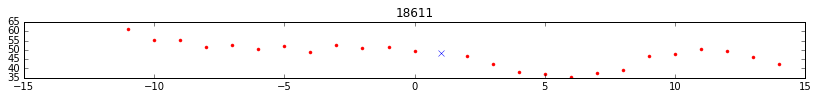

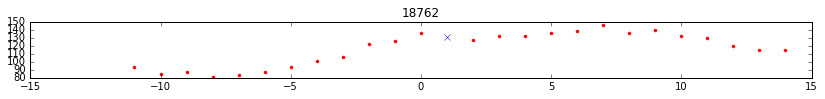

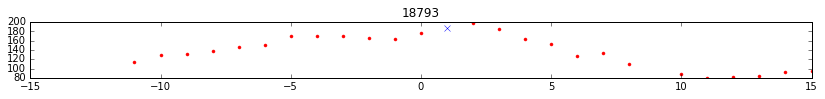

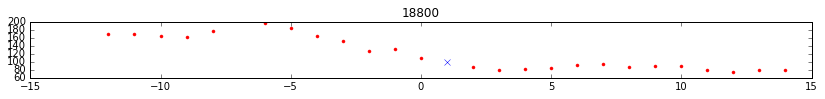

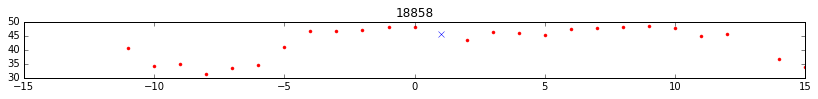

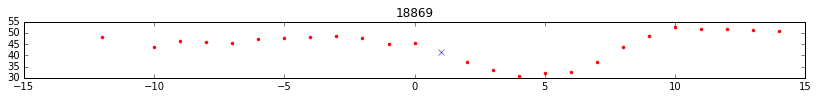

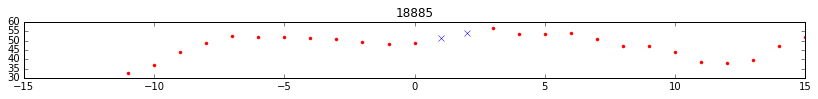

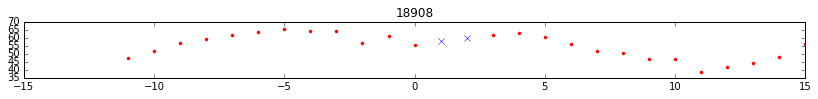

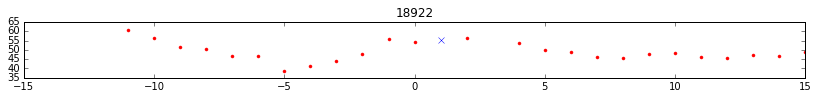

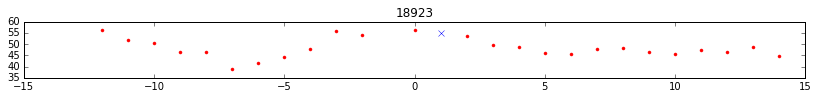

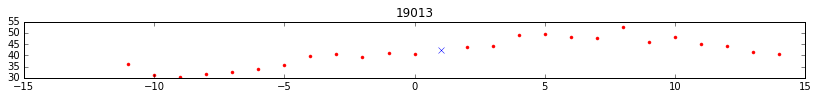

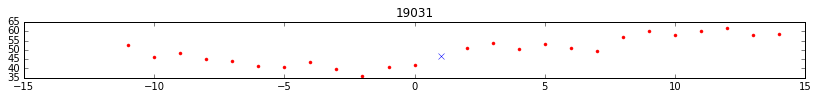

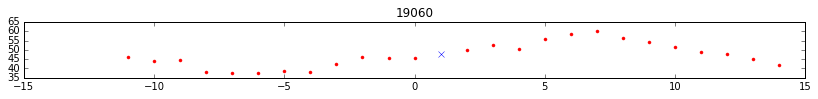

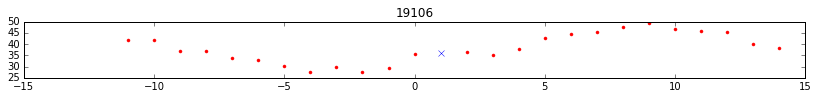

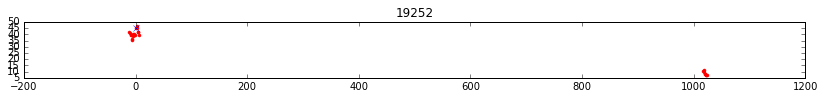

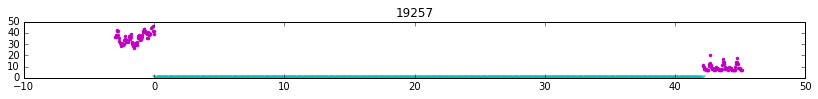

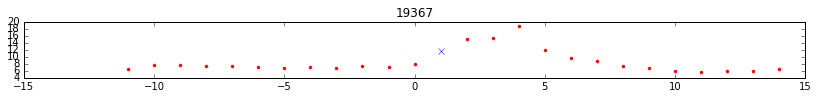

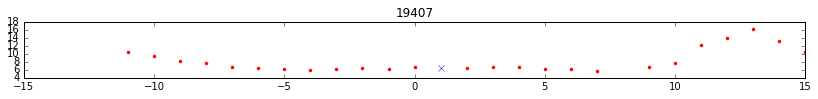

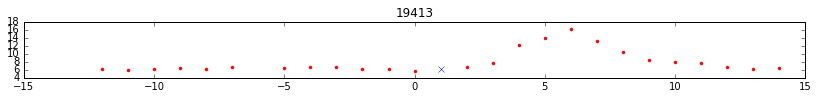

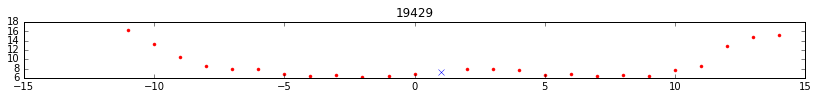

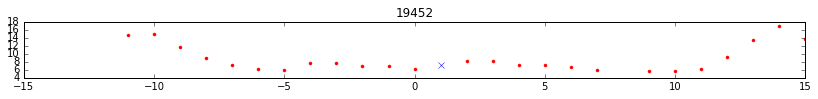

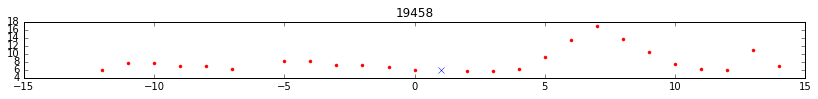

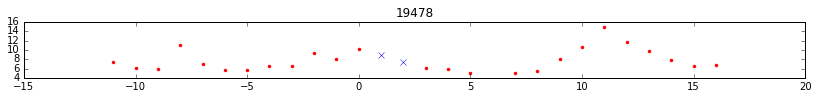

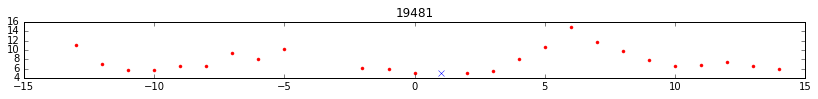

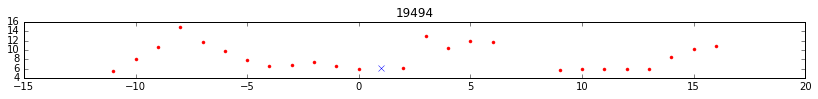

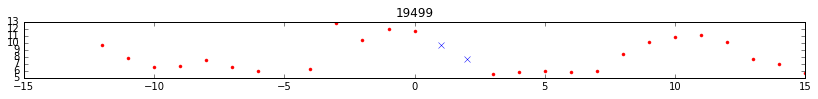

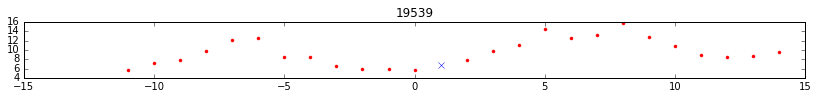

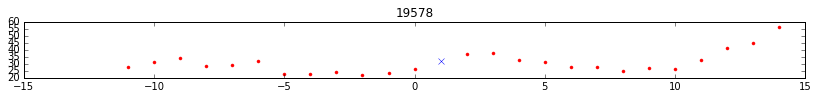

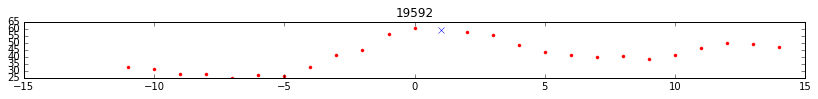

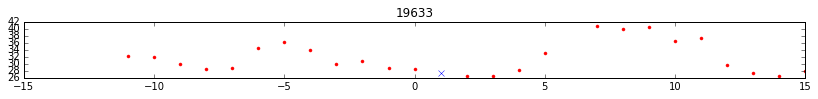

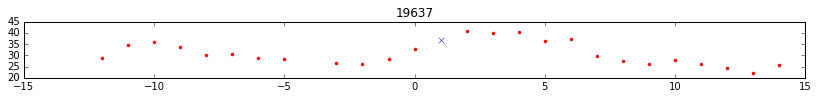

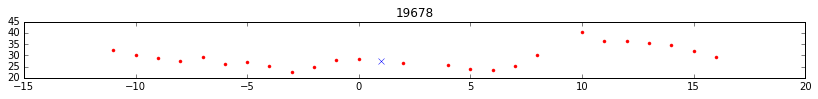

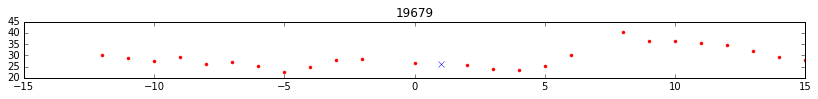

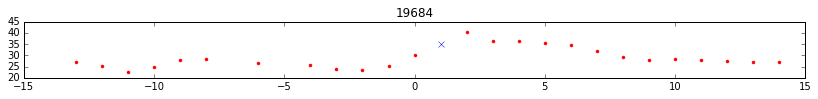

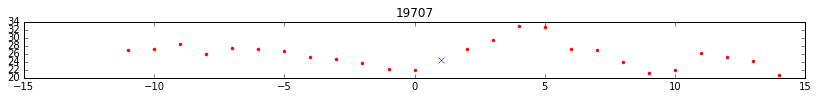

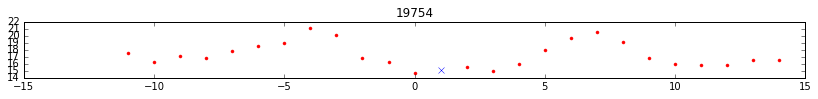

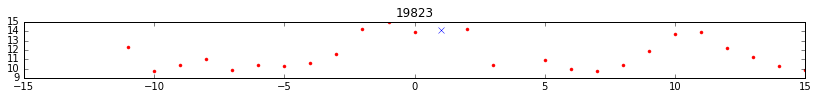

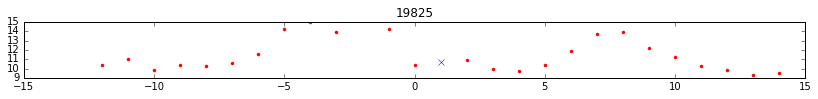

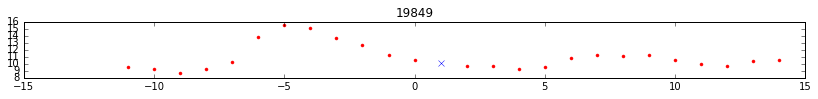

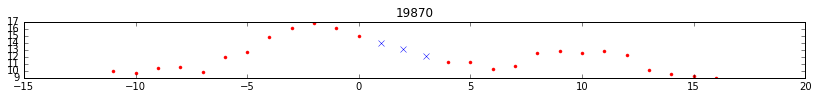

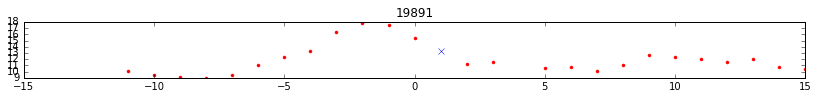

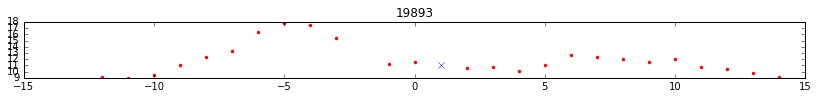

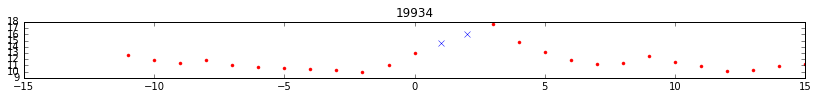

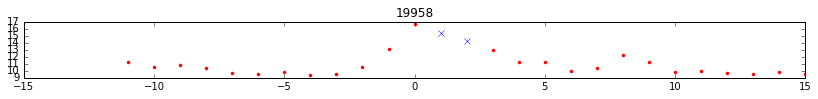

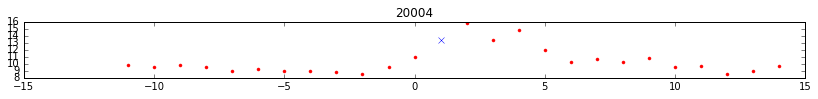

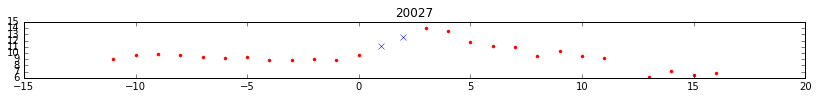

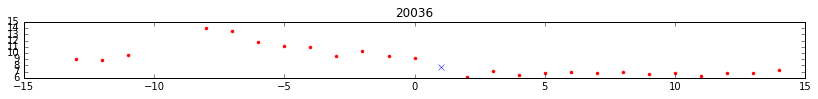

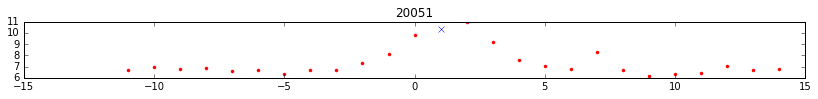

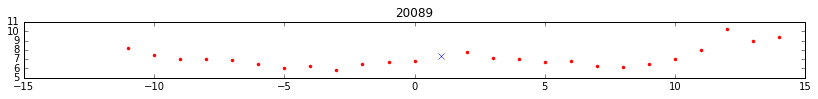

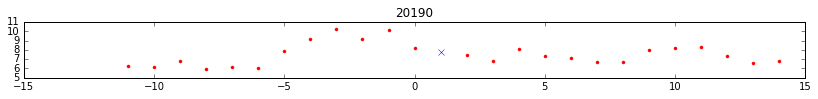

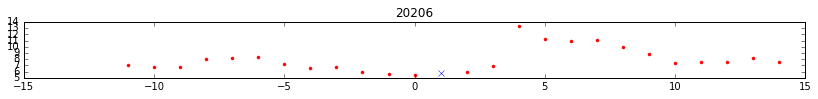

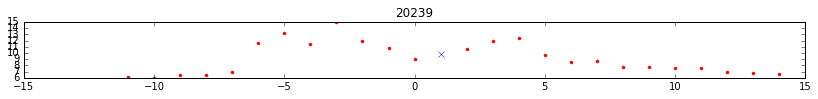

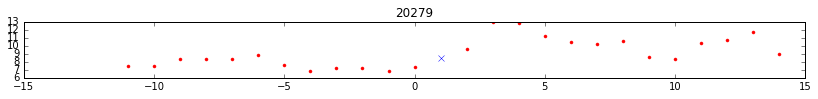

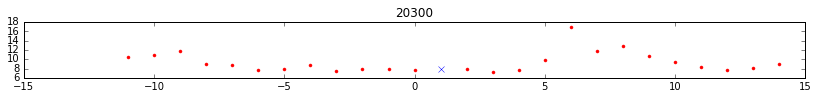

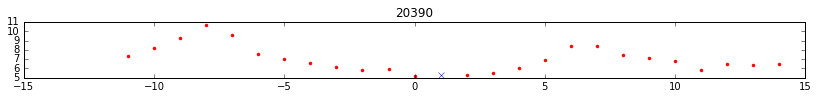

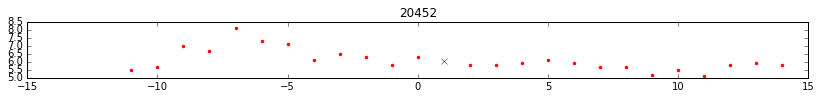

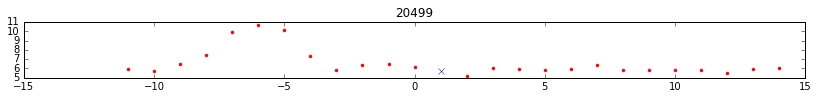

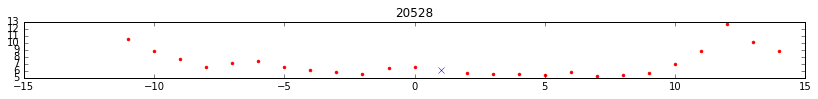

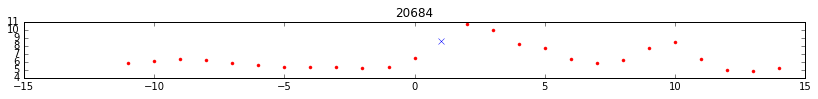

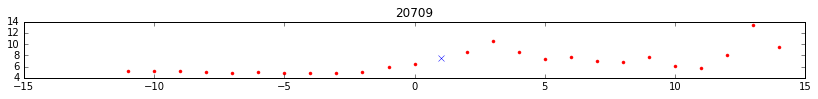

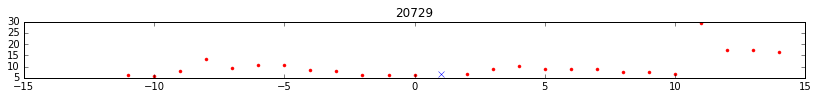

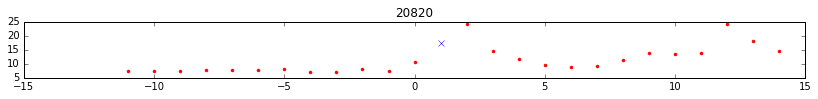

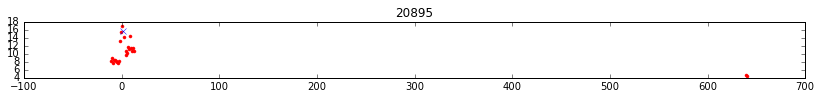

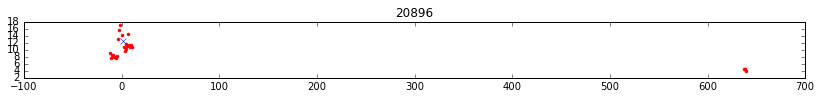

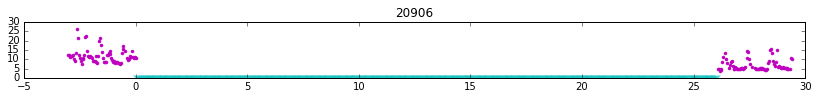

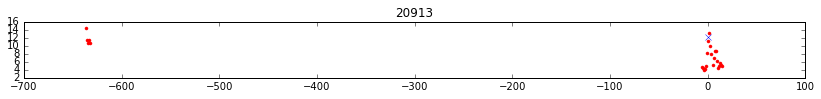

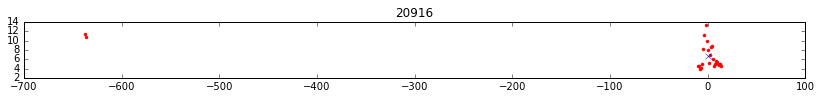

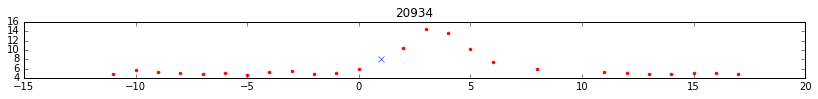

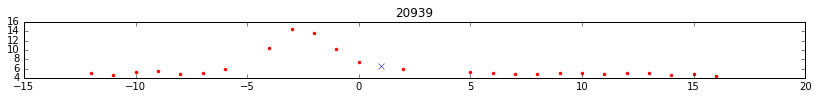

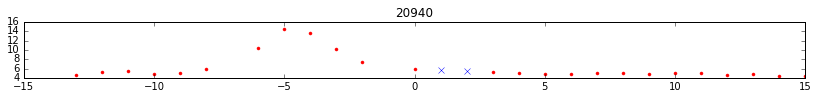

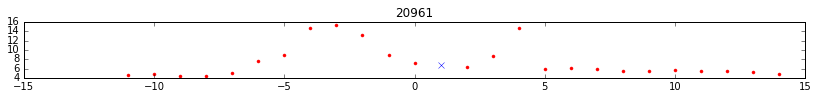

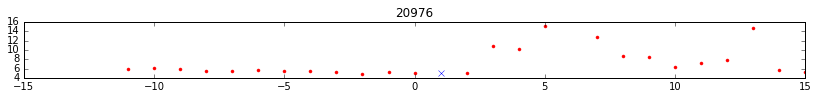

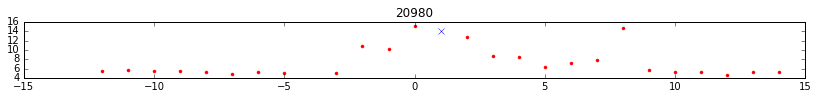

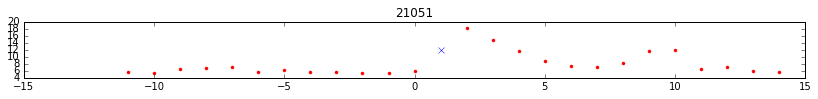

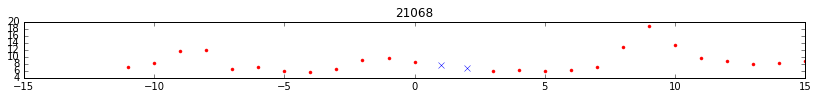

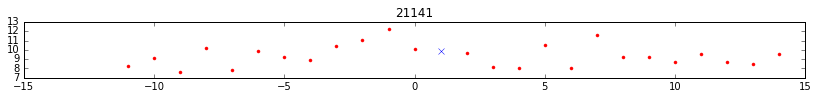

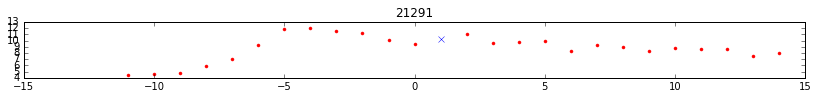

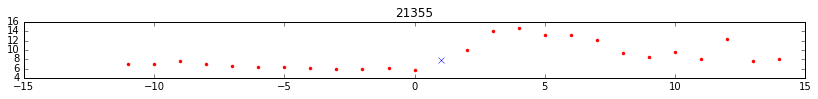

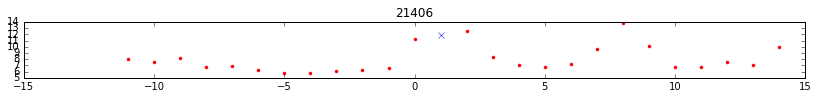

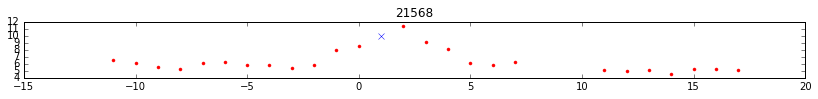

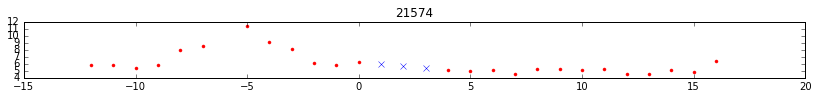

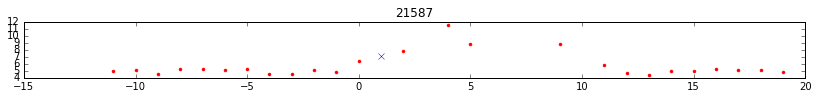

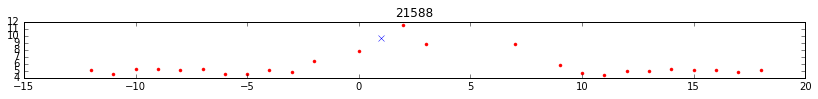

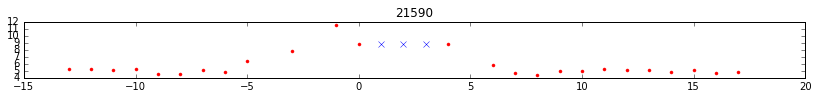

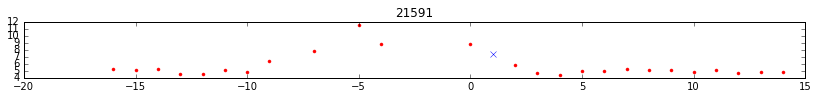

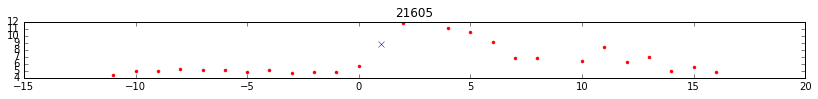

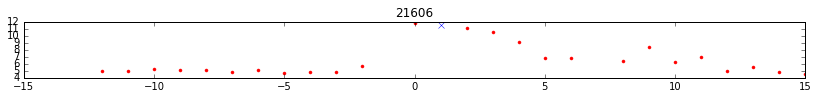

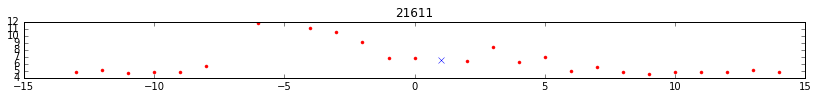

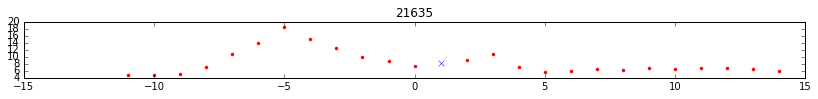

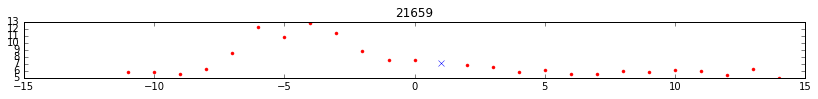

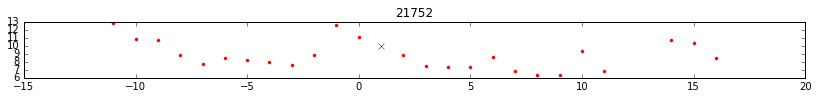

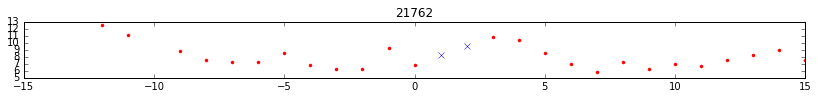

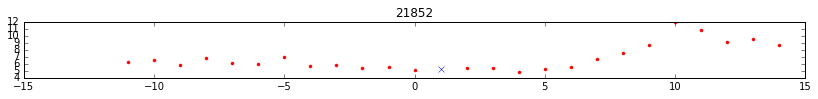

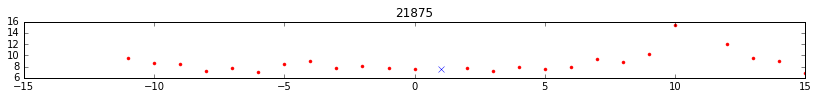

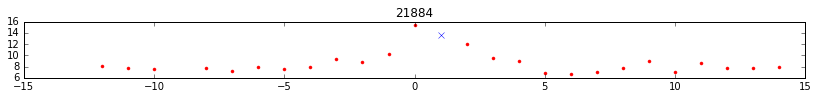

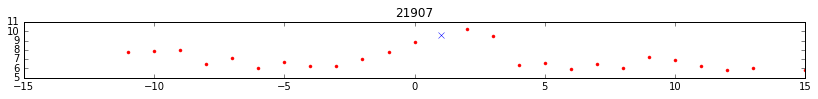

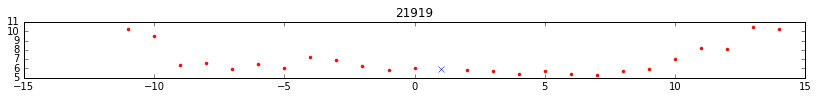

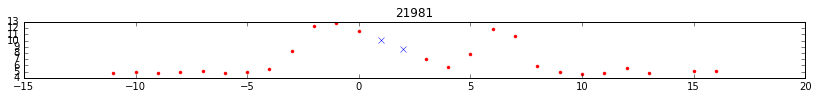

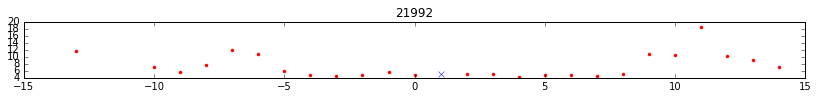

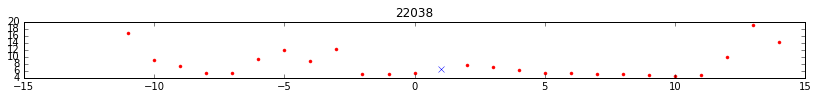

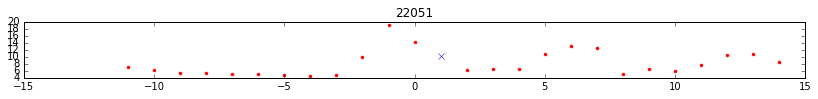

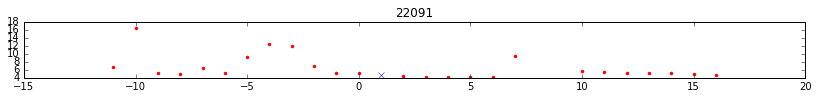

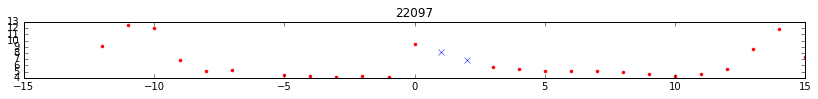

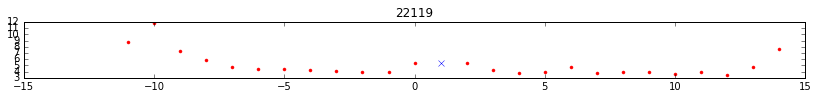

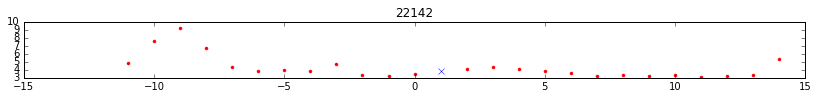

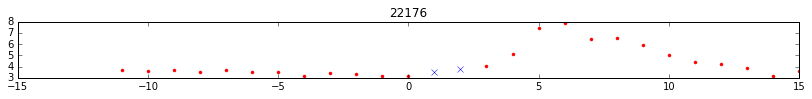

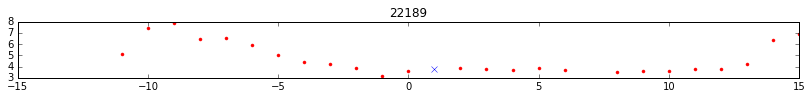

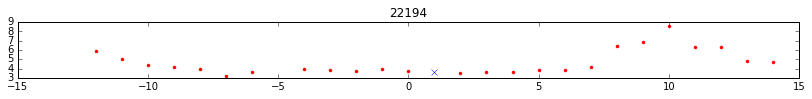

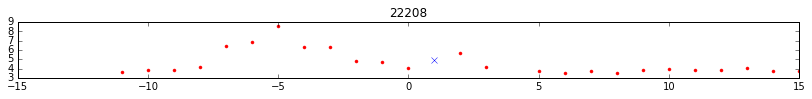

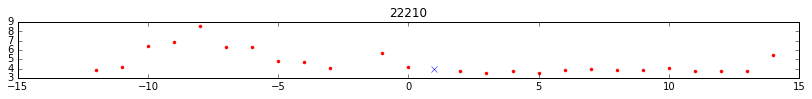

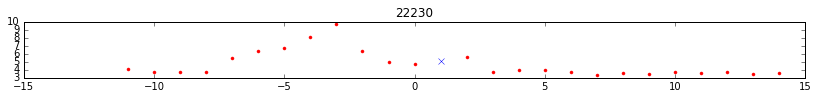

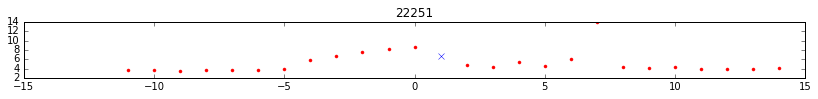

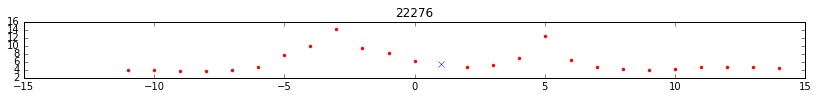

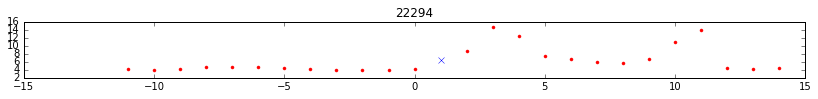

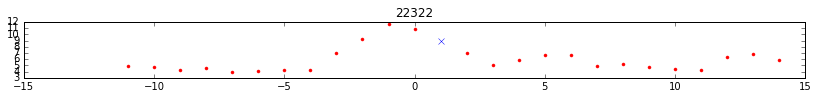

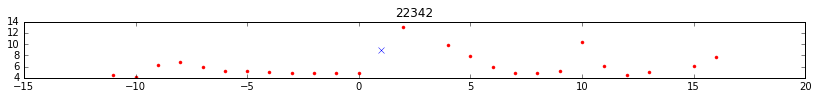

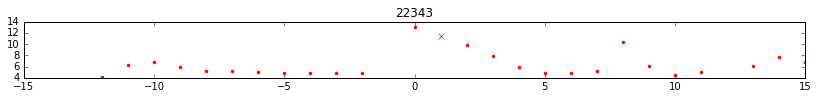

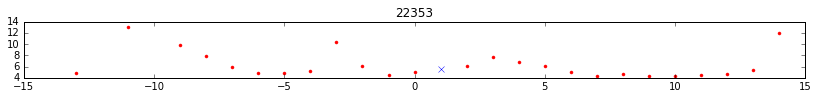

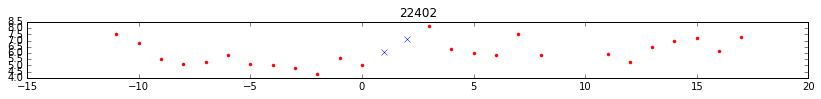

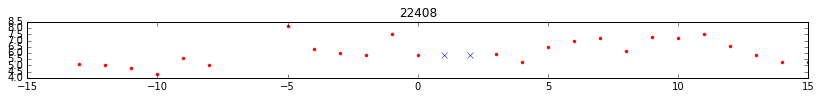

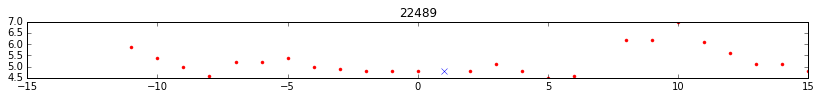

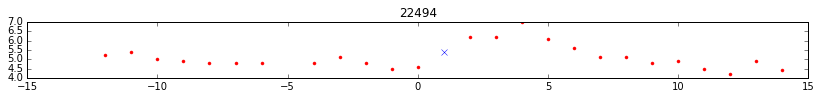

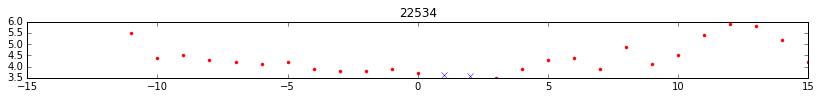

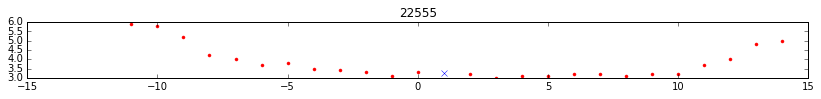

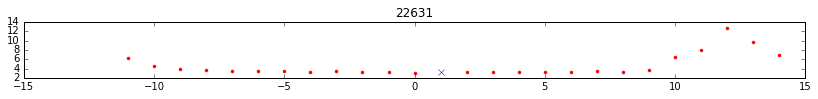

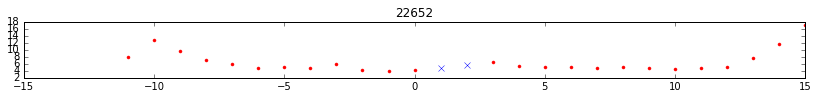

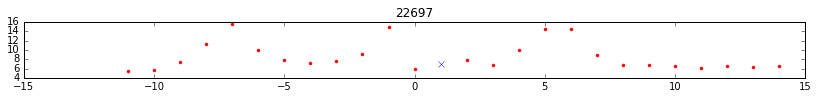

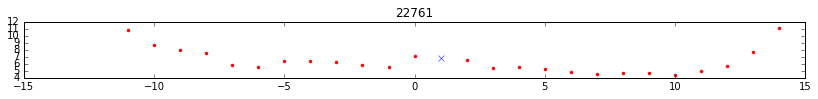

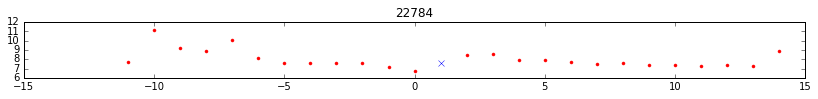

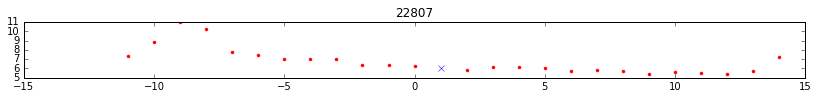

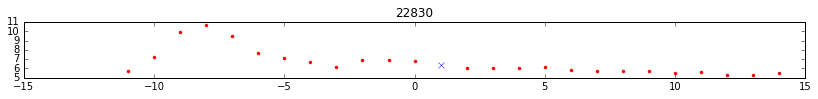

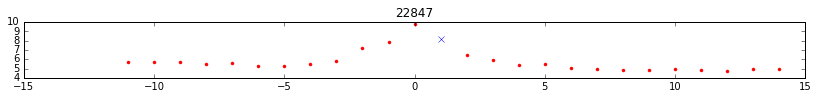

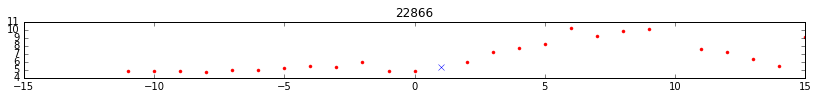

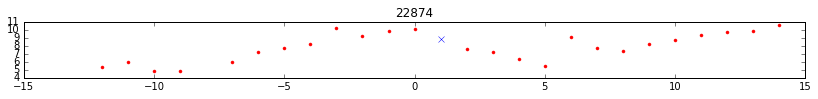

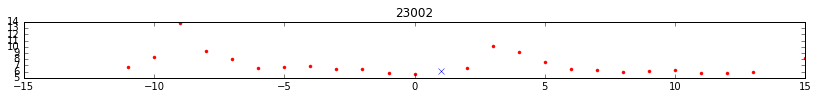

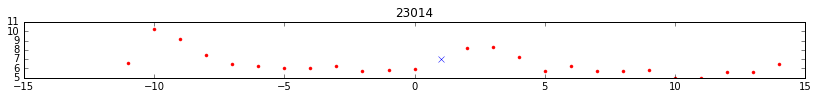

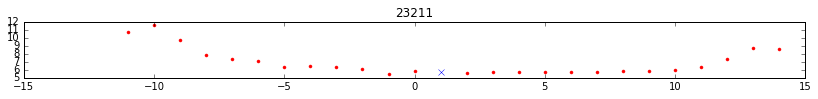

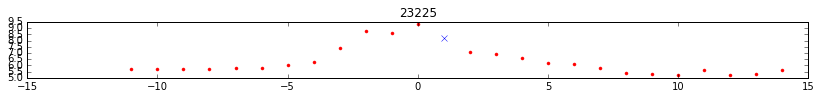

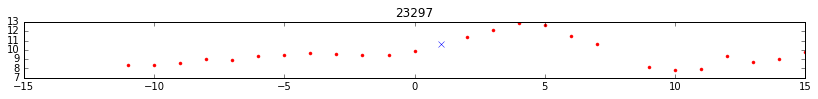

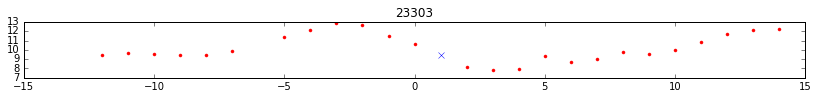

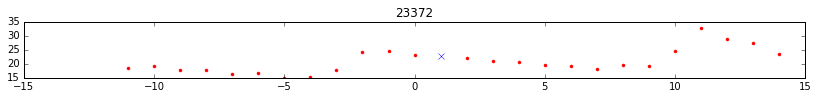

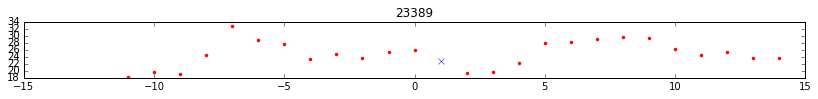

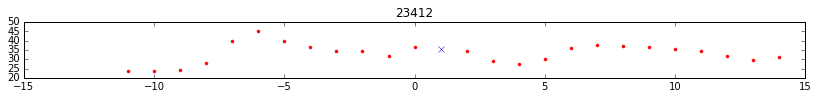

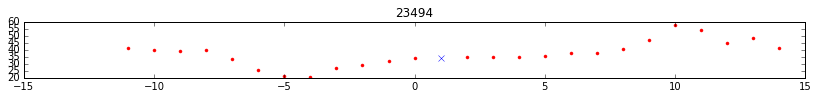

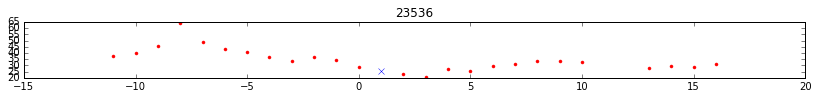

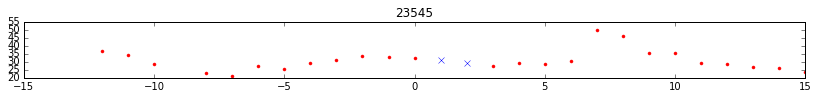

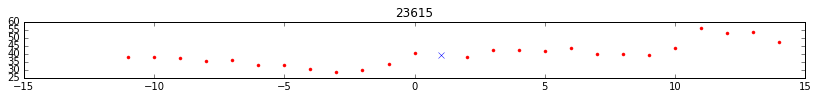

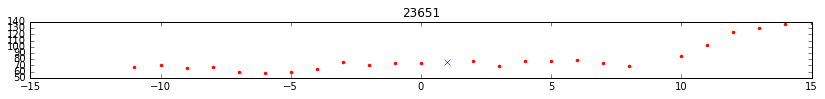

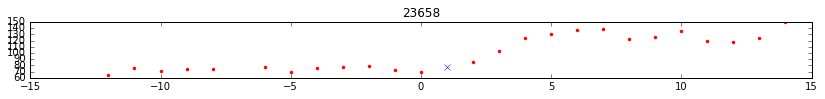

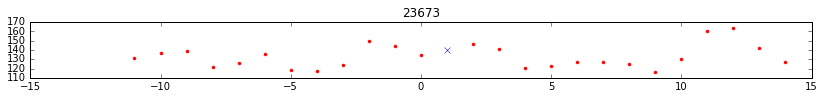

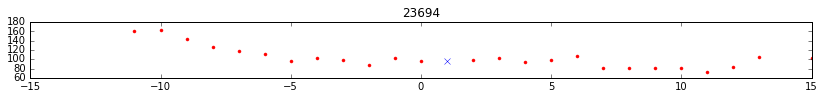

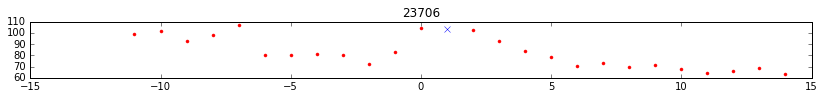

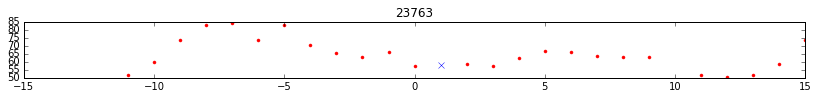

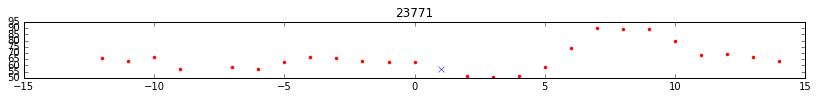

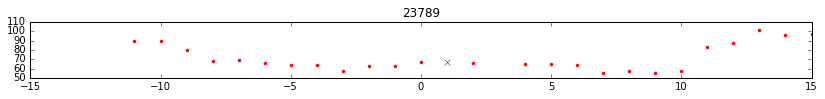

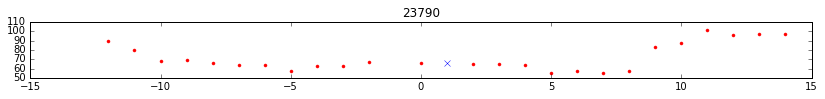

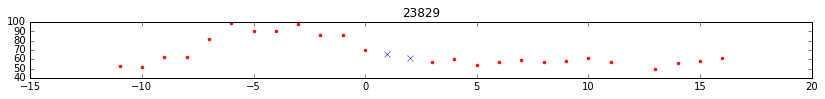

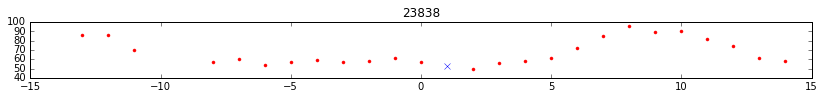

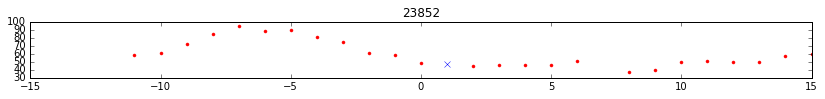

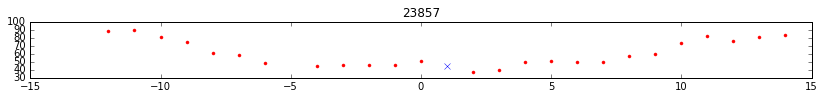

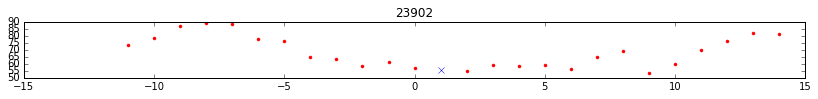

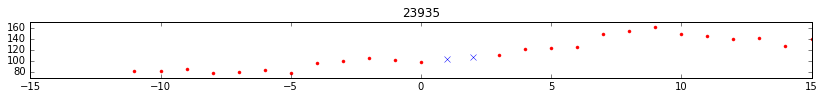

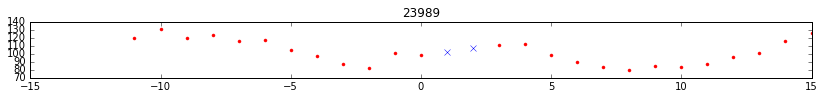

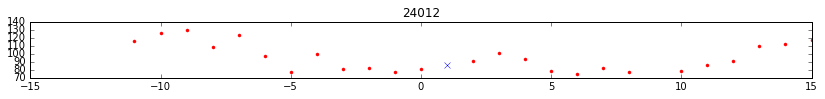

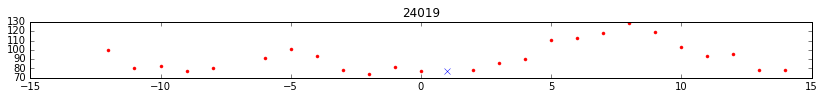

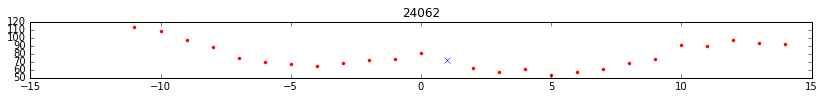

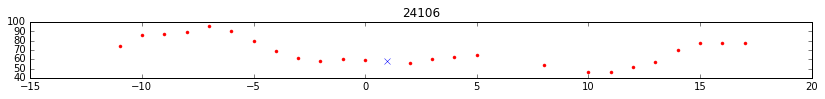

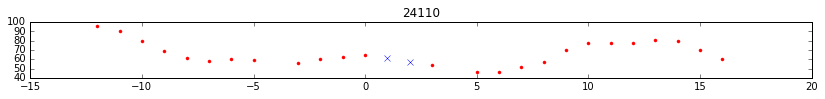

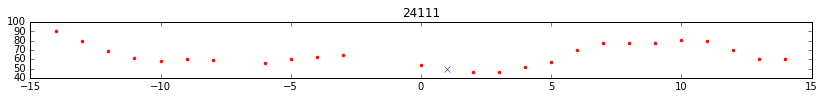

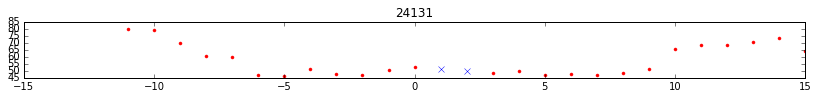

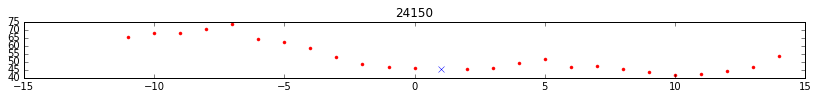

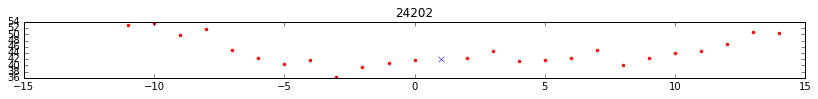

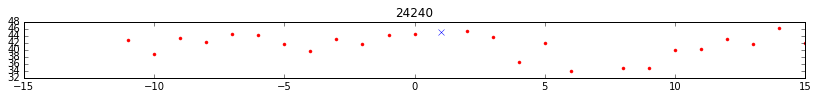

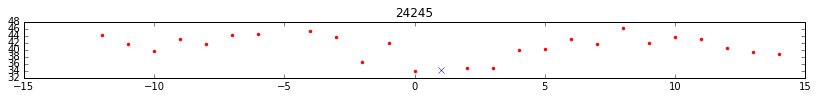

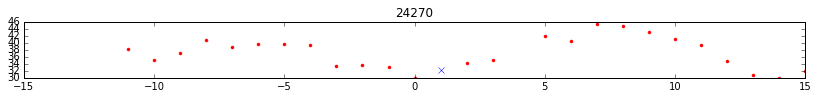

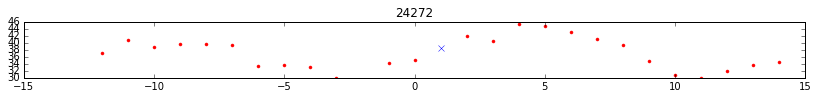

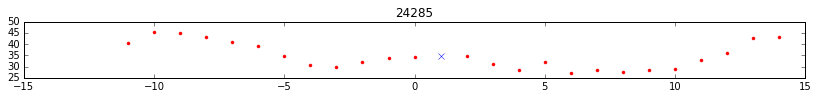

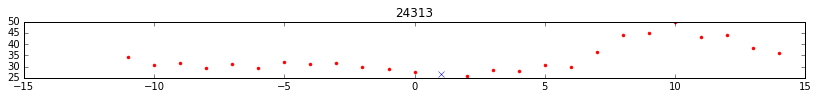

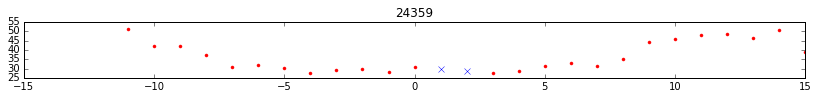

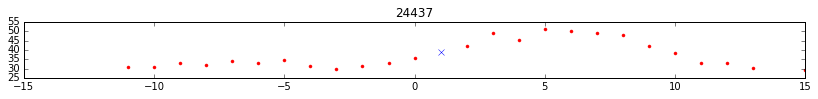

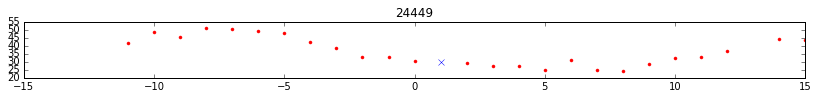

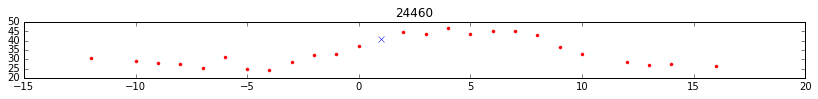

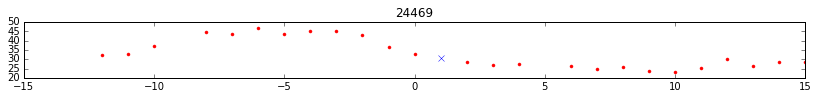

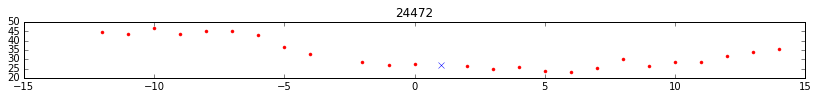

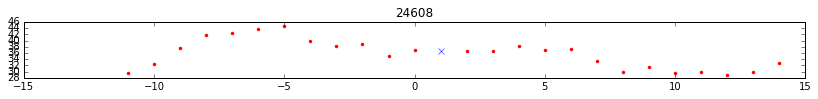

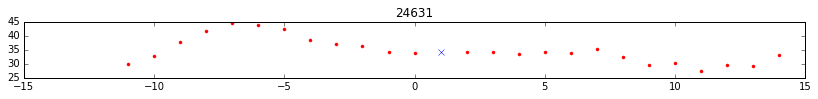

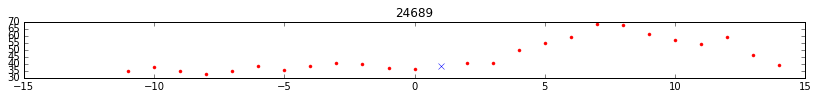

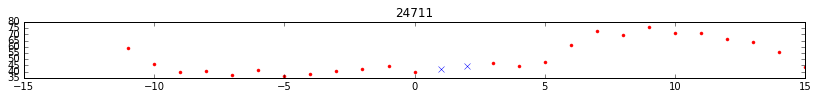

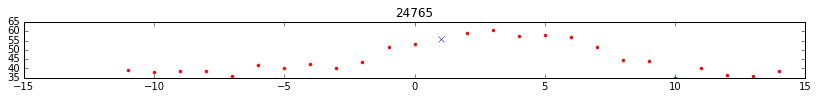

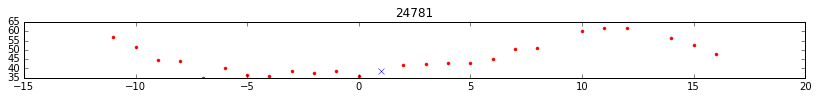

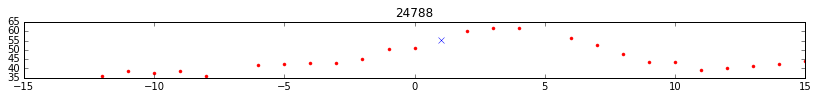

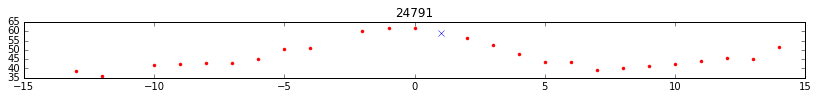

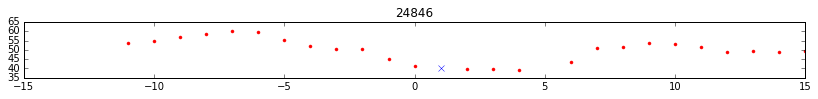

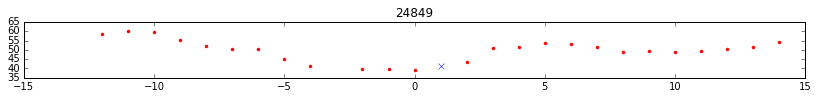

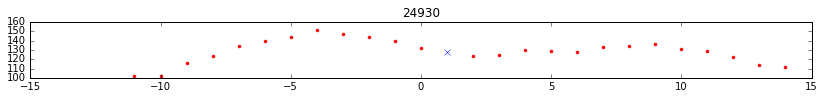

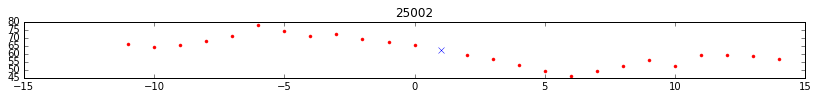

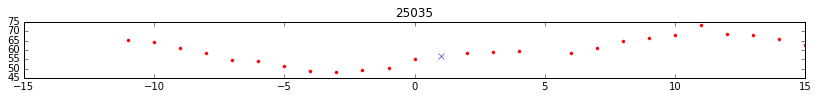

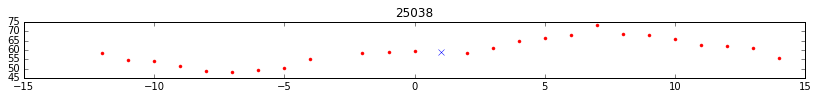

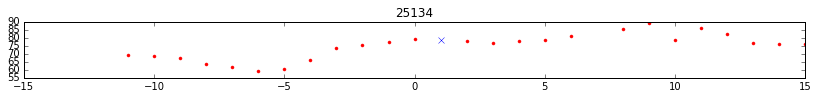

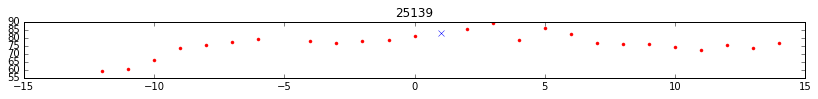

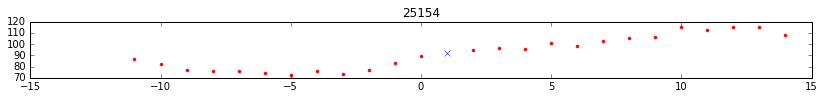

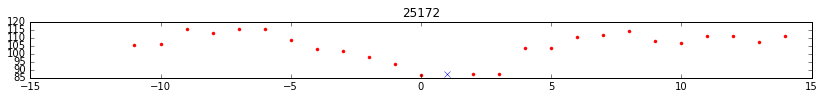

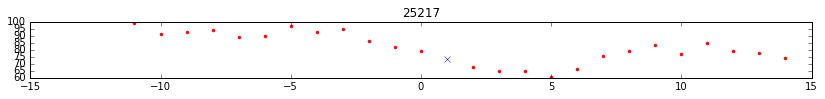

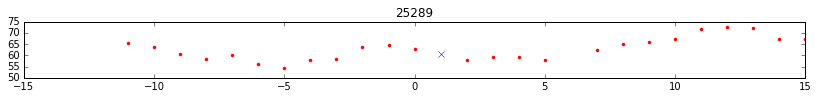

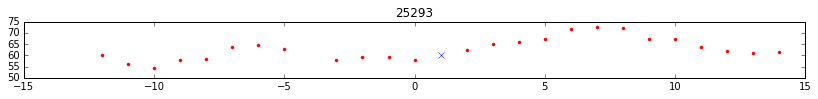

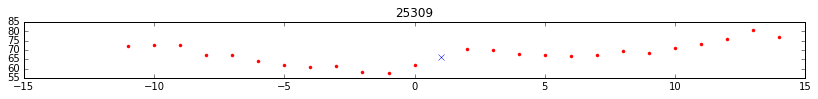

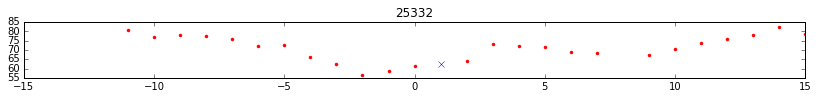

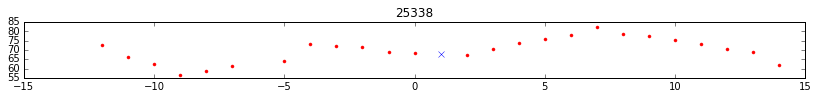

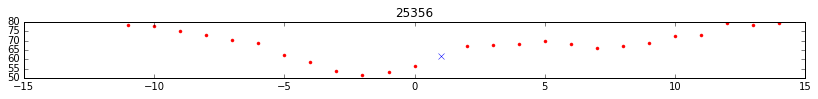

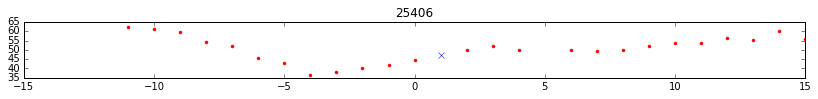

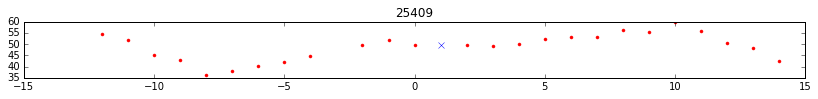

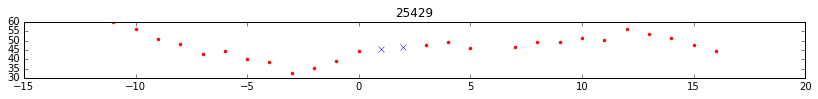

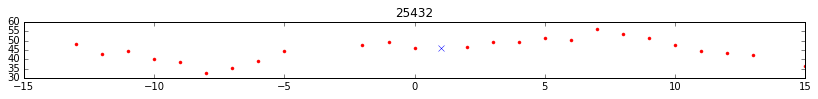

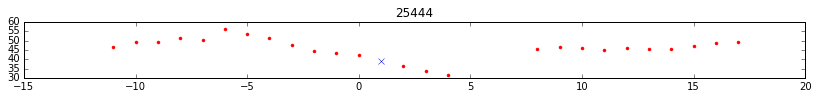

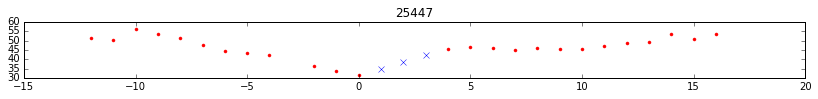

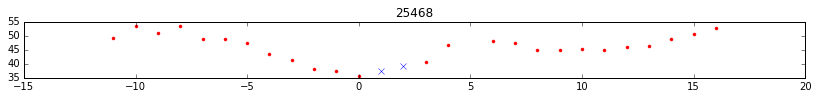

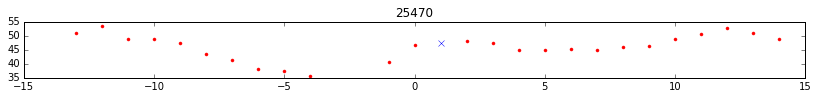

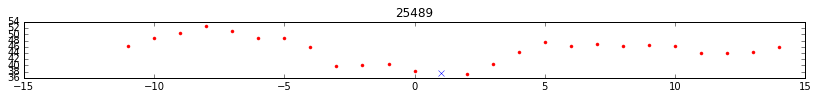

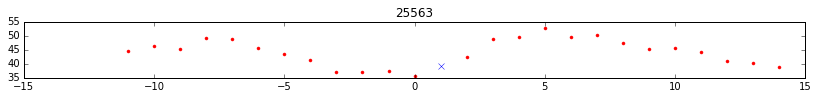

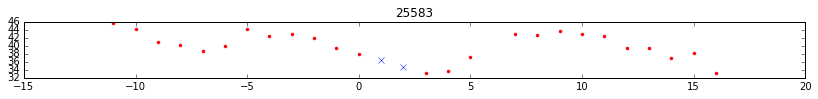

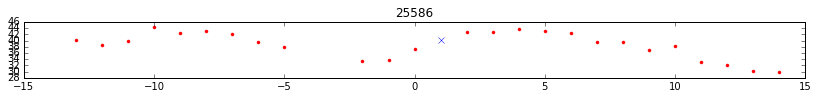

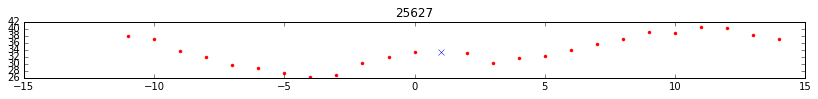

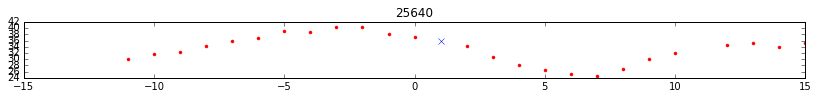

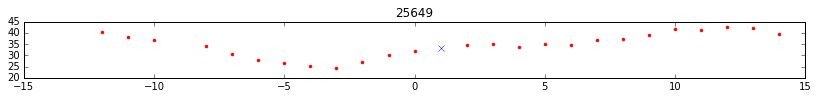

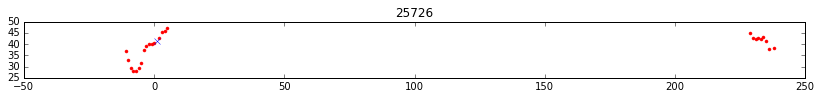

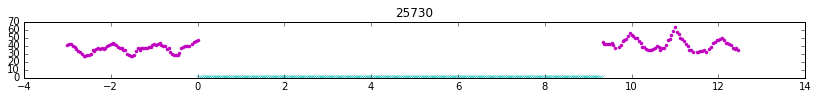

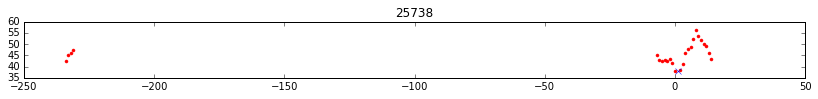

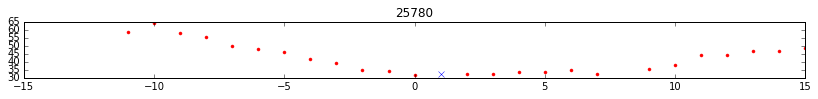

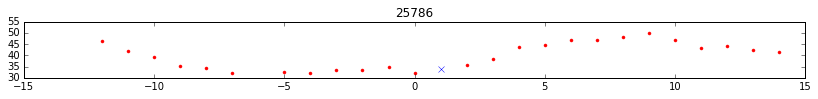

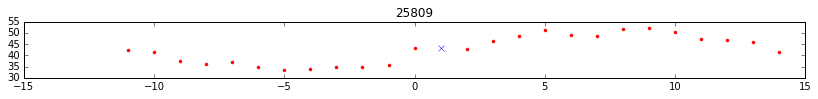

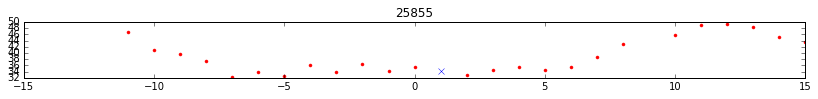

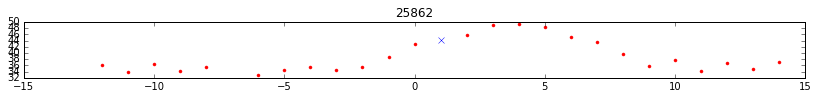

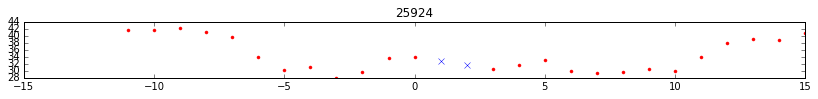

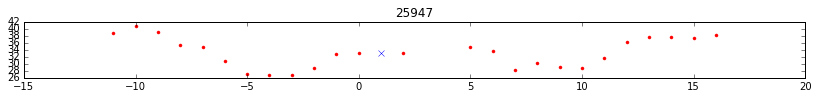

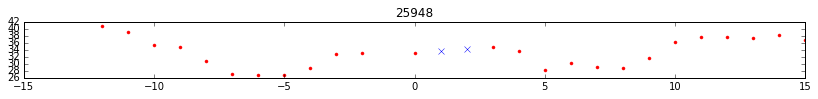

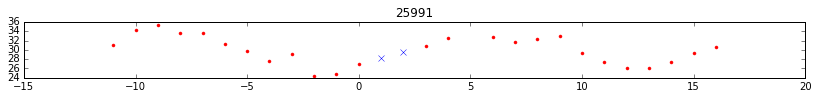

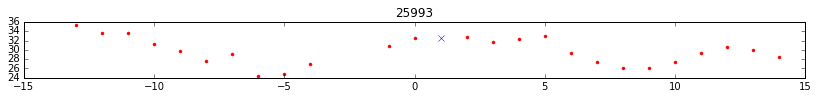

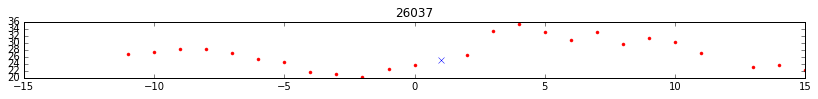

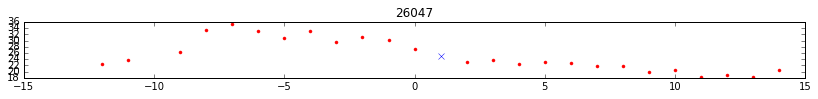

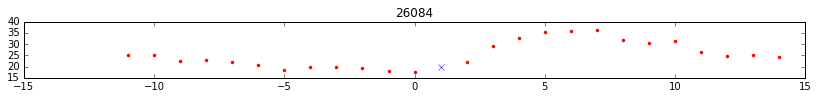

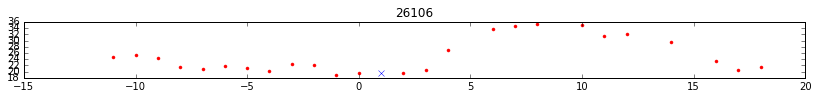

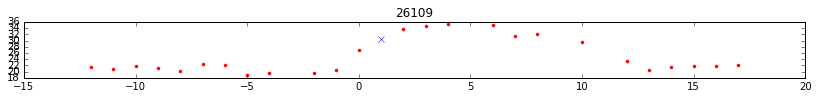

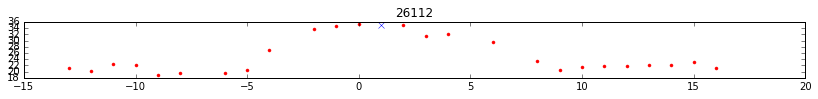

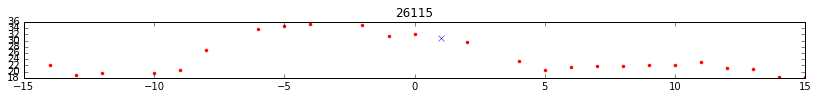

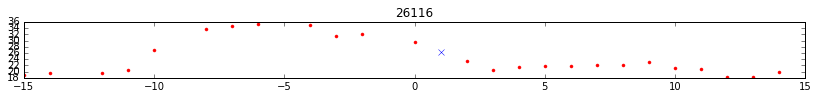

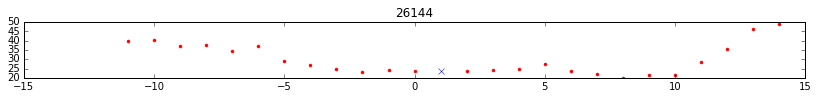

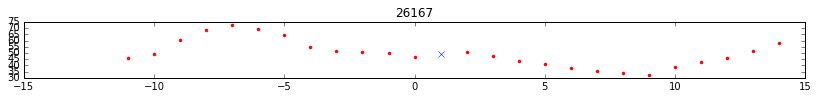

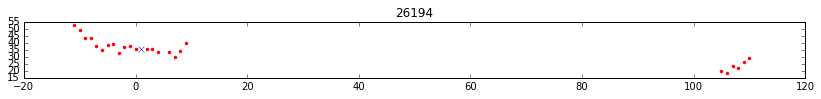

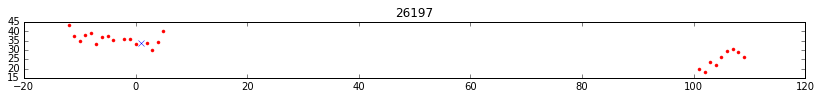

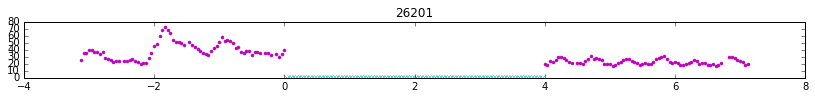

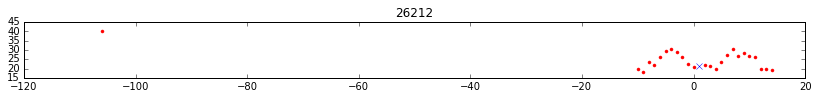

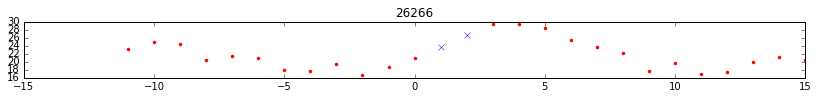

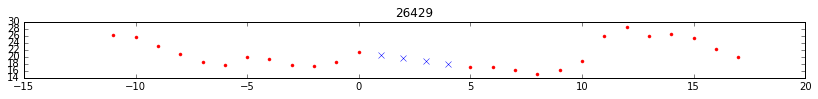

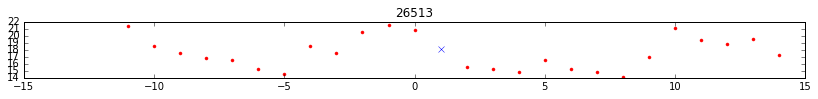

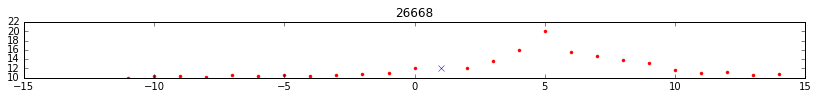

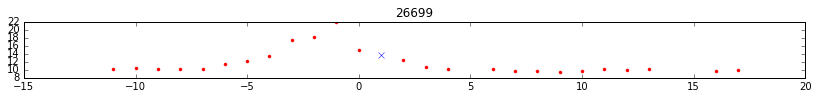

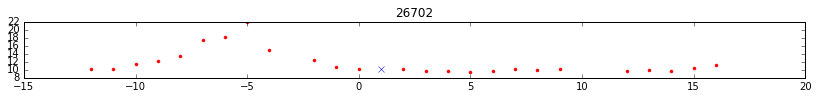

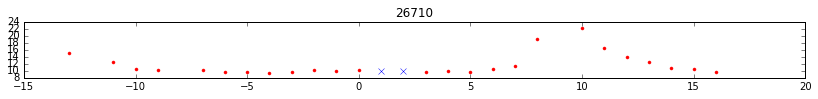

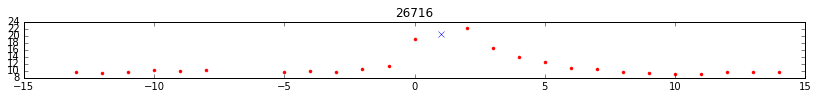

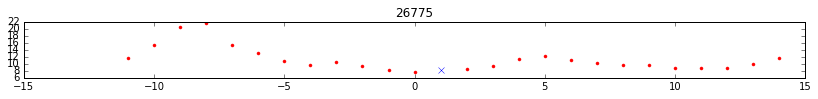

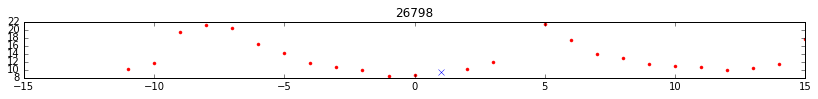

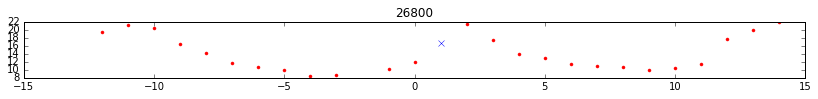

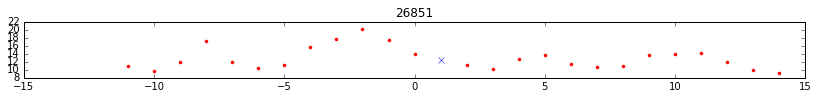

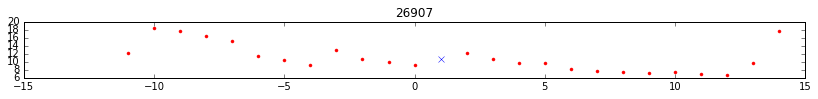

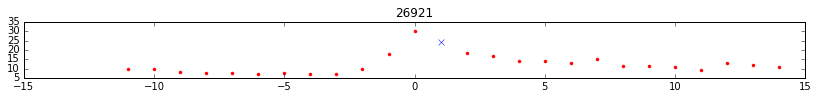

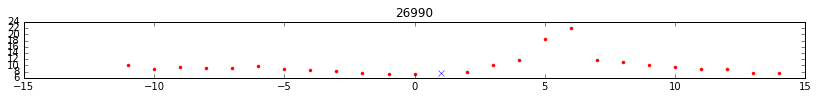

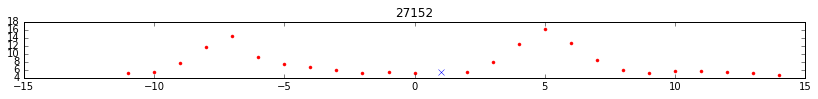

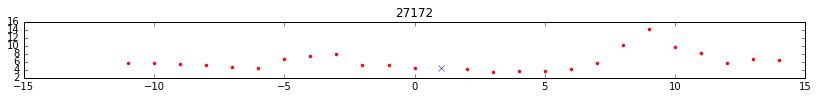

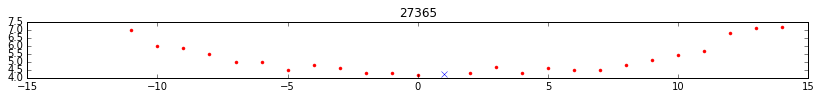

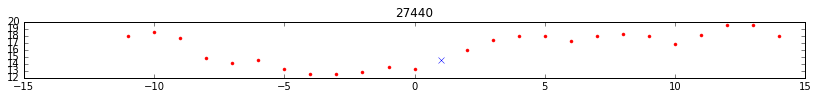

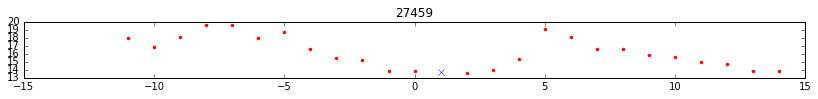

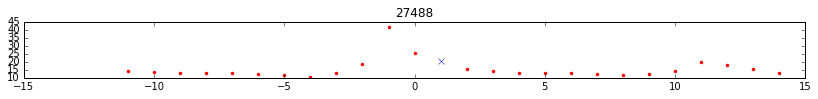

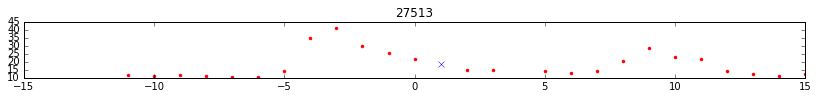

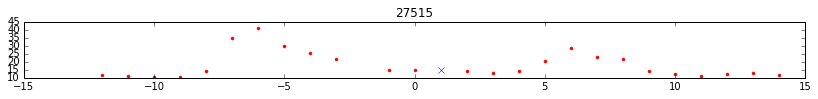

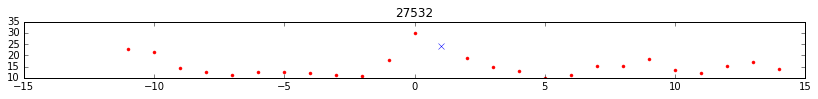

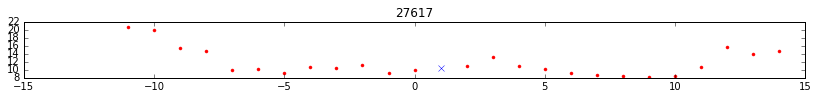

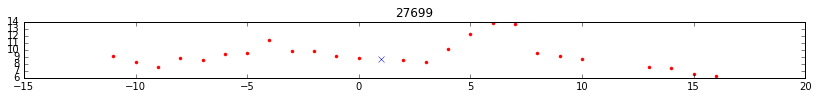

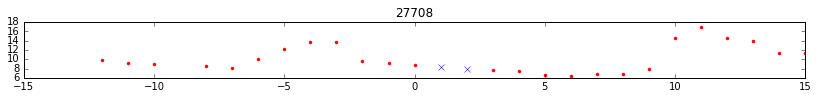

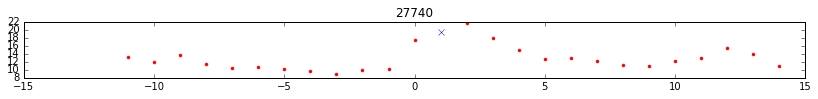

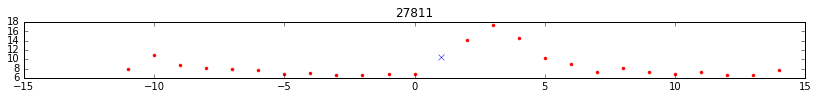

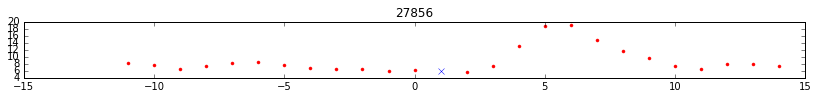

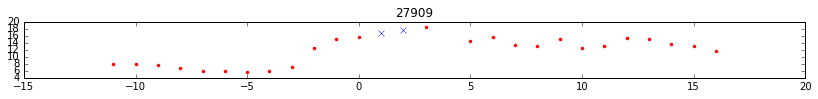

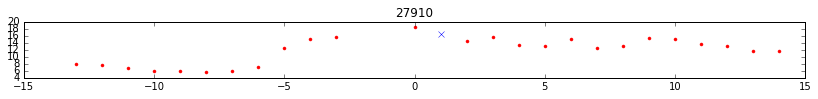

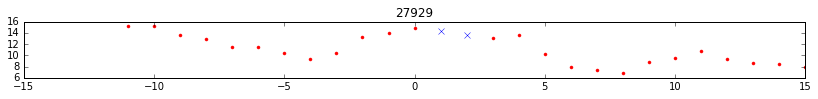

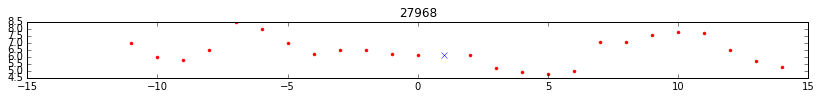

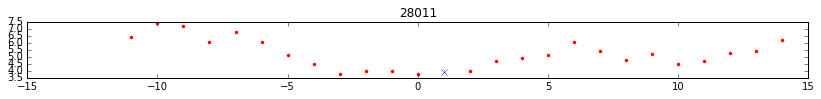

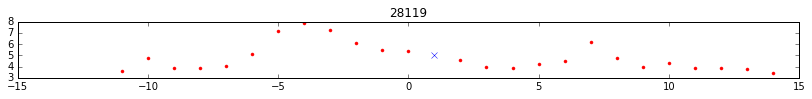

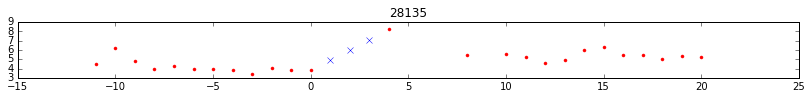

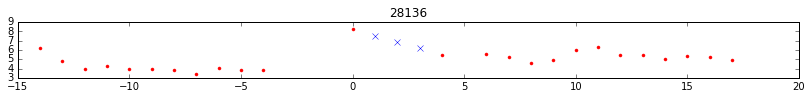

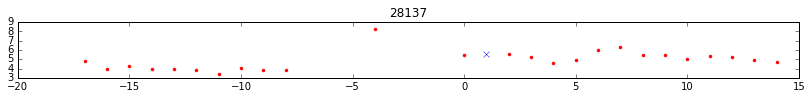

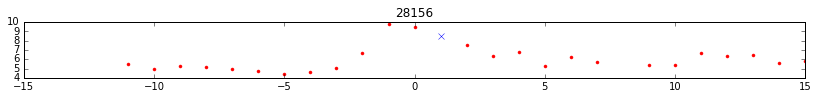

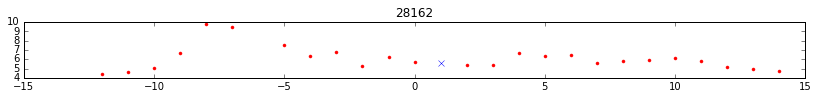

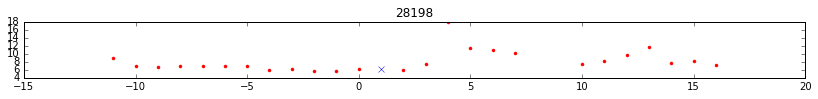

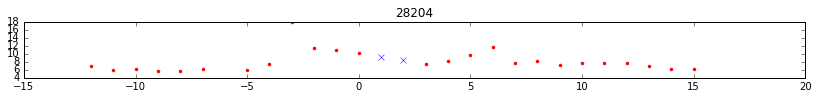

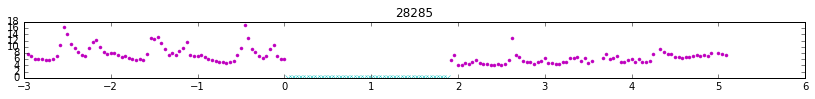

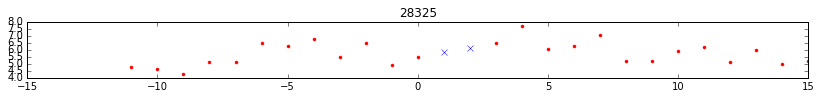

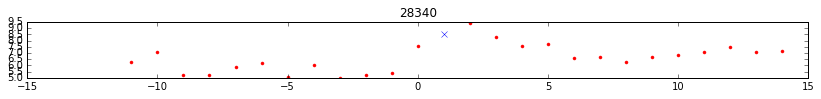

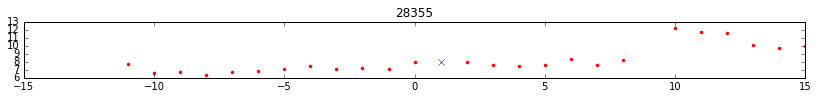

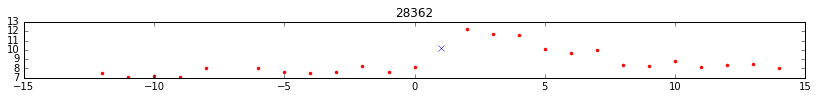

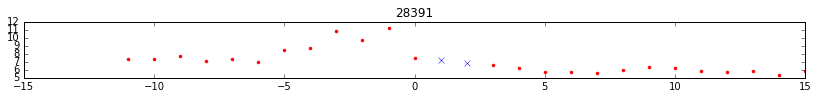

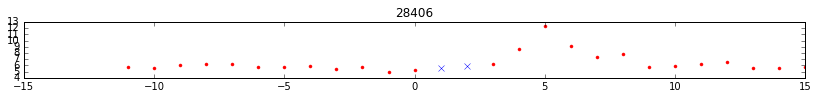

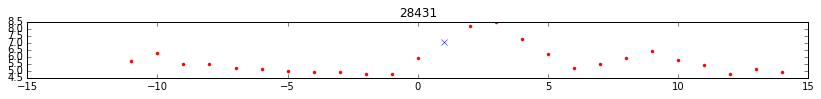

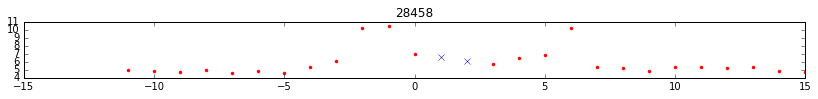

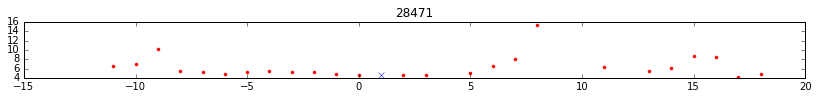

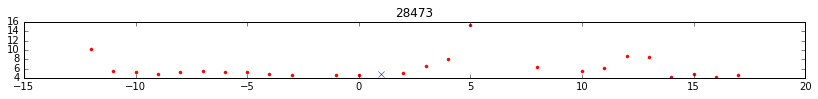

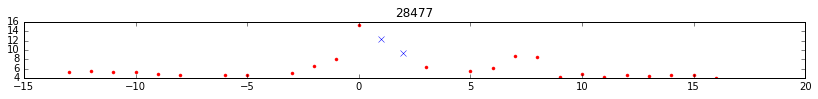

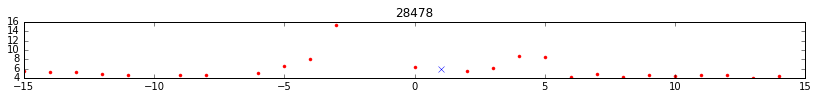

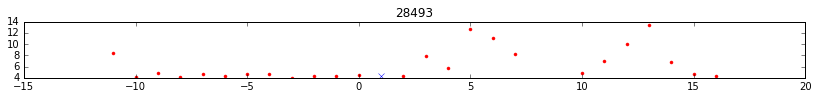

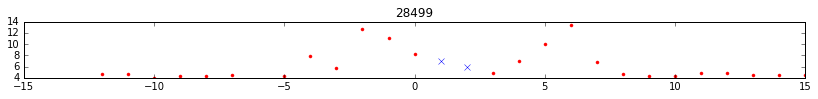

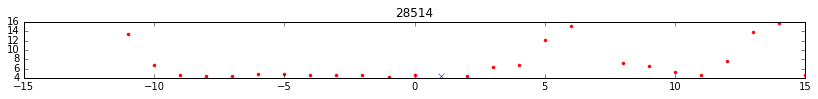

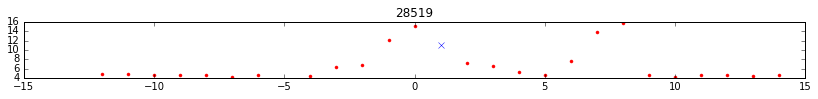

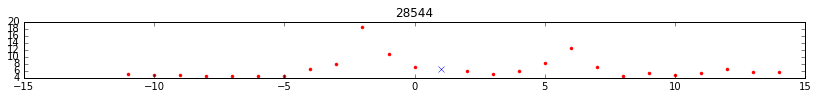

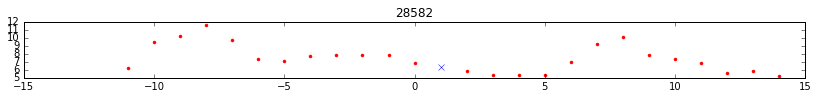

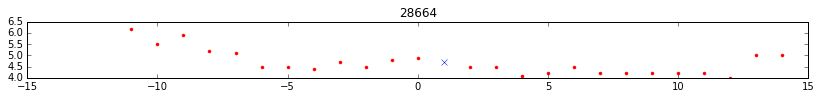

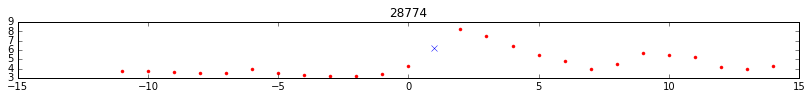

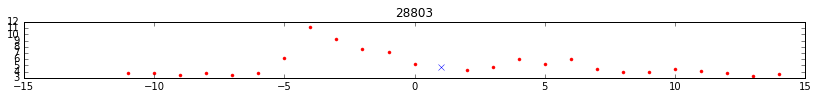

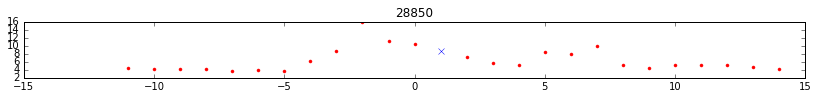

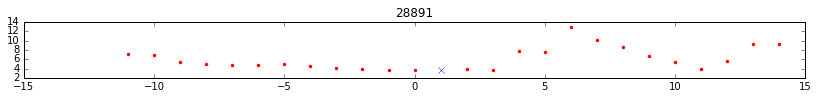

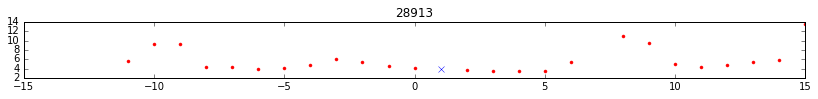

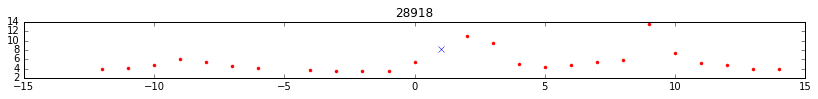

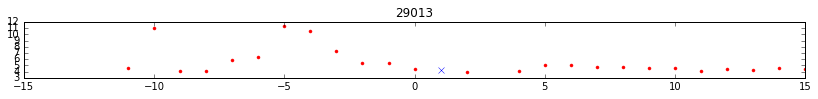

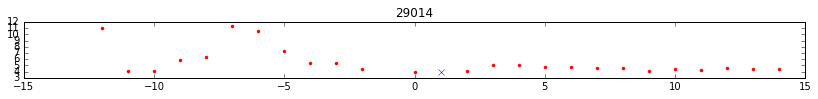

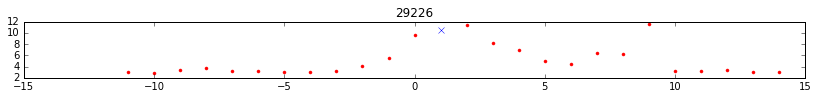

In [16]:
df0=df#[580:]
ddlast=df[(df.daynum==(startdate-dt.date(1900,1,1)).days)&(df.hr==0)]['DecDay'].values[0]-1.0/24.0
iout=0
for ind, row in df0.iterrows():
    #print(ind)
    
    # linearly interpolate breaks of 4 hrs or less
    if (((row['DecDay']-ddlast)<5.5/24.0)&((row['DecDay']-ddlast)>1.5/24.0)): 
        tlast=df0.loc[ind-1]['Turb_NTU']
        tnext=row['Turb_NTU']
        ddnext=row['DecDay']
        nint=int(np.round((ddnext-ddlast)*24)-1)
        fig,ax=plt.subplots(1,1,figsize=(14,1))
        ax.plot((df0.loc[(ind-12):(ind+12)]['DecDay']-ddlast)*24,df0.loc[(ind-12):(ind+12)]['Turb_NTU'],'r.')
        ax.set_title(str(ind))
        for ii in range(1,nint+1):
            dd0=ddlast+ii/24.0
            tur0=tlast+(dd0-ddlast)/(ddnext-ddlast)*(tnext-tlast)
            ax.plot((dd0-ddlast)*24,tur0,'bx')
            if ((dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0-dd0)<.5/24.0):
                dfout.loc[iout]['Turb_NTU']=tur0
                iout+=1
            else:
                print('ERROR 2:')
                print(dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0,
                      dd0,dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0-dd0,.5/24.0)
                break
    elif ((row['DecDay']-ddlast)>5.5/24.0):# fill in larger holes with NaNs; interpolate between days later
        fig,ax=plt.subplots(1,1,figsize=(14,1))
        ax.plot(df0.loc[(ind-72):(ind+72)]['DecDay']-ddlast,df0.loc[(ind-72):(ind+72)]['Turb_NTU'],'m.')
        ax.set_title(str(ind))
        nint=int(np.round((row['DecDay']-ddlast)*24)-1)
        for ii in range(1,nint+1):
            dd0=ddlast+ii/24.0
            ax.plot((dd0-ddlast),0,'cx')
            if ((dfout.loc[iout]['DayNum']+dfout.loc[iout]['Hour']/24.0-dd0)<.5/24.0):
                dfout.loc[iout]['Turb_NTU']=np.nan
                iout+=1
            else:
                print('ERROR 4:')
                break
    # always append current row's value
    if ((dfout.loc[iout]['DayNum']==row['daynum'])&(dfout.loc[iout]['Hour']==row['hr'])):
        dfout.loc[iout]['Turb_NTU']=row['Turb_NTU']
    else:
        print('ERROR 1:')
        print('iout=',iout,'ind=',ind)
        print(dfout.loc[iout]['DayNum'],row['daynum'],dfout.loc[iout]['Hour'],row['hr'])
        break
    iout+=1
    ddlast=row['DecDay']
    
    

In [17]:
session.query(FBuoyTBL.Turb_NTU).filter(FBuoyTBL.DecDay.between(41850,41850.5)).all()

[(33.3),
 (36.0),
 (39.6),
 (37.2),
 (37.2),
 (39.9),
 (30.1),
 (33.5),
 (36.9),
 (28.1),
 (28.1),
 (28.0)]

In [18]:
dfout

DayNum Hour Turb_NTU
0      39812    0      6.7
1      39812    1      8.2
2      39812    2     14.8
3      39812    3    10.05
4      39812    4      5.3
5      39812    5      5.1
6      39812    6      4.6
7      39812    7      5.1
8      39812    8      5.6
9      39812    9      5.2
10     39812   10      4.5
11     39812   11      4.1
12     39812   12        4
13     39812   13      3.6
14     39812   14      4.1
15     39812   15      5.5
16     39812   16      4.8
17     39812   17      5.3
18     39812   18      4.1
19     39812   19      3.9
20     39812   20      3.7
21     39812   21      3.9
22     39812   22      3.9
23     39812   23      4.5
24     39813    0      4.1
25     39813    1      4.9
26     39813    2      7.7
27     39813    3      8.3
28     39813    4      8.9
29     39813    5      5.7
...      ...  ...      ...
35058  41272   18        3
35059  41272   19      2.9
35060  41272   20      2.9
35061  41272   21      2.9
35062  41272   22        3
35063  41272   23      3.2
35064  41273    0      NaN
35065  41273    1      NaN
35066  41273    2      NaN
35067  41273    3      NaN
35068  41273    4      NaN
35069  41273    5      NaN
35070  41273    6      NaN
35071  41273    7      NaN
35072  41273    8      NaN
35073  41273    9      NaN
35074  41273   10      NaN
35075  41273   11      NaN
35076  41273   12      NaN
35077  41273   13      NaN
35078  41273   14      NaN
35079  41273   15      NaN
35080  41273   16      NaN
35081  41273   17      NaN
35082  41273   18      NaN
35083  41273   19      NaN
35084  41273   20      NaN
35085  41273   21      NaN
35086  41273   22      NaN
35087  41273   23      NaN

[35088 rows x 3 columns]

In [19]:
for idd in range((startdate-dt.date(1900,1,1)).days,(enddate-dt.date(1900,1,1)).days):# intentionally don't fill in last one because of Nans
    tdata=dfout[(dfout.DayNum==idd)&(dfout.Turb_NTU>0)]['Turb_NTU'].values # exclude NaNs
    nn=len(tdata)
    if nn>19: #more  than 80% of day represented
        dfdaily.loc[dfdaily.DayNum==idd,'Turb_NTU']=np.mean(tdata)

In [20]:
dfdaily

DayNum Turb_NTU
0     39812  5.43958
1     39813  4.70833
2     39814  4.04167
3     39815   3.6125
4     39816  3.85417
5     39817   4.3125
6     39818  6.17083
7     39819  15.4583
8     39820  42.9708
9     39821  40.3083
10    39822  22.9083
11    39823   14.475
12    39824  11.3813
13    39825     9.75
14    39826  9.02708
15    39827  7.73333
16    39828  6.46042
17    39829    5.625
18    39830  5.03333
19    39831   4.9625
20    39832  5.14583
21    39833   6.0375
22    39834  5.70208
23    39835  6.42917
24    39836  5.69583
25    39837  5.67708
26    39838  5.87917
27    39839  6.10208
28    39840  6.63333
29    39841  4.22708
...     ...      ...
1432  41244  6.32083
1433  41245  6.24167
1434  41246  5.84583
1435  41247  4.63333
1436  41248  4.65833
1437  41249    4.675
1438  41250  4.38333
1439  41251  4.33958
1440  41252  4.92917
1441  41253  5.24375
1442  41254  6.79583
1443  41255   6.3625
1444  41256  5.51458
1445  41257  5.79583
1446  41258  5.86042
1447  41259  6.18333
1448  41260      5.1
1449  41261   5.5625
1450  41262  5.20417
1451  41263  4.22083
1452  41264      4.3
1453  41265  3.95833
1454  41266  3.86667
1455  41267     3.55
1456  41268   3.8875
1457  41269  4.52083
1458  41270  5.16667
1459  41271  5.05625
1460  41272  5.24583
1461  41273      NaN

[1462 rows x 2 columns]

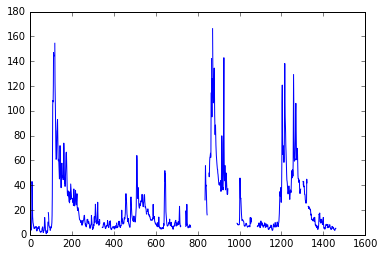

In [21]:
plt.plot(dfdaily['Turb_NTU'])

In [22]:
dds=dfdaily[dfdaily.Turb_NTU>0]['DayNum'].values
ts=dfdaily[dfdaily.Turb_NTU>0]['Turb_NTU'].values

In [23]:
dfnan=dfdaily[~(dfdaily.Turb_NTU>0)]
ddblanks=dfnan['DayNum'].values

In [24]:
dds1=[np.float(el) for el in dds]
ts1=[np.float(el) for el in ts]
ddblanks1=[np.float(el) for el in ddblanks]
tinterps=np.interp(ddblanks1,dds1,ts1)

In [25]:
oldDD=np.copy(dfdaily['DayNum'].values)
oldT=np.copy(dfdaily['Turb_NTU'].values)

In [26]:
for idd, newT in zip(ddblanks1,tinterps):
    dfdaily.loc[dfdaily.DayNum==idd,'Turb_NTU']=newT

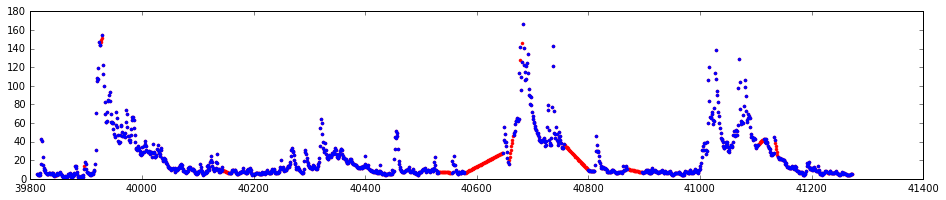

In [27]:
fig,ax=plt.subplots(1,1,figsize=(16,3))
ax.plot(dfdaily['DayNum'],dfdaily['Turb_NTU'],'r.')
ax.plot(oldDD,oldT,'b.')

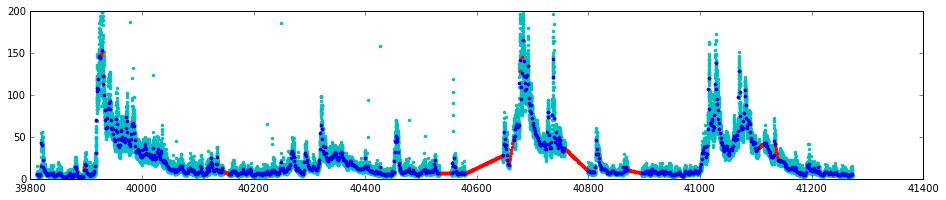

In [28]:
fig,ax=plt.subplots(1,1,figsize=(16,3))
ax.plot(df['DecDay'],df['Turb_NTU'],'c.')
ax.plot(dfdaily['DayNum'],dfdaily['Turb_NTU'],'r.')
ax.plot(oldDD,oldT,'b.')

In [29]:
iday=(startdate-dt.date(1900,1,1)).days
iTurb=dfdaily[dfdaily.DayNum==iday]['Turb_NTU'].values[0]
iTurb

5.439583333334061

## Interpolation/averaging look OK; now create files: 

create daily Fraser turbidity files:

In [30]:
f=nc.Dataset('/results/forcing/rivers/RLonFraCElse_y2016m01d23.nc') # example for dims
fnamebase='/ocean/eolson/MEOPAR/NEMO-forcing/rivers/riverTurbDaily201906_'
for idate in daterange(startdate,enddate):
    iday=(idate-dt.date(1900,1,1)).days
    lower=iday
    upper=iday+1
    iTurb=dfdaily[dfdaily.DayNum==iday]['Turb_NTU'].values[0]

    fname=fnamebase+idate.strftime('y%Ym%md%d')+'.nc'

    new=nc.Dataset(fname,'w')
    #Copy dimensions
    for dname, the_dim in f.dimensions.items():
        #print (dname, len(the_dim) if not the_dim.isunlimited() else None)
        new.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
    # create dimension variables:
    new_x=new.createVariable('nav_lat',np.float32,('y','x'),zlib=True)
    new_x[:]=f.variables['nav_lat'][:,:]

    new_y=new.createVariable('nav_lon',np.float32,('y','x'),zlib=True)
    new_y[:]=f.variables['nav_lon'][:,:]

    new_tc=new.createVariable('time_counter',np.float32,('time_counter'),zlib=True)
    new_tc[:]=f.variables['time_counter'][:]
    
    new_run=new.createVariable('turb',float,('time_counter', 'y', 'x'),zlib=True)
    new_run[:,:,:]=-999.99 # most cells are masked with negative numbers
    new_run[:,400:448, 338:380]=iTurb # set turbidity to daily average
    new_run[:,440:503,363:398]=iTurb # extend Turbidity all the way up river

    new.close()

In [31]:
ftest=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/rivers/riverTurbDaily201906_y2014m01d02.nc')

In [32]:
ftest

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): x(398), y(898), time_counter(1)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 time_counter(time_counter), float64 turb(time_counter,y,x)
    groups: 

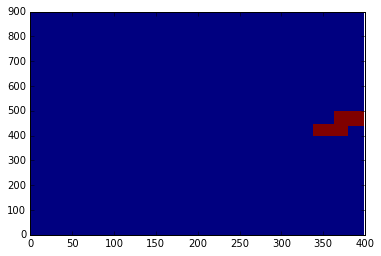

In [33]:
plt.pcolormesh(ftest.variables['turb'][0,:,:])

In [34]:
ftest.variables['turb'][0,410:425,364:368]

array([[ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625],
       [ 9.3625,  9.3625,  9.3625,  9.3625]])

In [35]:
ftest.close()

In [36]:
ftest=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/rivers/riverTurbDaily201906_y2017m06d21.nc')

In [37]:
ftest.variables['turb'][0,410:425,364:368]

array([[ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333],
       [ 28.05958333,  28.05958333,  28.05958333,  28.05958333]])

In [38]:
ftest.close()